**Please upload all datafiles to ensure the code runs as smoothly as possible. These are in separate files because it was worked on by multiple teammates and this way the code can be run in a more modular fashion if necessary. All code should run with the files properly uploaded. Thank you!**

In [ ]:
# import relevant packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

# **Upload and Clean the Financial Datasets**

In [ ]:
# Read the financial csv files and save it to dataframes 
Updated_SP_df = pd.read_csv('SP500 Returns_Weekly.csv')
Unemployment_df = pd.read_csv('US Monthly Unemployment Data_Weekly.csv')
GDP_df = pd.read_csv('GDP Delta Billions US_Weekly.csv')

First Clean the S&P 500 Dataset

In [ ]:
# Convert the "Start Date" column of the S&P 500 to datetime
Updated_SP_df['Start Date'] = pd.to_datetime(Updated_SP_df['Start Date'])

print(Updated_SP_df.dtypes)


SP_df_weekly = Updated_SP_df.copy()
SP_df_weekly.head()

Year                   int64
Month                  int64
Return               float64
Start Date    datetime64[ns]
dtype: object


Year  Month  Return Start Date
0  1975      1    0.11 1975-01-01
1  1975      2    0.05 1975-02-01
2  1975      3    0.01 1975-03-01
3  1975      4    0.07 1975-04-01
4  1975      5    0.03 1975-05-01

In [ ]:
#Duplicate the S&P 500 Financial Data So it Has Rows for Every Week of Every Year

# Set the index to the Start_Date column
SP_df_weekly.set_index('Start Date', inplace=True)

# Sort the DataFrame by the index column (Start Date)
SP_df_weekly = SP_df_weekly.sort_index()

# Resample the DataFrame to a weekly frequency and forward-fill missing data
SP_df_weekly = SP_df_weekly.resample('W').ffill()

# Reset the index to make the date column a regular column
SP_df_weekly = SP_df_weekly.reset_index()

# Add a column for week number
SP_df_weekly['Week Number'] = SP_df_weekly['Start Date'].dt.weekofyear

# Check Data
SP_df_weekly.head(75)
SP_df_weekly.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Start Date   2505 non-null   datetime64[ns]
 1   Year         2505 non-null   int64         
 2   Month        2505 non-null   int64         
 3   Return       2505 non-null   float64       
 4   Week Number  2505 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 98.0 KB


<ipython-input-5-c616ac0d65a6>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  SP_df_weekly['Week Number'] = SP_df_weekly['Start Date'].dt.weekofyear


Next Clean the GDP Change Dataset

In [ ]:
# Convert the "Start Date" column of GDP Data to datetime
GDP_df['Start Date'] = pd.to_datetime(GDP_df['Start Date'])

print(GDP_df.dtypes)

GDP_df_weekly = GDP_df.copy()

Start Date     datetime64[ns]
GDP Change            float64
Month Start             int64
Month End               int64
Year                    int64
dtype: object


In [ ]:
#Duplicate the GDP Financial Data So it Has Rows for Every Week of Every Year between 

# Set the index to the Start_Date column
GDP_df_weekly.set_index('Start Date', inplace=True)

# Sort the DataFrame by the index column (Start Date)
GDP_df_weekly = GDP_df_weekly.sort_index()

# Resample the DataFrame to a weekly frequency and forward-fill missing data
GDP_df_weekly = GDP_df_weekly.resample('W').ffill()

# Reset the index to make the date column a regular column
GDP_df_weekly = GDP_df_weekly.reset_index()

# Add a column for week number
GDP_df_weekly['Week Number'] = GDP_df_weekly['Start Date'].dt.weekofyear

# Add a Month Number column
GDP_df_weekly['Month'] = GDP_df_weekly['Start Date'].dt.month

GDP_df_weekly = GDP_df_weekly.drop(['Month Start', 'Month End'], axis=1)

# Check Data
GDP_df_weekly.head(15)

<ipython-input-7-6e1dd98cdf1c>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  GDP_df_weekly['Week Number'] = GDP_df_weekly['Start Date'].dt.weekofyear


Start Date  GDP Change  Year  Week Number  Month
0  1947-01-05       0.000  1947            1      1
1  1947-01-12       0.000  1947            2      1
2  1947-01-19       0.000  1947            3      1
3  1947-01-26       0.000  1947            4      1
4  1947-02-02       0.000  1947            5      2
5  1947-02-09       0.000  1947            6      2
6  1947-02-16       0.000  1947            7      2
7  1947-02-23       0.000  1947            8      2
8  1947-03-02       0.000  1947            9      3
9  1947-03-09       0.000  1947           10      3
10 1947-03-16       0.000  1947           11      3
11 1947-03-23       0.000  1947           12      3
12 1947-03-30       0.000  1947           13      3
13 1947-04-06      -5.426  1947           14      4
14 1947-04-13      -5.426  1947           15      4

Finally Clean the Unemployment Rate Dataset

In [ ]:
# Convert the "Start Date" column of Unemployment Data to datetime
Unemployment_df['Start Date'] = pd.to_datetime(Unemployment_df['Start Date'])

print(Unemployment_df.dtypes)

Unemployment_df_weekly = Unemployment_df.copy()

Start Date           datetime64[ns]
Unemployment_Rate           float64
Year                          int64
dtype: object


In [ ]:
#Duplicate the Unemployment Financial Data So it Has Rows for Every Week of Every Year between 

# Set the index to the Start_Date column
Unemployment_df_weekly.set_index('Start Date', inplace=True)

# Sort the DataFrame by the index column (Start Date)
Unemployment_df_weekly = Unemployment_df_weekly.sort_index()

# Resample the DataFrame to a weekly frequency and forward-fill missing data
Unemployment_df_weekly = Unemployment_df_weekly.resample('W').ffill()

# Reset the index to make the date column a regular column
Unemployment_df_weekly = Unemployment_df_weekly.reset_index()

# Add a column for week number
Unemployment_df_weekly['Week Number'] = Unemployment_df_weekly['Start Date'].dt.weekofyear

# Add a Month Number column
Unemployment_df_weekly['Month'] = Unemployment_df_weekly['Start Date'].dt.month

# Add a Year Number column
Unemployment_df_weekly['Year'] = Unemployment_df_weekly['Start Date'].dt.year

# Check Data
Unemployment_df_weekly.head(15)

<ipython-input-9-5d060a4cb5a8>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  Unemployment_df_weekly['Week Number'] = Unemployment_df_weekly['Start Date'].dt.weekofyear


Start Date  Unemployment_Rate  Year  Week Number  Month
0  1975-01-05                8.1  1975            1      1
1  1975-01-12                8.1  1975            2      1
2  1975-01-19                8.1  1975            3      1
3  1975-01-26                8.1  1975            4      1
4  1975-02-02                8.1  1975            5      2
5  1975-02-09                8.1  1975            6      2
6  1975-02-16                8.1  1975            7      2
7  1975-02-23                8.1  1975            8      2
8  1975-03-02                8.6  1975            9      3
9  1975-03-09                8.6  1975           10      3
10 1975-03-16                8.6  1975           11      3
11 1975-03-23                8.6  1975           12      3
12 1975-03-30                8.6  1975           13      3
13 1975-04-06                8.8  1975           14      4
14 1975-04-13                8.8  1975           15      4

Merge all Financial Datasets into 1 weekly Financial Dataset Over the time frame

In [ ]:
#Merge All the Financial Data to be in One Dataframe Called "Economy_df"
Economy_df = Unemployment_df_weekly.merge(GDP_df_weekly, on=["Start Date", "Week Number", "Month", "Year"], how="outer")
Economy_df = Economy_df.merge(SP_df_weekly, on=["Start Date", "Week Number", "Month", "Year"], how="outer")

#Rearrange columns
Economy_df = Economy_df.reindex(columns=['Start Date', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change', 'Unemployment_Rate'])
Economy_df = Economy_df.sort_values(by='Start Date', ascending= True)


#Drop rows with any missing values
Economy_df = Economy_df.dropna(axis=0)


#Check the resulting dataframe
Economy_df.head(3000)



Start Date  Year  Month  Week Number  Return  GDP Change  \
0    1975-01-05  1975      1            1    0.11     -68.413   
1    1975-01-12  1975      1            2    0.11     -68.413   
2    1975-01-19  1975      1            3    0.11     -68.413   
3    1975-01-26  1975      1            4    0.11     -68.413   
4    1975-02-02  1975      2            5    0.05     -68.413   
...         ...   ...    ...          ...     ...         ...   
2487 2022-09-04  2022      9           35   -0.03     159.392   
2488 2022-09-11  2022      9           36   -0.03     159.392   
2489 2022-09-18  2022      9           37   -0.03     159.392   
2490 2022-09-25  2022      9           38   -0.03     159.392   
2491 2022-10-02  2022     10           39    0.05     127.828   

      Unemployment_Rate  
0                   8.1  
1                   8.1  
2                   8.1  
3                   8.1  
4                   8.1  
...                 ...  
2487                3.5  
2488                3.5  
2489                3.5  
2490                3.5  
2491                3.7  

[2492 rows x 7 columns]

# **Now, we will import and clean the annual movie dataset for EDA**

In [ ]:
#First we will look at some annual movie trend information 
annual_df = pd.read_csv("Annual Movie Top.csv")

#Drop Null Values 
annual_df = annual_df.dropna()

#Clean data inputs via string conversions
annual_df['Total Gross'] = pd.to_numeric(annual_df['Total Gross'].str.replace(',', ''), errors='coerce')

annual_df['Average'] = pd.to_numeric(annual_df['Average'].str.replace('$', '').str.replace(',', ''), downcast='integer')



<ipython-input-11-b68c7a8a916a>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  annual_df['Average'] = pd.to_numeric(annual_df['Average'].str.replace('$', '').str.replace(',', ''), downcast='integer')


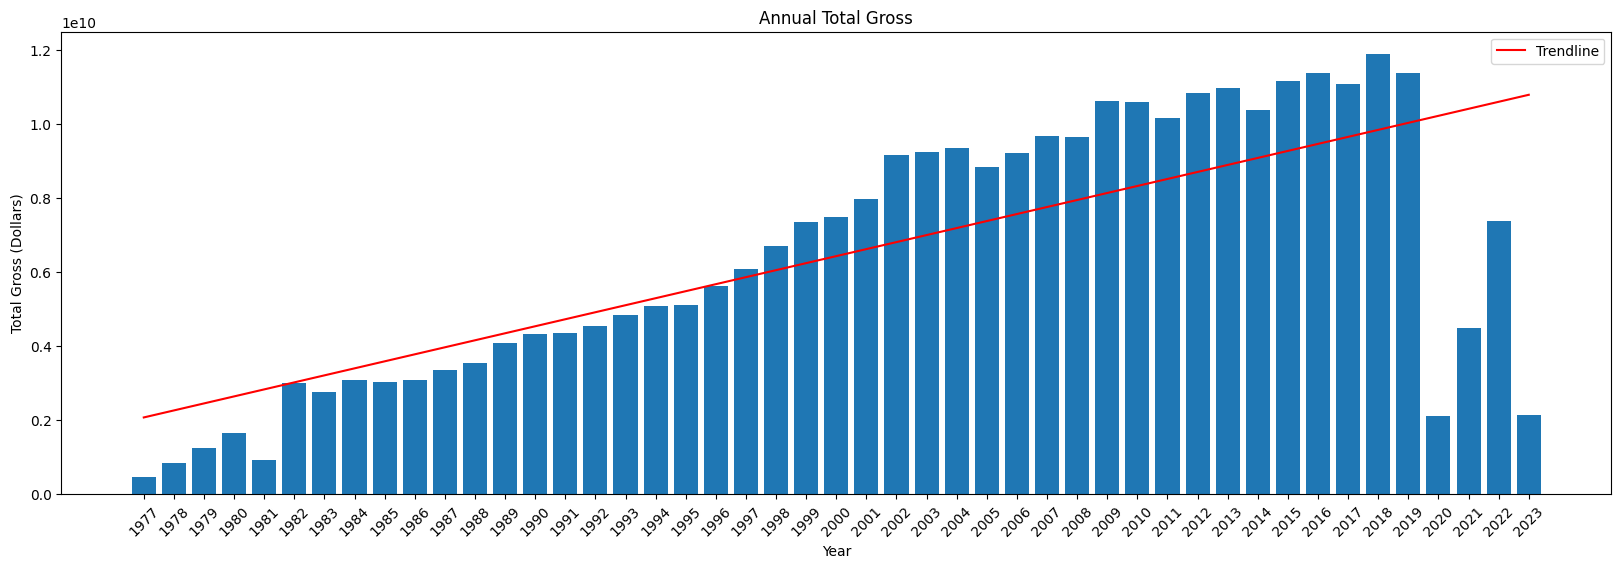

In [ ]:
# Create a figure showing total box office revenue over time for Exploratory Data Analysis purposes
fig, ax = plt.subplots(figsize=(20, 6))

# plot the bar graph
ax.bar(annual_df['Year'], annual_df['Total Gross'])

# calculate trendline
x = annual_df['Year']
y = annual_df['Total Gross']
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# plot trendline
ax.plot(x, trendline(x), color='red', label='Trendline')

# set x-axis label and tick rotation
ax.set_xlabel('Year')
ax.set_xticks(annual_df['Year'])
ax.tick_params(axis='x', rotation=45)

# set y-axis label and title
ax.set_ylabel('Total Gross (Dollars)')
ax.set_title('Annual Total Gross')

# add legend
ax.legend()

# display the plot
plt.show()

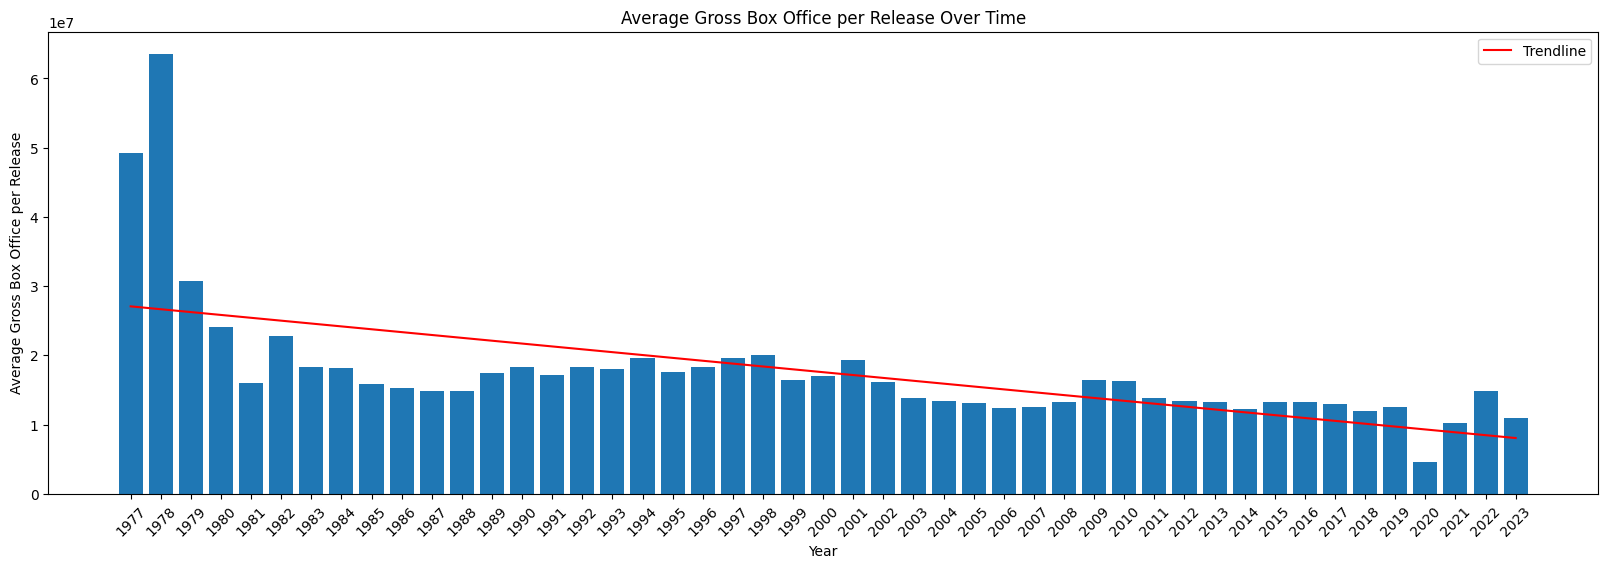

In [ ]:
# Create a figure showing total box office revenue per release over time for Exploratory Data Analysis purposes
fig, ax = plt.subplots(figsize=(20, 6))

# plot the bar graph
ax.bar(annual_df['Year'], annual_df['Average'])

# calculate trendline
x = annual_df['Year']
y = annual_df['Average']
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# plot trendline
ax.plot(x, trendline(x), color='red', label='Trendline')

# set x-axis label and tick rotation
ax.set_xlabel('Year')
ax.set_xticks(annual_df['Year'])
ax.tick_params(axis='x', rotation=45)

# set y-axis label and title
ax.set_ylabel('Average Gross Box Office per Release')
ax.set_title('Average Gross Box Office per Release Over Time')

# add legend
ax.legend()

# display the plot
plt.show()

Join the financial data with annual movie data to create a few EDA plots 

In [ ]:
#Add Yearly Financial Data to Annual Movie Data
Annual_Unemployment_df = Unemployment_df.groupby('Year')['Unemployment_Rate'].mean().reset_index()
merged_annual_df = pd.merge(annual_df, Annual_Unemployment_df, on='Year')
merged_annual_df.head(3)


Year  Total Gross  Change LY  Releases   Average  \
0  2023.0   2139855933       0.00     196.0  10917632   
1  2022.0   7369357270       0.64     496.0  14857575   
2  2021.0   4482808453       1.12     440.0  10188201   

                Top Release  Unemployment_Rate  
0  Avatar: The Way of Water           3.500000  
1         Top Gun: Maverick           3.641667  
2   Spider-Man: No Way Home           5.366667

In [ ]:
#Add Yearly Financial Data to Annual Movie Data
Updated_SP_df = Updated_SP_df.groupby('Year')['Return'].sum().reset_index()
merged_annual_df = pd.merge(merged_annual_df, Updated_SP_df, on='Year')
merged_annual_df.head(3)

Year  Total Gross  Change LY  Releases   Average  \
0  2023.0   2139855933       0.00     196.0  10917632   
1  2022.0   7369357270       0.64     496.0  14857575   
2  2021.0   4482808453       1.12     440.0  10188201   

                Top Release  Unemployment_Rate  Return  
0  Avatar: The Way of Water           3.500000    0.06  
1         Top Gun: Maverick           3.641667   -0.13  
2   Spider-Man: No Way Home           5.366667    0.20

In [ ]:
#Add Yearly Financial Data to Annual Movie Data
GDP_df = GDP_df.groupby('Year')['GDP Change'].sum().reset_index()
merged_annual_df = pd.merge(merged_annual_df, GDP_df, on='Year')
merged_annual_df.head(3)

Year  Total Gross  Change LY  Releases   Average  \
0  2022.0   7369357270       0.64     496.0  14857575   
1  2021.0   4482808453       1.12     440.0  10188201   
2  2020.0   2113846800      -0.81     456.0   4635628   

               Top Release  Unemployment_Rate  Return  GDP Change  
0        Top Gun: Maverick           3.641667   -0.13     176.310  
1  Spider-Man: No Way Home           5.366667    0.20    1081.919  
2        Bad Boys for Life           8.091667    0.19    -291.429

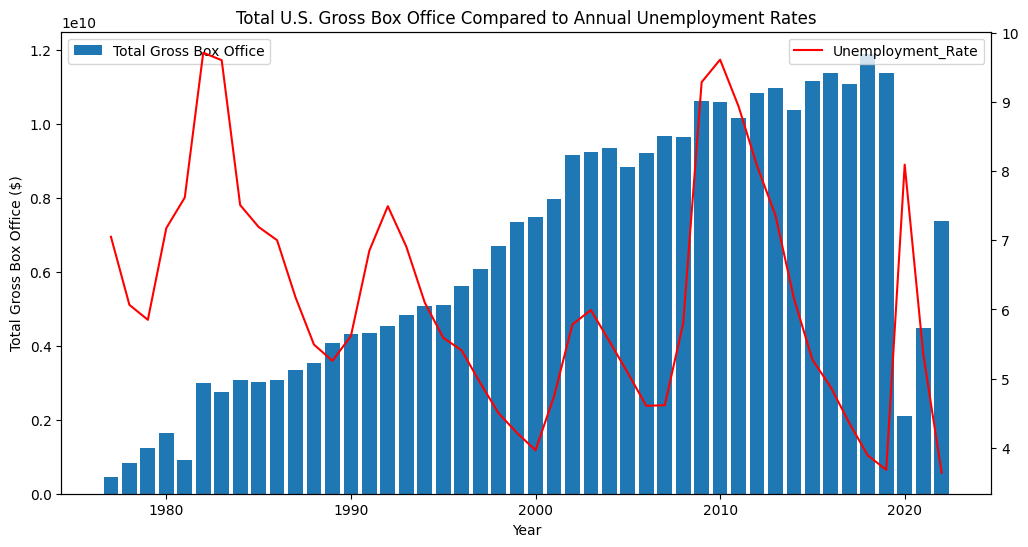

In [ ]:
# Creating the bar plot for Average Gross Domestic Box Office in given economic conditions (based on unemployment rate) 

fig, ax1 = plt.subplots()
fig.set_size_inches(12,6)

ax1.bar(merged_annual_df['Year'], merged_annual_df['Total Gross'], label='Total Gross Box Office')

# Adding labels and title
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Gross Box Office ($)")
ax1.set_title("Total U.S. Gross Box Office Compared to Annual Unemployment Rates")

# Creating a secondary axis for the line plot
ax2 = ax1.twinx()

# Plotting another column of data as a line on the secondary axis
ax2.plot(merged_annual_df['Year'], merged_annual_df['Unemployment_Rate'], color='red', label='Unemployment_Rate')

# Adding a legend to the plot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Displaying the plot
plt.show()

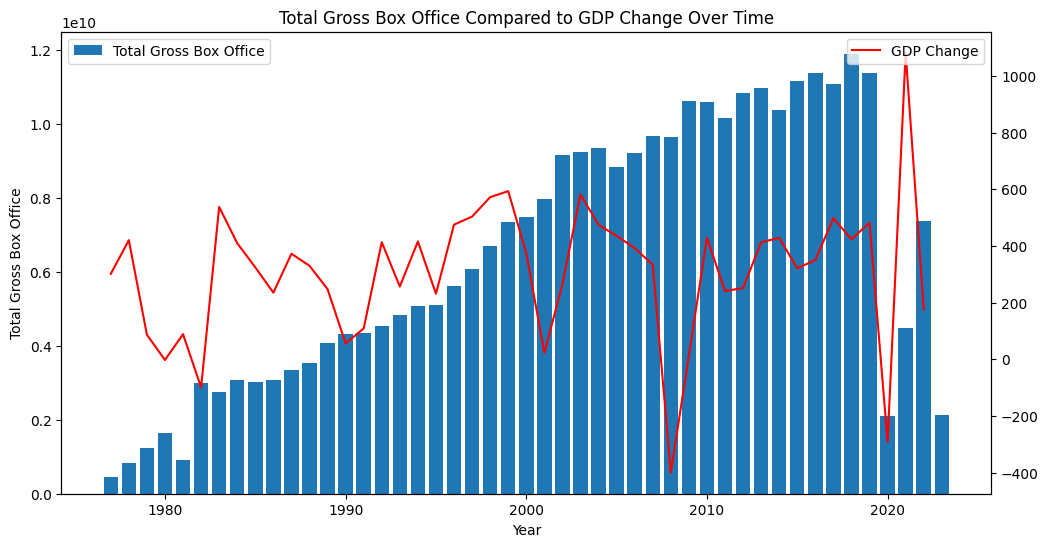

In [ ]:
# Creating the bar plot for Average Gross Domestic Box Office in given economic conditions (based on GDP change) 

fig, ax1 = plt.subplots()
fig.set_size_inches(12,6)

ax1.bar(annual_df['Year'], annual_df['Total Gross'], label='Total Gross Box Office')

# Adding labels and title
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Gross Box Office")
ax1.set_title("Total Gross Box Office Compared to GDP Change Over Time")

# Creating a secondary axis for the line plot
ax2 = ax1.twinx()

# Plotting another column of data as a line on the secondary axis
ax2.plot(merged_annual_df['Year'], merged_annual_df['GDP Change'], color='red', label='GDP Change')

# Adding a legend to the plot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Displaying the plot
plt.show()

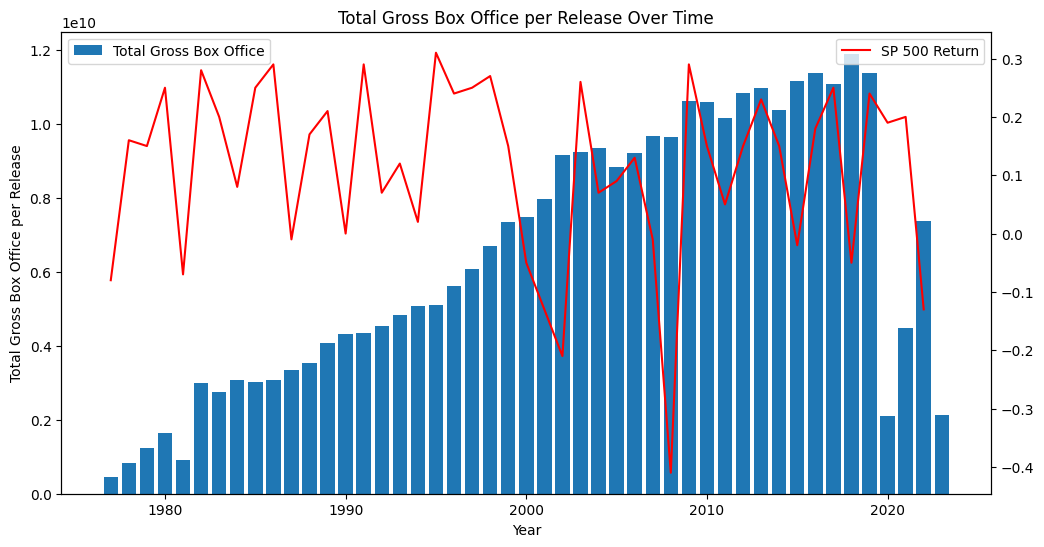

In [ ]:
# Creating the bar plot for Average Gross Domestic Box Office in given economic conditions (based on S&P 500 Returns) 

fig, ax1 = plt.subplots()
fig.set_size_inches(12,6)

ax1.bar(annual_df['Year'], annual_df['Total Gross'], label='Total Gross Box Office')

# Adding labels and title
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Gross Box Office per Release")
ax1.set_title("Total Gross Box Office per Release Over Time")

# Creating a secondary axis for the line plot
ax2 = ax1.twinx()

# Plotting another column of data as a line on the secondary axis
ax2.plot(merged_annual_df['Year'], merged_annual_df['Return'], color='red', label='SP 500 Return')

# Adding a legend to the plot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Displaying the plot
plt.show()

# **Clean up the Weekly Movie Data**

In [ ]:
import pandas as pd

# create an empty dataframe to store all the cleaned data
all_df = pd.DataFrame()

# loop through each year from 1977 to 2023
for year in range(1977, 2024):
    
    # create the file name
    file_name = f'weekend_summary_{year}.csv'
    
    # read in the data
    df = pd.read_csv(file_name)
    
    # split the Date column by the hyphen
    df[['Date Start', 'Date End']] = df['date'].str.split('-', expand=True)
    yearcurr = year

    # extract the month and year from the Date Start column
    df[['Month Start', 'Year']] = df['Date Start'].str.split(n=1, expand=True)

    # extract the month from the Date End column
    df['Month End'] = df['Date End'].str.extract('([a-zA-Z]{3})', expand=False)

    # fill NaN values in Month End column with Month Start
    df['Month End'].fillna(df['Month Start'], inplace=True)

    # extract the day from the Date Start and Date End columns
    df['Date Start'] = df['Date Start'].str.extract('(\d+)')
    df['Date End'] = df['Date End'].str.extract('(\d+)')

    # fill NaN values in Year column with the current year
    df['Year Start'] = yearcurr
    df['Year End'] = df['date'].str.extract(r'(\d{4})$')
    df['Year End'].fillna(yearcurr, inplace=True)
    df = df.drop(columns=['Year'])

    # append the cleaned data to the all_df dataframe
    all_df = pd.concat([all_df, df], ignore_index=True)


# display the cleaned data
print(all_df)


                    date              occasion   top10_gross top10_wow_change  \
0     Dec 30-Jan 2, 1978  New Year's long wknd             -                -   
1     Dec 30-Jan 1, 1978                   NaN             -                -   
2              Dec 23-26   Christmas long wknd    $5,564,559                -   
3              Dec 23-25                   NaN             -                -   
4              Dec 16-18                   NaN   $10,102,221          +776.2%   
...                  ...                   ...           ...              ...   
2748           Jan 27-29                   NaN   $62,261,869             -12%   
2749           Jan 20-22                   NaN   $70,766,896           -28.4%   
2750           Jan 13-16              MLK wknd  $119,958,973                -   
2751           Jan 13-15                   NaN   $98,902,358            -5.1%   
2752             Jan 6-8                   NaN  $104,267,030            +2.1%   

     overall_gross overall_

In [ ]:
all_df.shape

(2753, 14)

In [ ]:
all_df= pd.read_csv("cleaned_movies.csv")

In [ ]:
df1 = pd.read_csv('movie.metadata.tsv', delimiter='\t', header=None, names=['Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'])


In [ ]:
df1

Freebase movie ID                                         Movie name  \
975900           /m/03vyhn                                     Ghosts of Mars   
3196793          /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
28463795        /m/0crgdbh                                        Brun bitter   
9363483         /m/0285_cd                                   White Of The Eye   
261236           /m/01mrr1                                  A Woman in Flames   
...                    ...                                                ...   
35228177        /m/0j7hxnt                           Mermaids: The Body Found   
34980460        /m/0g4pl34                                            Knuckle   
9971909         /m/02pygw1                                  Another Nice Mess   
913762           /m/03pcrp  The Super Dimension Fortress Macross II: Lover...   
12476867        /m/02w7zz8                                            Spliced   

         Movie release date  Movie box office revenue  Movie runtime  \
975900           2001-08-24                14010832.0           98.0   
3196793          2000-02-16                       NaN           95.0   
28463795               1988                       NaN           83.0   
9363483                1987                       NaN          110.0   
261236                 1983                       NaN          106.0   
...                     ...                       ...            ...   
35228177         2011-03-19                       NaN          120.0   
34980460         2011-01-21                       NaN           96.0   
9971909          1972-09-22                       NaN           66.0   
913762           1992-05-21                       NaN          150.0   
12476867               2002                       NaN           86.0   

                             Movie languages  \
975900    {"/m/02h40lc": "English Language"}   
3196793   {"/m/02h40lc": "English Language"}   
28463795  {"/m/05f_3": "Norwegian Language"}   
9363483   {"/m/02h40lc": "English Language"}   
261236     {"/m/04306rv": "German Language"}   
...                                      ...   
35228177  {"/m/02h40lc": "English Language"}   
34980460  {"/m/02h40lc": "English Language"}   
9971909   {"/m/02h40lc": "English Language"}   
913762     {"/m/03_9r": "Japanese Language"}   
12476867  {"/m/02h40lc": "English Language"}   

                                            Movie countries  \
975900            {"/m/09c7w0": "United States of America"}   
3196793           {"/m/09c7w0": "United States of America"}   
28463795                             {"/m/05b4w": "Norway"}   
9363483                      {"/m/07ssc": "United Kingdom"}   
261236                              {"/m/0345h": "Germany"}   
...                                                     ...   
35228177          {"/m/09c7w0": "United States of America"}   
34980460  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
9971909           {"/m/09c7w0": "United States of America"}   
913762                                {"/m/03_3d": "Japan"}   
12476867                            {"/m/0d060g": "Canada"}   

                                               Movie genres  
975900    {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
3196793   {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
28463795  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
9363483   {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
261236                              {"/m/07s9rl0": "Drama"}  
...                                                     ...  
35228177                            {"/m/07s9rl0": "Drama"}  
34980460  {"/m/03bxz7": "Biographical film", "/m/07s9rl0...  
9971909        {"/m/06nbt": "Satire", "/m/01z4y": "Comedy"}  
913762    {"/m/06n90": "Science Fiction", "/m/0gw5n2f": ...  
12476867  {"/m/01jfsb": "Thriller", "/m/03npn": "Horror"...  

[81741 rows x 8 columns]

In [ ]:
# Clean Genre Column 
import ast

def extract_genres(genre_dict):
    genre_list = []
    for key in genre_dict.keys():
        genre_list.append(genre_dict[key])
    return ', '.join(genre_list)

df1['Movie genres'] = df1['Movie genres'].apply(ast.literal_eval)
df1['Movie Genre Cleaned'] = df1['Movie genres'].apply(extract_genres)


In [ ]:
df1

Freebase movie ID                                         Movie name  \
975900           /m/03vyhn                                     Ghosts of Mars   
3196793          /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
28463795        /m/0crgdbh                                        Brun bitter   
9363483         /m/0285_cd                                   White Of The Eye   
261236           /m/01mrr1                                  A Woman in Flames   
...                    ...                                                ...   
35228177        /m/0j7hxnt                           Mermaids: The Body Found   
34980460        /m/0g4pl34                                            Knuckle   
9971909         /m/02pygw1                                  Another Nice Mess   
913762           /m/03pcrp  The Super Dimension Fortress Macross II: Lover...   
12476867        /m/02w7zz8                                            Spliced   

         Movie release date  Movie box office revenue  Movie runtime  \
975900           2001-08-24                14010832.0           98.0   
3196793          2000-02-16                       NaN           95.0   
28463795               1988                       NaN           83.0   
9363483                1987                       NaN          110.0   
261236                 1983                       NaN          106.0   
...                     ...                       ...            ...   
35228177         2011-03-19                       NaN          120.0   
34980460         2011-01-21                       NaN           96.0   
9971909          1972-09-22                       NaN           66.0   
913762           1992-05-21                       NaN          150.0   
12476867               2002                       NaN           86.0   

                             Movie languages  \
975900    {"/m/02h40lc": "English Language"}   
3196793   {"/m/02h40lc": "English Language"}   
28463795  {"/m/05f_3": "Norwegian Language"}   
9363483   {"/m/02h40lc": "English Language"}   
261236     {"/m/04306rv": "German Language"}   
...                                      ...   
35228177  {"/m/02h40lc": "English Language"}   
34980460  {"/m/02h40lc": "English Language"}   
9971909   {"/m/02h40lc": "English Language"}   
913762     {"/m/03_9r": "Japanese Language"}   
12476867  {"/m/02h40lc": "English Language"}   

                                            Movie countries  \
975900            {"/m/09c7w0": "United States of America"}   
3196793           {"/m/09c7w0": "United States of America"}   
28463795                             {"/m/05b4w": "Norway"}   
9363483                      {"/m/07ssc": "United Kingdom"}   
261236                              {"/m/0345h": "Germany"}   
...                                                     ...   
35228177          {"/m/09c7w0": "United States of America"}   
34980460  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
9971909           {"/m/09c7w0": "United States of America"}   
913762                                {"/m/03_3d": "Japan"}   
12476867                            {"/m/0d060g": "Canada"}   

                                               Movie genres  \
975900    {'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...   
3196793   {'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...   
28463795  {'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...   
9363483   {'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...   
261236                              {'/m/07s9rl0': 'Drama'}   
...                                                     ...   
35228177                            {'/m/07s9rl0': 'Drama'}   
34980460  {'/m/03bxz7': 'Biographical film', '/m/07s9rl0...   
9971909        {'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}   
913762    {'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...   
12476867  {'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'...   

                                        Movie Genre Cleaned  
975900    Thriller

In [ ]:
df1.to_csv("movies_details.csv", index=False)

In [ ]:
import pandas as pd


In [ ]:
df1 = pd.read_csv('movies_details.csv')

In [ ]:
df1

Freebase movie ID                                         Movie name  \
0             /m/03vyhn                                     Ghosts of Mars   
1             /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
2            /m/0crgdbh                                        Brun bitter   
3            /m/0285_cd                                   White Of The Eye   
4             /m/01mrr1                                  A Woman in Flames   
...                 ...                                                ...   
81736        /m/0j7hxnt                           Mermaids: The Body Found   
81737        /m/0g4pl34                                            Knuckle   
81738        /m/02pygw1                                  Another Nice Mess   
81739         /m/03pcrp  The Super Dimension Fortress Macross II: Lover...   
81740        /m/02w7zz8                                            Spliced   

      Movie release date  Movie box office revenue  Movie runtime  \
0             2001-08-24                14010832.0           98.0   
1             2000-02-16                       NaN           95.0   
2                   1988                       NaN           83.0   
3                   1987                       NaN          110.0   
4                   1983                       NaN          106.0   
...                  ...                       ...            ...   
81736         2011-03-19                       NaN          120.0   
81737         2011-01-21                       NaN           96.0   
81738         1972-09-22                       NaN           66.0   
81739         1992-05-21                       NaN          150.0   
81740               2002                       NaN           86.0   

                          Movie languages  \
0      {"/m/02h40lc": "English Language"}   
1      {"/m/02h40lc": "English Language"}   
2      {"/m/05f_3": "Norwegian Language"}   
3      {"/m/02h40lc": "English Language"}   
4       {"/m/04306rv": "German Language"}   
...                                   ...   
81736  {"/m/02h40lc": "English Language"}   
81737  {"/m/02h40lc": "English Language"}   
81738  {"/m/02h40lc": "English Language"}   
81739   {"/m/03_9r": "Japanese Language"}   
81740  {"/m/02h40lc": "English Language"}   

                                         Movie countries  \
0              {"/m/09c7w0": "United States of America"}   
1              {"/m/09c7w0": "United States of America"}   
2                                 {"/m/05b4w": "Norway"}   
3                         {"/m/07ssc": "United Kingdom"}   
4                                {"/m/0345h": "Germany"}   
...                                                  ...   
81736          {"/m/09c7w0": "United States of America"}   
81737  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
81738          {"/m/09c7w0": "United States of America"}   
81739                              {"/m/03_3d": "Japan"}   
81740                            {"/m/0d060g": "Canada"}   

                                            Movie genres  \
0      {'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...   
1      {'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...   
2      {'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...   
3      {'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...   
4                                {'/m/07s9rl0': 'Drama'}   
...                                                  ...   
81736                            {'/m/07s9rl0': 'Drama'}   
81737  {'/m/03bxz7': 'Biographical film', '/m/07s9rl0...   
81738       {'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}   
81739  {'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...   
81740  {'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'...   

                                     Movie Genre Cleaned  
0      Thriller, Science Fiction, Horror, Adventure, ...  
1         Mystery, Biographical film, Drama, Crime Drama  
2                                   Crime Fiction, Drama  
3      Thriller, Erot

Merge Movie Data Files with Economic Files

In [ ]:
cm = all_df.merge(df1, left_on=['top_release'], right_on=['Movie name'], how='left')

In [ ]:
cm.columns

Index(['date', 'occasion', 'top10_gross', 'top10_wow_change', 'overall_gross',
       'overall_wow_change', 'num_releases', 'top_release', 'week_no',
       'Date Start', 'Date End', 'Month Start', 'Month End', 'Year Start',
       'Year End', 'Freebase movie ID', 'Movie name', 'Movie release date',
       'Movie box office revenue', 'Movie runtime', 'Movie languages',
       'Movie countries', 'Movie genres', 'Movie Genre Cleaned'],
      dtype='object')

In [ ]:
cm.to_csv("Joined_cleaned_movies.csv")

In [ ]:
cm = pd.read_csv("Joined_cleaned_movies.csv")

In [ ]:
cm.columns

Index(['Unnamed: 0', 'date', 'occasion', 'top10_gross', 'top10_wow_change',
       'overall_gross', 'overall_wow_change', 'num_releases', 'top_release',
       'week_no', 'Date Start', 'Date End', 'Month Start', 'Month End',
       'Year Start', 'Year End', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'runtimeMinutes', 'genres'],
      dtype='object')

In [ ]:
Economy_df.columns

Index(['Start Date', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate'],
      dtype='object')

In [ ]:
merged_df = Economy_df.merge(cm, left_on=[ 'Year', 'Month', 'Week Number'], right_on=['Year Start','Month Start','week_no'], how='inner')
merged_df

Start Date  Year  Month  Week Number  Return  GDP Change  \
0    1977-02-27  1977      2            8    0.00      71.035   
1    1977-03-06  1977      3            9   -0.01      71.035   
2    1977-03-13  1977      3           10   -0.01      71.035   
3    1977-03-20  1977      3           11   -0.01      71.035   
4    1977-05-22  1977      5           20    0.01     118.268   
...         ...   ...    ...          ...     ...         ...   
3530 2022-09-04  2022      9           35   -0.03     159.392   
3531 2022-09-04  2022      9           35   -0.03     159.392   
3532 2022-09-11  2022      9           36   -0.03     159.392   
3533 2022-09-18  2022      9           37   -0.03     159.392   
3534 2022-09-25  2022      9           38   -0.03     159.392   

      Unemployment_Rate  Unnamed: 0       date        occasion  ...  \
0                   7.6          39  Feb 25-27             NaN  ...   
1                   7.4          38    Mar 4-6             NaN  ...   
2                   7.4          37  Mar 11-13             NaN  ...   
3                   7.4          36  Mar 18-20             NaN  ...   
4                   7.0          35  May 20-22             NaN  ...   
...                 ...         ...        ...             ...  ...   
3530                3.5        3946    Sep 2-5  Labor Day wknd  ...   
3531                3.5        3947    Sep 2-4             NaN  ...   
3532                3.5        3945   Sep 9-11             NaN  ...   
3533                3.5        3944  Sep 16-18             NaN  ...   
3534                3.5        3943  Sep 23-25             NaN  ...   

     Month Start Month End Year Start Year End tconst titleType  primaryTitle  \
0              2         2       1977     1977    NaN       NaN           NaN   
1              3         3       1977     1977    NaN       NaN           NaN   
2              3         3       1977     1977    NaN       NaN           NaN   
3              3         3       1977     1977    NaN       NaN           NaN   
4              5         5       1977     1977    NaN       NaN           NaN   
...          ...       ...        ...      ...    ...       ...           ...   
3530           9         9       2022     2022    NaN       NaN           NaN   
3531           9         9       2022     2022    NaN       NaN           NaN   
3532           9         9       2022     2022    NaN       NaN           NaN   
3533           9         9       2022     2022    NaN       NaN           NaN   
3534           9         9       2022     2022    NaN       NaN           NaN   

      originalTitle  runtimeMinutes                                     genres  
0               NaN             NaN                 Action,Adventure,Animation  
1               NaN             NaN                 Action,Adventure,Animation  
2               NaN             NaN                 Action,Adventure,Animation  
3               NaN             NaN                 Action,Adventure,Animation  
4               NaN             NaN                 Action,Adventure,Animation  
...             ...             ...                                        ...  
3530            NaN             NaN                   Action, Adventure, Drama  
3531            NaN             NaN                   Action, Adventure, Drama  
3532            NaN             NaN                  Horror, Mystery, Thriller  
3533            NaN             NaN  Action, Adventure, Drama, Historical Film  
3534            NaN             NaN                            Drama, Thriller  

[3535 rows x 29 columns]

In [ ]:
merged_df.columns

Index(['Start Date', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'Unnamed: 0', 'date', 'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'num_releases', 'top_release', 'week_no', 'Date Start', 'Date End',
       'Month Start', 'Month End', 'Year Start', 'Year End', 'tconst',
       'titleType', 'primaryTitle', 'originalTitle', 'runtimeMinutes',
       'genres'],
      dtype='object')

In [ ]:
merged_df[['Start Date', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate',  'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'top_release', 'runtimeMinutes',
       'genres']]

Start Date  Year  Month  Week Number  Return  GDP Change  \
0    1977-02-27  1977      2            8    0.00      71.035   
1    1977-03-06  1977      3            9   -0.01      71.035   
2    1977-03-13  1977      3           10   -0.01      71.035   
3    1977-03-20  1977      3           11   -0.01      71.035   
4    1977-05-22  1977      5           20    0.01     118.268   
...         ...   ...    ...          ...     ...         ...   
3530 2022-09-04  2022      9           35   -0.03     159.392   
3531 2022-09-04  2022      9           35   -0.03     159.392   
3532 2022-09-11  2022      9           36   -0.03     159.392   
3533 2022-09-18  2022      9           37   -0.03     159.392   
3534 2022-09-25  2022      9           38   -0.03     159.392   

      Unemployment_Rate        occasion  top10_gross top10_wow_change  \
0                   7.6             NaN            -                -   
1                   7.4             NaN            -                -   
2                   7.4             NaN            -                -   
3                   7.4             NaN            -                -   
4                   7.0             NaN            -                -   
...                 ...             ...          ...              ...   
3530                3.5  Labor Day wknd  $54,205,807                -   
3531                3.5             NaN  $42,395,247            +2.4%   
3532                3.5             NaN  $33,945,638          -19.90%   
3533                3.5             NaN  $43,050,766           +26.8%   
3534                3.5             NaN  $55,769,690           +29.5%   

     overall_gross overall_wow_change          top_release runtimeMinutes  \
0                -                  -             Superman            NaN   
1                -                  -             Superman            NaN   
2                -                  -             Superman            NaN   
3                -                  -             Superman            NaN   
4                -                  -             Superman            NaN   
...            ...                ...                  ...            ...   
3530   $71,172,772                  -    Top Gun: Maverick            NaN   
3531   $55,664,136              +6.7%    Top Gun: Maverick            NaN   
3532   $43,193,037            -22.40%            Barbarian            NaN   
3533   $51,459,761             +19.1%       The Woman King            NaN   
3534   $62,428,984             +21.3%  Don't Worry Darling            NaN   

                                         genres  
0                    Action,Adventure,Animation  
1                    Action,Adventure,Animation  
2                    Action,Adventure,Animation  
3                    Action,Adventure,Animation  
4                    Action,Adventure,Animation  
...                                         ...  
3530                   Action, Adventure, Drama  
3531                   Action, Adventure, Drama  
3532                  Horror, Mystery, Thriller  
3533  Action, Adventure, Drama, Historical Film  
3534                            Drama, Thriller  

[3535 rows x 15 columns]

In [ ]:
# count the number of nulls in each column
null_counts = merged_df.isnull().sum()

# print the results
print(null_counts)

Start Date               0
Year                     0
Month                    0
Week Number              0
Return                   0
GDP Change               0
Unemployment_Rate        0
Unnamed: 0               0
date                     0
occasion              2813
top10_gross              0
top10_wow_change         0
overall_gross            0
overall_wow_change       0
num_releases             0
top_release              0
week_no                  0
Date Start               0
Date End                 0
Month Start              0
Month End                0
Year Start               0
Year End                 0
tconst                 974
titleType              974
primaryTitle           974
originalTitle          974
runtimeMinutes         974
genres                   0
dtype: int64


In [ ]:
#Clean Special Day Column 
merged_df['Special Day'] = merged_df['occasion'].notnull().astype(int)
merged_df[['Special Day', 'occasion']]

Special Day        occasion
0               0             NaN
1               0             NaN
2               0             NaN
3               0             NaN
4               0             NaN
...           ...             ...
3530            1  Labor Day wknd
3531            0             NaN
3532            0             NaN
3533            0             NaN
3534            0             NaN

[3535 rows x 2 columns]

In [ ]:
merged_df.to_csv("Original_Finance_Movies_Dataset.csv")

In [ ]:
merged_df.columns

Index(['Start Date', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'Unnamed: 0', 'date', 'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'num_releases', 'top_release', 'week_no', 'Date Start', 'Date End',
       'Month Start', 'Month End', 'Year Start', 'Year End', 'tconst',
       'titleType', 'primaryTitle', 'originalTitle', 'runtimeMinutes',
       'genres', 'Special Day'],
      dtype='object')

In [ ]:
final_merged_df = merged_df[['Start Date', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate',  'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'num_releases', 'top_release', 'week_no', 'Date Start', 'Date End',
       'Month Start', 'Month End', 'Year Start', 'Year End', 'runtimeMinutes',
       'genres', 'Special Day']]

In [ ]:
final_merged_df.to_csv("Clean_Finance_Movies_Dataset.csv")

In [ ]:
final_merged_df = pd.read_csv("Clean_Finance_Movies_Dataset.csv")

In [ ]:
final_merged_df.describe()

Unnamed: 0         Year        Month  Week Number       Return  \
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000   
mean   1767.000000  1999.598303     6.408487    25.930127     0.010857   
std    1020.610928    12.330292     3.473407    15.163117     0.034792   
min       0.000000  1977.000000     1.000000     1.000000    -0.200000   
25%     883.500000  1990.000000     3.000000    12.000000     0.000000   
50%    1767.000000  1998.000000     6.000000    25.000000     0.010000   
75%    2650.500000  2010.000000    10.000000    40.000000     0.030000   
max    3534.000000  2022.000000    12.000000    52.000000     0.120000   

        GDP Change  Unemployment_Rate      week_no   Date Start     Date End  \
count  3535.000000        3535.000000  3535.000000  3535.000000  3535.000000   
mean     77.713655           6.137850    25.930127    14.521358    16.446676   
std     160.385725           1.708663    15.163117     8.039133     8.078311   
min   -1611.165000           3.500000     1.000000     1.000000     1.000000   
25%      47.308000           4.900000    12.000000     8.000000    10.000000   
50%      89.704000           5.800000    25.000000    14.000000    16.000000   
75%     129.126000           7.200000    40.000000    21.000000    23.000000   
max    1365.008000          14.700000    52.000000    29.000000    31.000000   

       Month Start    Month End   Year Start     Year End  Special Day  
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000  
mean      6.408487     6.368034  1999.598303  1999.602263     0.204243  
std       3.473407     3.472676    12.330292    12.329916     0.403205  
min       1.000000     1.000000  1977.000000  1977.000000     0.000000  
25%       3.000000     3.000000  1990.000000  1990.000000     0.000000  
50%       6.000000     6.000000  1998.000000  1998.000000     0.000000  
75%      10.000000     9.000000  2010.000000  2010.000000     0.000000  
max      12.000000    12.000000  2022.000000  2022.000000     1.000000

In [ ]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3535 entries, 0 to 3534
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3535 non-null   int64  
 1   Start Date          3535 non-null   object 
 2   Year                3535 non-null   int64  
 3   Month               3535 non-null   int64  
 4   Week Number         3535 non-null   int64  
 5   Return              3535 non-null   float64
 6   GDP Change          3535 non-null   float64
 7   Unemployment_Rate   3535 non-null   float64
 8   occasion            722 non-null    object 
 9   top10_gross         3535 non-null   object 
 10  top10_wow_change    3535 non-null   object 
 11  overall_gross       3535 non-null   object 
 12  overall_wow_change  3535 non-null   object 
 13  num_releases        3535 non-null   object 
 14  top_release         3535 non-null   object 
 15  week_no             3535 non-null   int64  
 16  Date S

In [ ]:
Imp = final_merged_df[[ 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate',  'top_release',
       'genres', 'Special Day']]

In [ ]:
Imp.head(50)

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0   1977      2            8    0.00      71.035                7.6   
1   1977      3            9   -0.01      71.035                7.4   
2   1977      3           10   -0.01      71.035                7.4   
3   1977      3           11   -0.01      71.035                7.4   
4   1977      5           20    0.01     118.268                7.0   
5   1977      5           21    0.01     118.268                7.0   
6   1977      6           22    0.01     118.268                7.2   
7   1977      6           23    0.01     118.268                7.2   
8   1977      6           24    0.01     118.268                7.2   
9   1977      6           24    0.01     118.268                7.2   
10  1977      6           25    0.01     118.268                7.2   
11  1977      7           26   -0.02     111.900                6.9   
12  1977      7           26   -0.02     111.900                6.9   
13  1977      7           27   -0.02     111.900                6.9   
14  1977      7           28   -0.02     111.900                6.9   
15  1977      7           29   -0.02     111.900                6.9   
16  1977      7           30   -0.02     111.900                6.9   
17  1977      8           31   -0.01     111.900                7.0   
18  1977      8           32   -0.01     111.900                7.0   
19  1977      8           33   -0.01     111.900                7.0   
20  1977      8           34   -0.01     111.900                7.0   
21  1977      9           35   -0.02     111.900                6.8   
22  1977      9           37   -0.02     111.900                6.8   
23  1977      9           38   -0.02     111.900                6.8   
24  1977     10           40    0.01       0.138                6.8   
25  1977     10           40    0.01       0.138                6.8   
26  1977     10           41    0.01       0.138                6.8   
27  1977     10           42    0.01       0.138                6.8   
28  1977     10           43    0.01       0.138                6.8   
29  1977     11           44    0.00       0.138                6.8   
30  1977     11           45    0.00       0.138                6.8   
31  1977     11           46    0.00       0.138                6.8   
32  1977     11           47    0.00       0.138                6.8   
33  1977     12           48   -0.03       0.138                6.4   
34  1977     12           49   -0.03       0.138                6.4   
35  1977     12           50   -0.03       0.138                6.4   
36  1977     12           51   -0.03       0.138                6.4   
37  1977     12           51   -0.03       0.138                6.4   
38  1978      1            1   -0.01      20.151                6.4   
39  1978      2            5    0.00      20.151                6.3   
40  1978      2            7    0.00      20.151                6.3   
41  1978      2            7    0.00      20.151                6.3   
42  1978      3           10    0.05      20.151                6.3   
43  1978      4           14    0.06     244.757                6.1   
44  1978      4           15    0.06     244.757                6.1   
45  1978      4           16    0.06     244.757                6.1   
46  1978      6           23    0.00     244.757                5.9   
47  1978      6           24    0.00     244.757                5.9   
48  1978      6           25    0.00     244.757                5.9   
49  1978      7           27    0.07      66.149                6.2   

                           top_release                          genres  \
0                             Superman      Action,Adventure,Animation   
1                             Superman      Action,Adventure,Animation   
2                             Superman      Action,Adventure,Animation   
3                             Superman      Action,Adventure,Animation   
4           

Cleaning for Genre Prediction

In [ ]:
df = pd.read_csv('Clean_Finance_Movies_Dataset.csv')

In [ ]:
df.dtypes

Unnamed: 0              int64
Start Date             object
Year                    int64
Month                   int64
Week Number             int64
Return                float64
GDP Change            float64
Unemployment_Rate     float64
occasion               object
top10_gross            object
top10_wow_change       object
overall_gross          object
overall_wow_change     object
num_releases           object
top_release            object
week_no                 int64
Date Start              int64
Date End                int64
Month Start             int64
Month End               int64
Year Start              int64
Year End                int64
runtimeMinutes         object
genres                 object
Special Day             int64
dtype: object

In [ ]:
df.columns

Index(['Unnamed: 0', 'Start Date', 'Year', 'Month', 'Week Number', 'Return',
       'GDP Change', 'Unemployment_Rate', 'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'num_releases', 'top_release', 'week_no', 'Date Start', 'Date End',
       'Month Start', 'Month End', 'Year Start', 'Year End', 'runtimeMinutes',
       'genres', 'Special Day'],
      dtype='object')

In [ ]:
num = df['num_releases']
num.unique 

<bound method Series.unique of 0        -
1        -
2        -
3        -
4        -
        ..
3530    55
3531    63
3532    69
3533    74
3534    72
Name: num_releases, Length: 3535, dtype: object>

In [ ]:
df['num_releases'] = df['num_releases'].replace('-', method='ffill')
df['num_releases'] = df['num_releases'].replace(' -', method='ffill')
df['num_releases'] = df['num_releases'].replace('- ', method='ffill')
df['num_releases'] = df['num_releases'].replace('NaN', method='ffill')


In [ ]:
count = df['num_releases'].apply(lambda x: x == '-').sum()
count

5

In [ ]:
df1 = df[['Year', 'Month', 'Week Number', 'Return',
       'GDP Change', 'Unemployment_Rate', 'num_releases', 'Special Day',       
       'genres' ]]
df1

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
3530  2022      9           35   -0.03     159.392                3.5   
3531  2022      9           35   -0.03     159.392                3.5   
3532  2022      9           36   -0.03     159.392                3.5   
3533  2022      9           37   -0.03     159.392                3.5   
3534  2022      9           38   -0.03     159.392                3.5   

     num_releases  Special Day                                     genres  
0               -            0                 Action,Adventure,Animation  
1               -            0                 Action,Adventure,Animation  
2               -            0                 Action,Adventure,Animation  
3               -            0                 Action,Adventure,Animation  
4               -            0                 Action,Adventure,Animation  
...           ...          ...                                        ...  
3530           55            1                   Action, Adventure, Drama  
3531           63            0                   Action, Adventure, Drama  
3532           69            0                  Horror, Mystery, Thriller  
3533           74            0  Action, Adventure, Drama, Historical Film  
3534           72            0                            Drama, Thriller  

[3535 rows x 9 columns]

In [ ]:
# Split the genre names by comma or ampersand and create a list of genres
genres_list = df['genres'].str.replace('&', ',').str.split(',').explode().str.strip().tolist()

# Create a dictionary to count the frequency of each genre
genre_count = {}
for genre in genres_list:
    genre = genre.lower()  # Convert to lowercase
    if genre not in genre_count:
        genre_count[genre] = 1
    else:
        genre_count[genre] += 1

# Print the genre counts
for genre, count in genre_count.items():
    print(genre, count)


action 1257
adventure 1119
animation 193
fantasy 467
mystery 209
thriller 552
short 144
comedy 1165
drama 1327
sci-fi 257
music 52
horror 275
romance 419
crime 467
western 73
history 91
war 82
family 273
sport 51
adult 74
biography 55
romanceadult 7
musical 48
documentary 22
science fiction 173
game-show 2
film-noir 12
\n 15
sports 23
recreation 23
historical film 10
children's/family 89
spy film 11
neo-noir 1
superhero 8
ction 2
science 3
technology 3
spirituality 3
philosophy 3
culture 3
society 3
it chapter two 2
personal relationships 8
abominable 1


In [ ]:
df1['genres'] = df1['genres'].str.replace('ction', 'Action')
# Rename 'aaction' as 'action'
df1['genres'] = df1['genres'].str.replace('aaction', 'action', case=False)

# Remove '\n' from 'genres' column
df1['genres'] = df1['genres'].str.replace('\n', '', regex=True)

# Remove 'It Chapter Two' from 'genres' column
df1['genres'] = df1['genres'].str.replace('It Chapter Two', 'horror', regex=False)
df1['genres'] = df1['genres'].str.replace('romanceadult', 'romance ', regex=True,case=False)
df1['genres'] = df1['genres'].str.replace('sportss', 'sports', regex=True,case=False)
df1['genres'] = df1['genres'].str.replace('sport', 'sports', regex=True,case=False)
df1['genres'] = df1['genres'].str.replace('science fiaction', 'Sci-Fi', regex=True,case=False)


<ipython-input-72-8dfe1c820eba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['genres'] = df1['genres'].str.replace('ction', 'Action')
<ipython-input-72-8dfe1c820eba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['genres'] = df1['genres'].str.replace('aaction', 'action', case=False)
<ipython-input-72-8dfe1c820eba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# Split the genre names by comma or ampersand and create a list of genres
genres_list = df1['genres'].str.replace('&', ',').str.split(',').explode().str.strip().tolist()

# Create a dictionary to count the frequency of each genre
genre_count = {}
for genre in genres_list:
    genre = genre.lower()  # Convert to lowercase
    if genre not in genre_count:
        genre_count[genre] = 1
    else:
        genre_count[genre] += 1

# Print the genre counts
for genre, count in genre_count.items():
    print(genre, count)


action 1259
adventure 1119
animation 193
fantasy 467
mystery 209
thriller 552
short 144
comedy 1165
drama 1327
sci-fi 430
music 52
horror 277
romance 426
crime 467
western 73
history 91
war 82
family 273
sports 51
adult 74
biography 55
musical 48
documentary 22
game-show 2
film-noir 12
\n 15
sportss 23
recreation 23
historical film 10
children's/family 89
spy film 11
neo-noir 1
superhero 8
science 3
technology 3
spirituality 3
philosophy 3
culture 3
society 3
personal relationships 8
abominable 1


In [ ]:
df1 = pd.read_csv('Final_Cleaned_Dataset.csv')

In [ ]:
df2 = pd.read_csv('Regrouping Genres.csv')

In [ ]:
df1.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'genres'],
      dtype='object')

In [ ]:
df2.columns

Index(['Proposed Consolidated Genres', 'Given Genres'], dtype='object')

Merge Cleaned Genre Data

In [ ]:
new_merged_df = df1.merge(df2, left_on=[ 'genres'], right_on=['Given Genres'], how='left')

In [ ]:
new_merged_df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'genres',
       'Proposed Consolidated Genres', 'Given Genres'],
      dtype='object')

In [ ]:
new_merged_df.isna().sum()

Unnamed: 0                      0
Year                            0
Month                           0
Week Number                     0
Return                          0
GDP Change                      0
Unemployment_Rate               0
num_releases                    0
Special Day                     0
genres                          0
Proposed Consolidated Genres    4
Given Genres                    4
dtype: int64

In [ ]:
new_merged_df = new_merged_df.dropna(subset=['Proposed Consolidated Genres'])
new_merged_df = new_merged_df.drop(['genres', 'Given Genres'], axis=1)
new_merged_df = new_merged_df.rename(columns={'Proposed Consolidated Genres': 'genres'})


In [ ]:
new_merged_df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'genres',
       'Proposed Consolidated Genres', 'Given Genres'],
      dtype='object')

In [ ]:
new_merged_df.head(50)

Unnamed: 0  Year  Month  Week Number  Return  GDP Change  \
0            0  1977      2            8    0.00      71.035   
1            1  1977      3            9   -0.01      71.035   
2            2  1977      3           10   -0.01      71.035   
3            3  1977      3           11   -0.01      71.035   
4            4  1977      5           20    0.01     118.268   
5            5  1977      5           21    0.01     118.268   
6            6  1977      6           22    0.01     118.268   
7            7  1977      6           23    0.01     118.268   
8            8  1977      6           24    0.01     118.268   
9            9  1977      6           24    0.01     118.268   
10          10  1977      6           25    0.01     118.268   
11          11  1977      7           26   -0.02     111.900   
12          12  1977      7           26   -0.02     111.900   
13          13  1977      7           27   -0.02     111.900   
14          14  1977      7           28   -0.02     111.900   
15          15  1977      7           29   -0.02     111.900   
16          16  1977      7           30   -0.02     111.900   
17          17  1977      8           31   -0.01     111.900   
18          18  1977      8           32   -0.01     111.900   
19          19  1977      8           33   -0.01     111.900   
20          20  1977      8           34   -0.01     111.900   
21          21  1977      9           35   -0.02     111.900   
22          22  1977      9           37   -0.02     111.900   
23          23  1977      9           38   -0.02     111.900   
24          24  1977     10           40    0.01       0.138   
25          25  1977     10           40    0.01       0.138   
26          26  1977     10           41    0.01       0.138   
27          27  1977     10           42    0.01       0.138   
28          28  1977     10           43    0.01       0.138   
29          29  1977     11           44    0.00       0.138   
30          30  1977     11           45    0.00       0.138   
31          31  1977     11           46    0.00       0.138   
32          32  1977     11           47    0.00       0.138   
33          33  1977     12           48   -0.03       0.138   
34          34  1977     12           49   -0.03       0.138   
35          35  1977     12           50   -0.03       0.138   
36          36  1977     12           51   -0.03       0.138   
37          37  1977     12           51   -0.03       0.138   
38          38  1978      1            1   -0.01      20.151   
39          39  1978      2            5    0.00      20.151   
40          40  1978      2            7    0.00      20.151   
41          41  1978      2            7    0.00      20.151   
42          42  1978      3           10    0.05      20.151   
43          43  1978      4           14    0.06     244.757   
44          44  1978      4           15    0.06     244.757   
45          45  1978      4           16    0.06     244.757   
46          46  1978      6           23    0.00     244.757   
47          47  1978      6           24    0.00     244.757   
48          48  1978      6           25    0.00     244.757   
49          49  1978      7           27    0.07      66.149   

    Unemployment_Rate  num_releases  Special Day  \
0                 7.6             1            0   
1                 7.4             1            0   
2                 7.4             1            0   
3                 7.4             1            0   
4                 7.0             1            0   
5                 7.0             1            1   
6                 7.2             1            0   
7                 7.2             1            0   
8                 7.2             3            0   
9                 7.2             3            0   
10                7.2             1            0   
11                6.9             1            0   
12                6.9             1            1   
13         

In [ ]:
new_merged_df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'genres',
       'Proposed Consolidated Genres', 'Given Genres'],
      dtype='object')

In [ ]:
df = new_merged_df

In [ ]:
df['genres'] = df['genres'].str.replace('sports', 'sport', regex=True,case=False)
df['genres'] = df['genres'].str.replace("children's/family", 'family', regex=True,case=False)
df['genres'] = df['genres'].str.replace('sports', 'sport', regex=True,case=False)

In [ ]:
df.to_csv('Final_Modified_Genre.csv')

In [ ]:
all_genres = set()
for genres in df['genres']:
    for genre in genres.replace('&', ',').split(','):
        all_genres.add(genre.strip())
        
# create a new column for each genre type and initialize with zeros
for genre in all_genres:
    df[genre] = 0
    
# set value 1 for respective genre type
for i, genres in enumerate(df['genres']):
    for genre in genres.replace('&', ',').split(','):
        df.at[i, genre.strip()] = 1
        
# drop the original 'genres' column
df.drop(columns=['genres'], inplace=True)

In [ ]:
df.isna().sum()

Unnamed: 0                      0
Year                            0
Month                           0
Week Number                     0
Return                          0
GDP Change                      0
Unemployment_Rate               0
num_releases                    0
Special Day                     0
Proposed Consolidated Genres    4
Given Genres                    4
Music                           0
Romance                         0
Musical                         0
Neo-Noir                        0
Biography                       0
Comedy                          0
Thriller                        0
horror                          0
Action                          0
Philosophy                      0
Mystery                         0
Horror                          0
Film-Noir                       0
Historical Film                 0
romance                         0
Crime                           0
Documentary                     0
Fantasy                         0
War           

In [ ]:
df.to_csv("Genre_Train_Csv.csv")

In [ ]:
df = pd.read_csv("Genre_Train_Csv.csv")

In [ ]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'Musical',
       'Superhero', 'Historical Film', 'Society', 'Documentary', 'Sport',
       'Music', 'Biography', 'War', 'Comedy', 'Recreation', 'Game-Show',
       'Mystery', 'Adventure', 'Adult', 'Neo-Noir', 'Philosophy', 'Science',
       'History', 'Thriller', 'Western', 'Crime', 'Horror', 'Drama', 'Sci-Fi',
       'Film-Noir', 'Technology', 'Family', 'Animation', 'Spy Film', 'sport',
       'Personal Relationships', 'Culture', 'Romance', 'Fantasy', 'Short',
       'action', 'Spirituality'],
      dtype='object')

Additional Data Cleaning for Probablity of Movie Success Dataframe
 

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

In [ ]:
df = pd.read_csv("Clean_Finance_Movies_Dataset.csv")

In [ ]:
df['num_releases'] = df['num_releases'].replace('-', method='ffill')
df['num_releases'] = df['num_releases'].replace(' -', method='ffill')
df['num_releases'] = df['num_releases'].replace('- ', method='ffill')
df['num_releases'] = df['num_releases'].replace('NaN', method='ffill')
count = df['num_releases'].apply(lambda x: x == '-').sum()
count

5

In [ ]:
df1 = df

In [ ]:
df1['genres'] = df1['genres'].str.replace('ction', 'Action')
# Rename 'aaction' as 'action'
df1['genres'] = df1['genres'].str.replace('aaction', 'action', case=False)

# Remove '\n' from 'genres' column
df1['genres'] = df1['genres'].str.replace('\n', '', regex=True)

# Remove 'It Chapter Two' from 'genres' column
df1['genres'] = df1['genres'].str.replace('It Chapter Two', 'horror', regex=False)
df1['genres'] = df1['genres'].str.replace('science fiaction', 'Sci-Fi', regex=True,case=False)
df1['genres'] = df1['genres'].str.replace('sport', 'sports', regex=True,case=False)
df1['genres'] = df1['genres'].str.replace('sportss', 'sports', regex=True,case=False)
df1['genres'] = df1['genres'].str.replace('romanceadult', 'romance ', regex=True,case=False)


In [ ]:
# Split the genre names by comma or ampersand and create a list of genres
genres_list = df1['genres'].str.replace('&', ',').str.split(',').explode().str.strip().tolist()

# Create a dictionary to count the frequency of each genre
genre_count = {}
for genre in genres_list:
    genre = genre.lower()  # Convert to lowercase
    if genre not in genre_count:
        genre_count[genre] = 1
    else:
        genre_count[genre] += 1

# Print the genre counts
for genre, count in genre_count.items():
    print(genre, count)


action 1259
adventure 1119
animation 193
fantasy 467
mystery 209
thriller 552
short 144
comedy 1165
drama 1327
sci-fi 430
music 52
horror 277
romance 426
crime 467
western 73
history 91
war 82
family 273
sports 74
adult 74
biography 55
musical 48
documentary 22
game-show 2
film-noir 12
\n 15
recreation 23
historical film 10
children's/family 89
spy film 11
neo-noir 1
superhero 8
science 3
technology 3
spirituality 3
philosophy 3
culture 3
society 3
personal relationships 8
abominable 1


In [ ]:
df1

Unnamed: 0  Start Date  Year  Month  Week Number  Return  GDP Change  \
0              0  1977-02-27  1977      2            8    0.00      71.035   
1              1  1977-03-06  1977      3            9   -0.01      71.035   
2              2  1977-03-13  1977      3           10   -0.01      71.035   
3              3  1977-03-20  1977      3           11   -0.01      71.035   
4              4  1977-05-22  1977      5           20    0.01     118.268   
...          ...         ...   ...    ...          ...     ...         ...   
3530        3530  2022-09-04  2022      9           35   -0.03     159.392   
3531        3531  2022-09-04  2022      9           35   -0.03     159.392   
3532        3532  2022-09-11  2022      9           36   -0.03     159.392   
3533        3533  2022-09-18  2022      9           37   -0.03     159.392   
3534        3534  2022-09-25  2022      9           38   -0.03     159.392   

      Unemployment_Rate        occasion  top10_gross  ... week_no Date Start  \
0                   7.6             NaN            -  ...       8         25   
1                   7.4             NaN            -  ...       9          4   
2                   7.4             NaN            -  ...      10         11   
3                   7.4             NaN            -  ...      11         18   
4                   7.0             NaN            -  ...      20         20   
...                 ...             ...          ...  ...     ...        ...   
3530                3.5  Labor Day wknd  $54,205,807  ...      35          2   
3531                3.5             NaN  $42,395,247  ...      35          2   
3532                3.5             NaN  $33,945,638  ...      36          9   
3533                3.5             NaN  $43,050,766  ...      37         16   
3534                3.5             NaN  $55,769,690  ...      38         23   

     Date End Month Start Month End  Year Start  Year End  runtimeMinutes  \
0          27           2         2        1977      1977             NaN   
1           6           3         3        1977      1977             NaN   
2          13           3         3        1977      1977             NaN   
3          20           3         3        1977      1977             NaN   
4          22           5         5        1977      1977             NaN   
...       ...         ...       ...         ...       ...             ...   
3530        5           9         9        2022      2022             NaN   
3531        4           9         9        2022      2022             NaN   
3532       11           9         9        2022      2022             NaN   
3533       18           9         9        2022      2022             NaN   
3534       25           9         9        2022      2022             NaN   

                                         genres  Special Day  
0                    action,Adventure,Animation            0  
1                    action,Adventure,Animation            0  
2                    action,Adventure,Animation            0  
3                    action,Adventure,Animation            0  
4                    action,Adventure,Animation            0  
...                                         ...          ...  
3530                   action, Adventure, Drama            1  
3531                   action, Adventure, Drama            0  
3532                  Horror, Mystery, Thriller            0  
3533  action, Adventure, Drama, Historical Film            0  
3534                            Drama, Thriller            0  

[3535 rows x 25 columns]

In [ ]:
df1.columns

Index(['Unnamed: 0', 'Start Date', 'Year', 'Month', 'Week Number', 'Return',
       'GDP Change', 'Unemployment_Rate', 'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'num_releases', 'top_release', 'week_no', 'Date Start', 'Date End',
       'Month Start', 'Month End', 'Year Start', 'Year End', 'runtimeMinutes',
       'genres', 'Special Day'],
      dtype='object')

In [ ]:
df2 = pd.read_csv("Movie Runtimes_Clean.csv")

In [ ]:
df2.columns

Index(['Movie', 'Runtime'], dtype='object')

In [ ]:
merged_df = pd.merge(df1, df2, left_on='top_release', right_on='Movie', how='left')


In [ ]:
merged_df.columns

Index(['Unnamed: 0', 'Start Date', 'Year', 'Month', 'Week Number', 'Return',
       'GDP Change', 'Unemployment_Rate', 'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'num_releases', 'top_release', 'week_no', 'Date Start', 'Date End',
       'Month Start', 'Month End', 'Year Start', 'Year End', 'runtimeMinutes',
       'genres', 'Special Day', 'Movie', 'Runtime'],
      dtype='object')

In [ ]:
merged_df

Unnamed: 0  Start Date  Year  Month  Week Number  Return  GDP Change  \
0              0  1977-02-27  1977      2            8    0.00      71.035   
1              1  1977-03-06  1977      3            9   -0.01      71.035   
2              2  1977-03-13  1977      3           10   -0.01      71.035   
3              3  1977-03-20  1977      3           11   -0.01      71.035   
4              4  1977-05-22  1977      5           20    0.01     118.268   
...          ...         ...   ...    ...          ...     ...         ...   
3530        3530  2022-09-04  2022      9           35   -0.03     159.392   
3531        3531  2022-09-04  2022      9           35   -0.03     159.392   
3532        3532  2022-09-11  2022      9           36   -0.03     159.392   
3533        3533  2022-09-18  2022      9           37   -0.03     159.392   
3534        3534  2022-09-25  2022      9           38   -0.03     159.392   

      Unemployment_Rate        occasion  top10_gross  ... Date End  \
0                   7.6             NaN            -  ...       27   
1                   7.4             NaN            -  ...        6   
2                   7.4             NaN            -  ...       13   
3                   7.4             NaN            -  ...       20   
4                   7.0             NaN            -  ...       22   
...                 ...             ...          ...  ...      ...   
3530                3.5  Labor Day wknd  $54,205,807  ...        5   
3531                3.5             NaN  $42,395,247  ...        4   
3532                3.5             NaN  $33,945,638  ...       11   
3533                3.5             NaN  $43,050,766  ...       18   
3534                3.5             NaN  $55,769,690  ...       25   

     Month Start Month End Year Start Year End  runtimeMinutes  \
0              2         2       1977     1977             NaN   
1              3         3       1977     1977             NaN   
2              3         3       1977     1977             NaN   
3              3         3       1977     1977             NaN   
4              5         5       1977     1977             NaN   
...          ...       ...        ...      ...             ...   
3530           9         9       2022     2022             NaN   
3531           9         9       2022     2022             NaN   
3532           9         9       2022     2022             NaN   
3533           9         9       2022     2022             NaN   
3534           9         9       2022     2022             NaN   

                                         genres  Special Day     Movie  \
0                    action,Adventure,Animation            0  Superman   
1                    action,Adventure,Animation            0  Superman   
2                    action,Adventure,Animation            0  Superman   
3                    action,Adventure,Animation            0  Superman   
4                    action,Adventure,Animation            0  Superman   
...                                         ...          ...       ...   
3530                   action, Adventure, Drama            1       NaN   
3531                   action, Adventure, Drama            0       NaN   
3532                  Horror, Mystery, Thriller            0       NaN   
3533  action, Adventure, Drama, Historical Film            0       NaN   
3534                            Drama, Thriller            0       NaN   

      Runtime  
0       143.0  
1       143.0  
2       143.0  
3       143.0  
4       143.0  
...       ...  
3530      NaN  
3531      NaN  
3532      NaN  
3533      NaN  
3534      NaN  

[3535 rows x 27 columns]

In [ ]:
merged_df.isna().sum()


Unnamed: 0               0
Start Date               0
Year                     0
Month                    0
Week Number              0
Return                   0
GDP Change               0
Unemployment_Rate        0
occasion              2813
top10_gross              0
top10_wow_change         0
overall_gross            0
overall_wow_change       0
num_releases             0
top_release              0
week_no                  0
Date Start               0
Date End                 0
Month Start              0
Month End                0
Year Start               0
Year End                 0
runtimeMinutes         974
genres                   0
Special Day              0
Movie                   57
Runtime                 57
dtype: int64

In [ ]:
merged_df = merged_df.dropna(subset=['Runtime'])


In [ ]:
merged_df.columns

Index(['Unnamed: 0', 'Start Date', 'Year', 'Month', 'Week Number', 'Return',
       'GDP Change', 'Unemployment_Rate', 'occasion', 'top10_gross',
       'top10_wow_change', 'overall_gross', 'overall_wow_change',
       'num_releases', 'top_release', 'week_no', 'Date Start', 'Date End',
       'Month Start', 'Month End', 'Year Start', 'Year End', 'runtimeMinutes',
       'genres', 'Special Day', 'Movie', 'Runtime'],
      dtype='object')

In [ ]:
newdf = merged_df[[ 'Year', 'Month','Week Number', 'Return', 'GDP Change', 'Unemployment_Rate', 'num_releases', 'top_release', 'genres', 'Runtime','Special Day']]

In [ ]:
newdf

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
3479  2021     11           45    0.00     333.587                4.2   
3480  2021     11           46    0.00     333.587                4.2   
3481  2021     11           47    0.00     333.587                4.2   
3482  2021     12           49   -0.02     333.587                3.9   
3483  2021     12           50   -0.02     333.587                3.9   

     num_releases              top_release  \
0               -                 Superman   
1               -                 Superman   
2               -                 Superman   
3               -                 Superman   
4               -                 Superman   
...           ...                      ...   
3479           42                 Eternals   
3480           40                 Eternals   
3481           49  Ghostbusters: Afterlife   
3482           47                  Encanto   
3483           45          West Side Story   

                                          genres  Runtime  Special Day  
0                     action,Adventure,Animation    143.0            0  
1                     action,Adventure,Animation    143.0            0  
2                     action,Adventure,Animation    143.0            0  
3                     action,Adventure,Animation    143.0            0  
4                     action,Adventure,Animation    143.0            0  
...                                          ...      ...          ...  
3479                           action, Adventure    156.0            0  
3480                           action, Adventure    156.0            0  
3481  Fantasy, Horror, action, Adventure, Comedy    124.0            0  
3482                   action, Adventure, Comedy    102.0            1  
3483                         Crime,Drama,Musical    151.0            0  

[3478 rows x 11 columns]

In [ ]:
df2 = pd.read_excel('Bad Movies.xlsx')


In [ ]:
df2

Movie      Gross  % of Total  Theaters  Average  \
0                      Scoob!   850000.0       0.388    2500.0    340.0   
1                 Hocus Pocus  1925000.0       0.399    2570.0    749.0   
2                Reminiscence  1950793.0       0.500    3265.0    597.0   
3              Friend Request  2002863.0       0.533    2573.0    778.0   
4                 Life Itself  2123463.0       0.518    2609.0    814.0   
...                       ...        ...         ...       ...      ...   
1646              Money Train        NaN         NaN       NaN      NaN   
1647       The Scarlet Letter        NaN         NaN       NaN      NaN   
1648               Show Girls        NaN         NaN       NaN      NaN   
1649              Mary Reilly        NaN         NaN       NaN      NaN   
1650  Speed 2: Cruise Control        NaN         NaN       NaN      NaN   

      Total Gross         Release Date                            Distributor  \
0         2188425  2021-05-21 00:00:00                           Warner Bros.   
1         4828000  2020-10-02 00:00:00    Walt Disney Studios Motion Pictures   
2         3900193  2021-08-20 00:00:00                           Warner Bros.   
3         3759078  2017-09-22 00:00:00  Entertainment Studios Motion Pictures   
4         4102648  2018-09-21 00:00:00                         Amazon Studios   
...           ...                  ...                                    ...   
1646     35324232  1995-11-22 00:00:00                      Columbia Pictures   
1647     10442298  1995-10-13 00:00:00                     Hollywood Pictures   
1648     20388757  1995-09-22 00:00:00                                    MGM   
1649      5707094  1996-02-23 00:00:00                       TriStar Pictures   
1650     48064608  1997-06-13 00:00:00                       20th Century Fox   

      Week  Month  Year Runtime             Genre  
0       21      5  2021      93  Animation/Comedy  
1       40     10  2020      96    Comedy/Fantasy  
2       34      8  2021     116   Sci-Fi/Thriller  
3       38      9  2017      92   Horror/Thriller  
4       38      9  2018     118     Drama/Romance  
...    ...    ...   ...     ...               ...  
1646    47     11  1995     110     Action/Comedy  
1647    41     10  1995     135     Drama/Romance  
1648    38      9  1995     131             Drama  
1649     8      2  1996     108      Drama/Horror  
1650    24      6  1997     126   Action/Thriller  

[1651 rows x 13 columns]

In [ ]:
df2['Genre'] = df2['Genre'].str.replace('/', ',')


In [ ]:
df2

Movie      Gross  % of Total  Theaters  Average  \
0                      Scoob!   850000.0       0.388    2500.0    340.0   
1                 Hocus Pocus  1925000.0       0.399    2570.0    749.0   
2                Reminiscence  1950793.0       0.500    3265.0    597.0   
3              Friend Request  2002863.0       0.533    2573.0    778.0   
4                 Life Itself  2123463.0       0.518    2609.0    814.0   
...                       ...        ...         ...       ...      ...   
1646              Money Train        NaN         NaN       NaN      NaN   
1647       The Scarlet Letter        NaN         NaN       NaN      NaN   
1648               Show Girls        NaN         NaN       NaN      NaN   
1649              Mary Reilly        NaN         NaN       NaN      NaN   
1650  Speed 2: Cruise Control        NaN         NaN       NaN      NaN   

      Total Gross         Release Date                            Distributor  \
0         2188425  2021-05-21 00:00:00                           Warner Bros.   
1         4828000  2020-10-02 00:00:00    Walt Disney Studios Motion Pictures   
2         3900193  2021-08-20 00:00:00                           Warner Bros.   
3         3759078  2017-09-22 00:00:00  Entertainment Studios Motion Pictures   
4         4102648  2018-09-21 00:00:00                         Amazon Studios   
...           ...                  ...                                    ...   
1646     35324232  1995-11-22 00:00:00                      Columbia Pictures   
1647     10442298  1995-10-13 00:00:00                     Hollywood Pictures   
1648     20388757  1995-09-22 00:00:00                                    MGM   
1649      5707094  1996-02-23 00:00:00                       TriStar Pictures   
1650     48064608  1997-06-13 00:00:00                       20th Century Fox   

      Week  Month  Year Runtime             Genre  
0       21      5  2021      93  Animation,Comedy  
1       40     10  2020      96    Comedy,Fantasy  
2       34      8  2021     116   Sci-Fi,Thriller  
3       38      9  2017      92   Horror,Thriller  
4       38      9  2018     118     Drama,Romance  
...    ...    ...   ...     ...               ...  
1646    47     11  1995     110     Action,Comedy  
1647    41     10  1995     135     Drama,Romance  
1648    38      9  1995     131             Drama  
1649     8      2  1996     108      Drama,Horror  
1650    24      6  1997     126   Action,Thriller  

[1651 rows x 13 columns]

In [ ]:
df2 = df2.dropna(subset=['Runtime'])


In [ ]:
df2.isna().sum()


Movie            0
Gross           39
% of Total      39
Theaters        39
Average         39
Total Gross      0
Release Date     0
Distributor      0
Week             0
Month            0
Year             0
Runtime          0
Genre            0
dtype: int64

In [ ]:
newdf.columns

Index(['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'top_release', 'genres', 'Runtime',
       'Special Day'],
      dtype='object')

In [ ]:
df3 = newdf[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases','Special Day']]

In [ ]:
df3

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
3479  2021     11           45    0.00     333.587                4.2   
3480  2021     11           46    0.00     333.587                4.2   
3481  2021     11           47    0.00     333.587                4.2   
3482  2021     12           49   -0.02     333.587                3.9   
3483  2021     12           50   -0.02     333.587                3.9   

     num_releases  Special Day  
0               -            0  
1               -            0  
2               -            0  
3               -            0  
4               -            0  
...           ...          ...  
3479           42            0  
3480           40            0  
3481           49            0  
3482           47            1  
3483           45            0  

[3478 rows x 8 columns]

In [ ]:
new_merged_df = df3.merge(df2, left_on=[ 'Year', 'Month', 'Week Number'], right_on=['Year','Month', 'Week'], how='inner')

In [ ]:
new_merged_df.columns

Index(['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'Movie', 'Gross',
       '% of Total', 'Theaters', 'Average', 'Total Gross', 'Release Date',
       'Distributor', 'Week', 'Runtime', 'Genre'],
      dtype='object')

In [ ]:
newdf.columns

Index(['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'top_release', 'genres', 'Runtime',
       'Special Day'],
      dtype='object')

In [ ]:
newdf2 = new_merged_df[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases',  'Movie', 'Genre', 'Runtime', 'Special Day']]

In [ ]:
newdf2.columns

Index(['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Movie', 'Genre', 'Runtime',
       'Special Day'],
      dtype='object')

In [ ]:
newdf2.rename(columns={'Movie': 'top_release'}, inplace=True)
newdf2.rename(columns={'Genre': 'genres'}, inplace=True)

<ipython-input-124-b951f090e72d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2.rename(columns={'Movie': 'top_release'}, inplace=True)
<ipython-input-124-b951f090e72d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2.rename(columns={'Genre': 'genres'}, inplace=True)


In [ ]:
newdf2['y'] = 0

<ipython-input-125-5ed430db8cab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['y'] = 0


In [ ]:
newdf2.columns

Index(['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'top_release', 'genres', 'Runtime',
       'Special Day', 'y'],
      dtype='object')

In [ ]:
# Split the genre names by comma or ampersand and create a list of genres
genres_list = newdf['genres'].str.replace('&', ',').str.split(',').explode().str.strip().tolist()

# Create a dictionary to count the frequency of each genre
genre_count = {}
for genre in genres_list:
    genre = genre.lower()  # Convert to lowercase
    if genre not in genre_count:
        genre_count[genre] = 1
    else:
        genre_count[genre] += 1

# Print the genre counts
for genre, count in genre_count.items():
    print(genre, count)


action 1224
adventure 1088
animation 192
fantasy 462
mystery 200
thriller 550
short 144
comedy 1156
drama 1304
sci-fi 418
music 49
horror 269
romance 425
crime 462
western 73
history 91
war 82
family 272
sports 74
adult 74
biography 52
musical 48
documentary 20
game-show 2
film-noir 12
\n 15
recreation 23
historical film 9
children's/family 86
spy film 11
neo-noir 1
superhero 8
science 3
technology 3
spirituality 3
philosophy 3
culture 3
society 3
personal relationships 8
abominable 1


In [ ]:
newdf['genres'] = newdf['genres'].str.replace('personal relationships', 'family', regex=True,case=False)
newdf['genres'] = newdf['genres'].str.replace("children's/family", 'family', regex=True,case=False)


<ipython-input-128-16f3aa130f00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['genres'] = newdf['genres'].str.replace('personal relationships', 'family', regex=True,case=False)
<ipython-input-128-16f3aa130f00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['genres'] = newdf['genres'].str.replace("children's/family", 'family', regex=True,case=False)


In [ ]:
# Split the genre names by comma or ampersand and create a list of genres
genres_list = newdf2['genres'].str.replace('&', ',').str.split(',').explode().str.strip().tolist()

# Create a dictionary to count the frequency of each genre
genre_count = {}
for genre in genres_list:
    genre = genre.lower()  # Convert to lowercase
    if genre not in genre_count:
        genre_count[genre] = 1
    else:
        genre_count[genre] += 1

# Print the genre counts
for genre, count in genre_count.items():
    print(genre, count)


comedy 891
musical 13
war 14
action 751
thriller 461
western 13
drama 525
adventure 429
fantasy 192
sci-fi 291
family 195
romance 243
horror 271
crime 214
music 48
animation 201
sport 24
mystery 127
sports 4
crime thriller 5
 1
romantic comedy 3
history 9
biography 24
spy 1
teen 1
science fiction 11
documentary 6
superhero 9
slasher 8
crime drama 1


In [ ]:
newdf2['genres'] = newdf2['genres'].str.replace('science fiction', 'sci-fi', regex=True,case=False)
newdf2['genres'] = newdf2['genres'].str.replace('crime drama', "crime ", regex=True,case=False)


<ipython-input-130-1a54f4a9ce93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace('science fiction', 'sci-fi', regex=True,case=False)
<ipython-input-130-1a54f4a9ce93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace('crime drama', "crime ", regex=True,case=False)


In [ ]:
newdf2['genres'] = newdf2['genres'].str.replace(' ', "", regex=True,case=False)


<ipython-input-131-4a5a1e455c3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace(' ', "", regex=True,case=False)


In [ ]:
newdf2['genres'] = newdf2['genres'].str.replace('sport', "sports", regex=True,case=False)


<ipython-input-132-7937e55993c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace('sport', "sports", regex=True,case=False)


In [ ]:
newdf2['genres'] = newdf2['genres'].str.replace('crime thriller', "crime", regex=True,case=False)


<ipython-input-133-0f21a074cf70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace('crime thriller', "crime", regex=True,case=False)


In [ ]:
newdf2['genres'] = newdf2['genres'].str.replace('sportss', "sports", regex=True,case=False)
newdf2['genres'] = newdf2['genres'].str.replace('sports s', "sports", regex=True,case=False)


<ipython-input-134-5b22c36c666b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace('sportss', "sports", regex=True,case=False)
<ipython-input-134-5b22c36c666b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace('sports s', "sports", regex=True,case=False)


In [ ]:
newdf2['genres'] = newdf2['genres'].str.replace('romantic comedy', "romantic", regex=True,case=False)


<ipython-input-135-39d8280f4b2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['genres'] = newdf2['genres'].str.replace('romantic comedy', "romantic", regex=True,case=False)


In [ ]:
newdf2

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1978     11           44    0.02      89.315                5.9   
1     1979     12           50    0.03      17.014                6.0   
2     1980      6           25    0.05    -140.978                7.6   
3     1980      8           31    0.03      -7.964                7.7   
4     1980     11           47   -0.01     124.821                7.5   
...    ...    ...          ...     ...         ...                ...   
2299  2021     10           43    0.05     333.587                4.5   
2300  2021     11           46    0.00     333.587                4.2   
2301  2021     11           47    0.00     333.587                4.2   
2302  2021     11           47    0.00     333.587                4.2   
2303  2021     12           50   -0.02     333.587                3.9   

     num_releases               top_release                      genres  \
0               1                  Sextette              Comedy,Musical   
1               3                      1941                  Comedy,War   
2               3      Can't Stop the Music              Comedy,Musical   
3               1         Raise the Titanic             Action,Thriller   
4               1             Heaven's Gate               Western,Drama   
...           ...                       ...                         ...   
2299           47                      Dune            Sci-Fi,Adventure   
2300           40  Clifford the Big Red Dog  Animation,Adventure,Comedy   
2301           49              King Richard                       Drama   
2302           49   Ghostbusters: Afterlife       Action,Comedy,Fantasy   
2303           45           West Side Story               Musical,Drama   

     Runtime  Special Day  y  
0         91            0  0  
1        146            0  0  
2        124            0  0  
3        115            0  0  
4        219            0  0  
...      ...          ... ..  
2299     155            0  0  
2300      97            0  0  
2301     148            0  0  
2302     TBD            0  0  
2303     152            0  0  

[2304 rows x 12 columns]

In [ ]:
newdf['y'] = 1

<ipython-input-137-4174d3e01358>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['y'] = 1


In [ ]:
newdf

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
3479  2021     11           45    0.00     333.587                4.2   
3480  2021     11           46    0.00     333.587                4.2   
3481  2021     11           47    0.00     333.587                4.2   
3482  2021     12           49   -0.02     333.587                3.9   
3483  2021     12           50   -0.02     333.587                3.9   

     num_releases              top_release  \
0               -                 Superman   
1               -                 Superman   
2               -                 Superman   
3               -                 Superman   
4               -                 Superman   
...           ...                      ...   
3479           42                 Eternals   
3480           40                 Eternals   
3481           49  Ghostbusters: Afterlife   
3482           47                  Encanto   
3483           45          West Side Story   

                                          genres  Runtime  Special Day  y  
0                     action,Adventure,Animation    143.0            0  1  
1                     action,Adventure,Animation    143.0            0  1  
2                     action,Adventure,Animation    143.0            0  1  
3                     action,Adventure,Animation    143.0            0  1  
4                     action,Adventure,Animation    143.0            0  1  
...                                          ...      ...          ... ..  
3479                           action, Adventure    156.0            0  1  
3480                           action, Adventure    156.0            0  1  
3481  Fantasy, Horror, action, Adventure, Comedy    124.0            0  1  
3482                   action, Adventure, Comedy    102.0            1  1  
3483                         Crime,Drama,Musical    151.0            0  1  

[3478 rows x 12 columns]

In [ ]:
 newdf.columns

Index(['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'top_release', 'genres', 'Runtime',
       'Special Day', 'y'],
      dtype='object')

In [ ]:
newdf2

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1978     11           44    0.02      89.315                5.9   
1     1979     12           50    0.03      17.014                6.0   
2     1980      6           25    0.05    -140.978                7.6   
3     1980      8           31    0.03      -7.964                7.7   
4     1980     11           47   -0.01     124.821                7.5   
...    ...    ...          ...     ...         ...                ...   
2299  2021     10           43    0.05     333.587                4.5   
2300  2021     11           46    0.00     333.587                4.2   
2301  2021     11           47    0.00     333.587                4.2   
2302  2021     11           47    0.00     333.587                4.2   
2303  2021     12           50   -0.02     333.587                3.9   

     num_releases               top_release                      genres  \
0               1                  Sextette              Comedy,Musical   
1               3                      1941                  Comedy,War   
2               3      Can't Stop the Music              Comedy,Musical   
3               1         Raise the Titanic             Action,Thriller   
4               1             Heaven's Gate               Western,Drama   
...           ...                       ...                         ...   
2299           47                      Dune            Sci-Fi,Adventure   
2300           40  Clifford the Big Red Dog  Animation,Adventure,Comedy   
2301           49              King Richard                       Drama   
2302           49   Ghostbusters: Afterlife       Action,Comedy,Fantasy   
2303           45           West Side Story               Musical,Drama   

     Runtime  Special Day  y  
0         91            0  0  
1        146            0  0  
2        124            0  0  
3        115            0  0  
4        219            0  0  
...      ...          ... ..  
2299     155            0  0  
2300      97            0  0  
2301     148            0  0  
2302     TBD            0  0  
2303     152            0  0  

[2304 rows x 12 columns]

In [ ]:
df_concat = pd.concat([newdf, newdf2], ignore_index=True)


In [ ]:
df_concat

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
5777  2021     10           43    0.05     333.587                4.5   
5778  2021     11           46    0.00     333.587                4.2   
5779  2021     11           47    0.00     333.587                4.2   
5780  2021     11           47    0.00     333.587                4.2   
5781  2021     12           50   -0.02     333.587                3.9   

     num_releases               top_release                      genres  \
0               -                  Superman  action,Adventure,Animation   
1               -                  Superman  action,Adventure,Animation   
2               -                  Superman  action,Adventure,Animation   
3               -                  Superman  action,Adventure,Animation   
4               -                  Superman  action,Adventure,Animation   
...           ...                       ...                         ...   
5777           47                      Dune            Sci-Fi,Adventure   
5778           40  Clifford the Big Red Dog  Animation,Adventure,Comedy   
5779           49              King Richard                       Drama   
5780           49   Ghostbusters: Afterlife       Action,Comedy,Fantasy   
5781           45           West Side Story               Musical,Drama   

     Runtime  Special Day  y  
0      143.0            0  1  
1      143.0            0  1  
2      143.0            0  1  
3      143.0            0  1  
4      143.0            0  1  
...      ...          ... ..  
5777     155            0  0  
5778      97            0  0  
5779     148            0  0  
5780     TBD            0  0  
5781     152            0  0  

[5782 rows x 12 columns]

In [ ]:
df_concat

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
5777  2021     10           43    0.05     333.587                4.5   
5778  2021     11           46    0.00     333.587                4.2   
5779  2021     11           47    0.00     333.587                4.2   
5780  2021     11           47    0.00     333.587                4.2   
5781  2021     12           50   -0.02     333.587                3.9   

     num_releases               top_release                      genres  \
0               -                  Superman  action,Adventure,Animation   
1               -                  Superman  action,Adventure,Animation   
2               -                  Superman  action,Adventure,Animation   
3               -                  Superman  action,Adventure,Animation   
4               -                  Superman  action,Adventure,Animation   
...           ...                       ...                         ...   
5777           47                      Dune            Sci-Fi,Adventure   
5778           40  Clifford the Big Red Dog  Animation,Adventure,Comedy   
5779           49              King Richard                       Drama   
5780           49   Ghostbusters: Afterlife       Action,Comedy,Fantasy   
5781           45           West Side Story               Musical,Drama   

     Runtime  Special Day  y  
0      143.0            0  1  
1      143.0            0  1  
2      143.0            0  1  
3      143.0            0  1  
4      143.0            0  1  
...      ...          ... ..  
5777     155            0  0  
5778      97            0  0  
5779     148            0  0  
5780     TBD            0  0  
5781     152            0  0  

[5782 rows x 12 columns]

In [ ]:
df = df_concat

In [ ]:
all_genres = set()
for genres in df['genres']:
    for genre in genres.split(','):
        all_genres.add(genre.strip())
        
# create a new column for each genre type and initialize with zeros
for genre in all_genres:
    df[genre] = 0
    
# set value 1 for respective genre type
for i, genres in enumerate(df['genres']):
    for genre in genres.split(','):
        df.at[i, genre.strip()] = 1
        
# drop the original 'genres' column
df.drop(columns=['genres'], inplace=True)

In [ ]:
df.columns

Index(['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'top_release', 'Runtime',
       'Special Day', 'y', '', 'Music', 'Romance', 'Musical', 'Neo-Noir',
       'Biography', 'Comedy', 'Science & Technology', 'Thriller', 'horror',
       'Action', 'Mystery', 'Family & family', 'Teen', 'Horror',
       'Spirituality & Philosophy', 'Film-Noir', 'Historical Film', 'romance',
       'Crime', 'Documentary', 'Fantasy', 'War', 'Sci-Fi', 'Romanticcomedy',
       'Slasher', 'Animation', 'History', '\N', 'sports & Recreation',
       'family', 'Short', 'Culture & Society', 'crime', 'Abominable', 'sports',
       'Adult', 'Game-Show', 'Western', 'sci-fi', 'Crimethriller', 'Adventure',
       'Recreation', 'action', 'Spy Film', 'Spy', 'Family', 'Drama',
       'Superhero'],
      dtype='object')

In [ ]:
df_final = df[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'top_release', 'Runtime',
       'Special Day', 'family', '', 'Mystery', 'action', 'romance',
       'War', 'Sci-Fi', 'Superhero', 'romance', 'crime',
       'Spirituality & Philosophy', 'Neo-Noir', 'Documentary', 'Animation',
       'Game-Show', 'Drama', 'Culture & Society', 'Thriller', 'Western',
       'Slasher', 'Spy Film', 'History', 'sports & Recreation', 'Music',
       'Horror', 'Historical Film', 'Action', 'Biography', 'Crime', 'sports',
       'Abominable', 'Recreation', 'Romance', 'Film-Noir', 'Musical',
       'Fantasy', 'Comedy', 'Spy', 'Adventure', 'Short', 'horror',
       'Family & family', 'Family', 'Adult', 'Science & Technology', 'Teen',
       'sci-fi', 'y']]

In [ ]:
df_final

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
5777  2021     10           43    0.05     333.587                4.5   
5778  2021     11           46    0.00     333.587                4.2   
5779  2021     11           47    0.00     333.587                4.2   
5780  2021     11           47    0.00     333.587                4.2   
5781  2021     12           50   -0.02     333.587                3.9   

     num_releases               top_release Runtime  Special Day  ...  \
0               -                  Superman   143.0            0  ...   
1               -                  Superman   143.0            0  ...   
2               -                  Superman   143.0            0  ...   
3               -                  Superman   143.0            0  ...   
4               -                  Superman   143.0            0  ...   
...           ...                       ...     ...          ...  ...   
5777           47                      Dune     155            0  ...   
5778           40  Clifford the Big Red Dog      97            0  ...   
5779           49              King Richard     148            0  ...   
5780           49   Ghostbusters: Afterlife     TBD            0  ...   
5781           45           West Side Story     152            0  ...   

      Adventure  Short  horror  Family & family  Family  Adult  \
0             1      0       0                0       0      0   
1             1      0       0                0       0      0   
2             1      0       0                0       0      0   
3             1      0       0                0       0      0   
4             1      0       0                0       0      0   
...         ...    ...     ...              ...     ...    ...   
5777          1      0       0                0       0      0   
5778          1      0       0                0       0      0   
5779          0      0       0                0       0      0   
5780          0      0       0                0       0      0   
5781          0      0       0                0       0      0   

      Science & Technology  Teen  sci-fi  y  
0                        0     0       0  1  
1                        0     0       0  1  
2                        0     0       0  1  
3                        0     0       0  1  
4                        0     0       0  1  
...                    ...   ...     ... ..  
5777                     0     0       0  0  
5778                     0     0       0  0  
5779                     0     0       0  0  
5780                     0     0       0  0  
5781                     0     0       0  0  

[5782 rows x 58 columns]

In [ ]:
df_final.to_csv("probablity_of_Success_train.csv")

In [ ]:
df_final_train = df_final[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases',  'Runtime',
       'Special Day', 'family', '', 'Mystery', 'action', 'romance',
       'War', 'Sci-Fi', 'Superhero', 'romance', 'crime',
       'Spirituality & Philosophy', 'Neo-Noir', 'Documentary', 'Animation',
       'Game-Show', 'Drama', 'Culture & Society', 'Thriller', 'Western',
       'Slasher', 'Spy Film', 'History', 'sports & Recreation', 'Music',
       'Horror', 'Historical Film', 'Action', 'Biography', 'Crime', 'sports',
       'Abominable', 'Recreation', 'Romance', 'Film-Noir', 'Musical',
       'Fantasy', 'Comedy', 'Spy', 'Adventure', 'Short', 'horror',
       'Family & family', 'Family', 'Adult', 'Science & Technology', 'Teen',
       'sci-fi', 'y']]

In [ ]:
df_final_train

Year  Month  Week Number  Return  GDP Change  Unemployment_Rate  \
0     1977      2            8    0.00      71.035                7.6   
1     1977      3            9   -0.01      71.035                7.4   
2     1977      3           10   -0.01      71.035                7.4   
3     1977      3           11   -0.01      71.035                7.4   
4     1977      5           20    0.01     118.268                7.0   
...    ...    ...          ...     ...         ...                ...   
5777  2021     10           43    0.05     333.587                4.5   
5778  2021     11           46    0.00     333.587                4.2   
5779  2021     11           47    0.00     333.587                4.2   
5780  2021     11           47    0.00     333.587                4.2   
5781  2021     12           50   -0.02     333.587                3.9   

     num_releases Runtime  Special Day  family  ...  Adventure  Short  horror  \
0               -   143.0            0       0  ...          1      0       0   
1               -   143.0            0       0  ...          1      0       0   
2               -   143.0            0       0  ...          1      0       0   
3               -   143.0            0       0  ...          1      0       0   
4               -   143.0            0       0  ...          1      0       0   
...           ...     ...          ...     ...  ...        ...    ...     ...   
5777           47     155            0       0  ...          1      0       0   
5778           40      97            0       0  ...          1      0       0   
5779           49     148            0       0  ...          0      0       0   
5780           49     TBD            0       0  ...          0      0       0   
5781           45     152            0       0  ...          0      0       0   

      Family & family  Family  Adult  Science & Technology  Teen  sci-fi  y  
0                   0       0      0                     0     0       0  1  
1                   0       0      0                     0     0       0  1  
2                   0       0      0                     0     0       0  1  
3                   0       0      0                     0     0       0  1  
4                   0       0      0                     0     0       0  1  
...               ...     ...    ...                   ...   ...     ... ..  
5777                0       0      0                     0     0       0  0  
5778                0       0      0                     0     0       0  0  
5779                0       0      0                     0     0       0  0  
5780                0       0      0                     0     0       0  0  
5781                0       0      0                     0     0       0  0  

[5782 rows x 59 columns]

In [ ]:
df_final_train.to_csv("data_probablity_of_Success_train.csv")

**Run Additional Dataset Genre EDA**

In [ ]:
#Read the csv files and save it to dataframes 
Final_Successful_Genres_df = pd.read_csv('Final_Modified_Genre.csv')
Bad_Good_Movies_df = pd.read_csv('Genre_Train_Csv.csv')


In [ ]:
# Define a list of years recession & boom years
recession_years = [2000, 2008, 2020]
boom_years = [1999, 2007, 2019]

# Create Subsets of Recession Years
df_2000 = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'] == 2000]
df_2008 = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'] == 2008]
df_2020 = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'] == 2020]

df_recession = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'].isin(recession_years)]


# Create Subsets of Boom Years
df_1999 = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'] == 1999]
df_2007 = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'] == 2007]
df_2019 = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'] == 2019]

df_boom = Final_Successful_Genres_df[Final_Successful_Genres_df['Year'].isin(boom_years)]


In [ ]:
# Split the genres column and explode it for 2000 Dataframe
df_2000 = df_2000.assign(genres=df_2000['genres'].str.split(',')).explode('genres')

# Remove leading and trailing whitespace in genre names
df_2000['genres'] = df_2000['genres'].str.strip()

# Group the data by genre and count the occurrences
genre_counts_2000 = df_2000.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_2000,'\n')



# Split the genres column and explode it for 2008 Dataframe
df_2008 = df_2008.assign(genres=df_2008['genres'].str.split(',')).explode('genres')
df_2008['genres'] = df_2008['genres'].str.strip()
# group the data by genre and count the occurrences
genre_counts_2008 = df_2008.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_2008, '\n')



#Split the genres column and explode it for 2020 Dataframe 
df_2020 = df_2020.assign(genres=df_2020['genres'].str.split(',')).explode('genres')
df_2020['genres'] = df_2020['genres'].str.strip()

# group the data by genre and count the occurrences
genre_counts_2020 = df_2020.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_2020,'\n')


#Split the genres column and explode it for Recession Dataframe 
df_recession = df_recession.assign(genres=df_recession['genres'].str.split(',')).explode('genres')
df_recession['genres'] = df_recession['genres'].str.strip()

# group the data by genre and count the occurrences
genre_counts_recession = df_recession.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_recession,'\n')

       genres  count
0   Adventure     17
1   Animation      2
2   Biography      2
3      Comedy     29
4       Crime     21
5       Drama     27
6      Family      7
7     Fantasy      7
8      Horror      5
9     Mystery     11
10    Romance      8
11     Sci-Fi      5
12      Short      1
13      Sport      5
14   Thriller      8
15        War      5
16     action     18 

                genres  count
0                Adult      2
1            Adventure     16
2            Animation      6
3               Comedy     30
4                Crime     11
5                Drama     36
6               Family      2
7              Fantasy      2
8               Horror      1
9                Music      1
10             Mystery      3
11             Romance     15
12              Sci-Fi     11
13               Short      2
14            Thriller      6
15                 War      1
16             Western      1
17              action     20
18  sport & Recreation      1 

                  

In [ ]:
# Split the genres column and explode it for 1999
df_1999 = df_1999.assign(genres=df_1999['genres'].str.split(',')).explode('genres')

# Remove leading and trailing whitespace in genre names
df_1999['genres'] = df_1999['genres'].str.strip()

# Group the data by genre and count the occurrences
genre_counts_1999 = df_1999.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_1999,'\n')


# Split the genres column and explode it for 2007
df_2007 = df_2007.assign(genres=df_2007['genres'].str.split(',')).explode('genres')
df_2007['genres'] = df_2007['genres'].str.strip()
# group the data by genre and count the occurrences
genre_counts_2007 = df_2007.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_2007, '\n')


# Split the genres column and explode it for 2019
df_2019 = df_2019.assign(genres=df_2019['genres'].str.split(',')).explode('genres')
df_2019['genres'] = df_2019['genres'].str.strip()

# group the data by genre and count the occurrences
genre_counts_2019 = df_2019.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_2019,'\n')


# Split the genres column and explode it for Boom Years
df_boom = df_boom.assign(genres=df_boom['genres'].str.split(',')).explode('genres')
df_boom['genres'] = df_boom['genres'].str.strip()

# group the data by genre and count the occurrences
genre_counts_boom = df_boom.groupby('genres').size().reset_index(name='count')

# print the genre counts
print(genre_counts_boom,'\n')

         genres  count
0         Adult      5
1     Adventure     13
2     Animation      4
3     Biography      1
4        Comedy     25
5         Crime     20
6   Documentary      1
7         Drama     54
8        Family      1
9       Fantasy      7
10       Horror      3
11      Mystery     15
12      Romance      7
13       Sci-Fi      5
14        Short      5
15     Thriller     20
16       action     13 

       genres  count
0   Adventure      8
1   Animation      4
2      Comedy     19
3       Crime      2
4       Drama     11
5      Family      4
6     Fantasy     18
7      Horror      4
8       Music      3
9     Romance      8
10     Sci-Fi      4
11      Sport      3
12   Thriller      8
13    Western      1
14     action     10 

                genres  count
0            Adventure     19
1            Animation      9
2               Comedy     27
3                Crime     12
4          Documentary      4
5                Drama     28
6               Family     14
7     

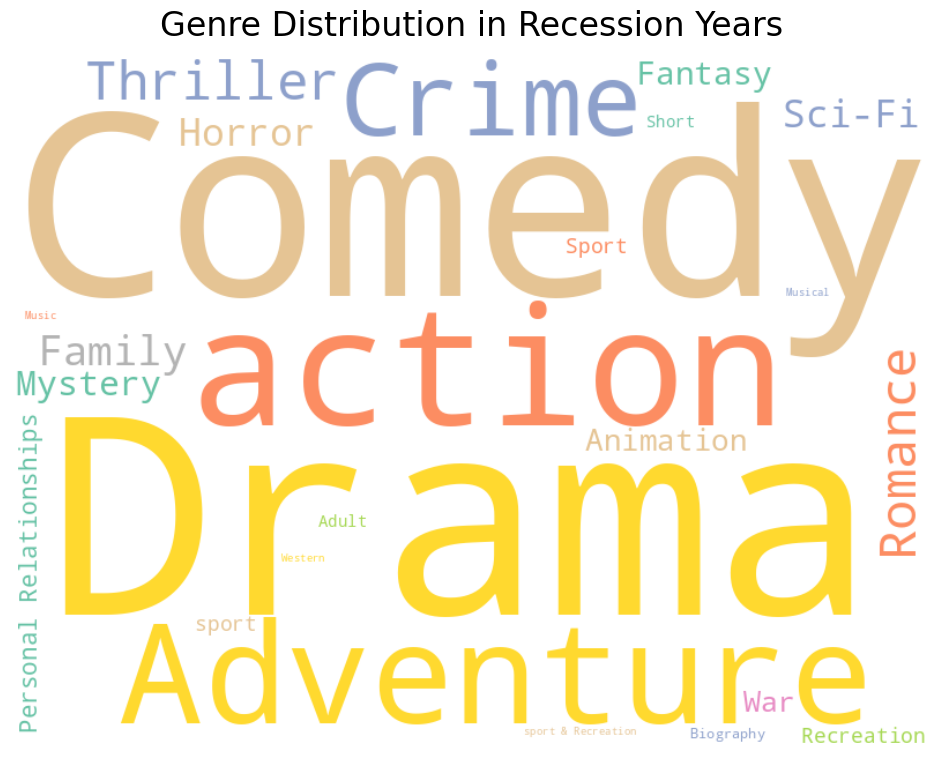

In [ ]:
#Create Word Cloud for Recession Years

#Build Dictionary for wordcloud 
genre_dict = dict(zip(genre_counts_recession['genres'], genre_counts_recession['count']))

wordcloud = WordCloud(background_color='white', colormap='Set2', width=800, height=600).generate_from_frequencies(genre_dict)

# plot the word cloud
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Genre Distribution in Recession Years')

ax = plt.gca() # define an ax object using plt.gca()
ax.set_title('Genre Distribution in Recession Years', y=1.02, fontsize=24)
plt.axis('off')
plt.savefig('wordcloudRecession.png', dpi=300)
plt.show()

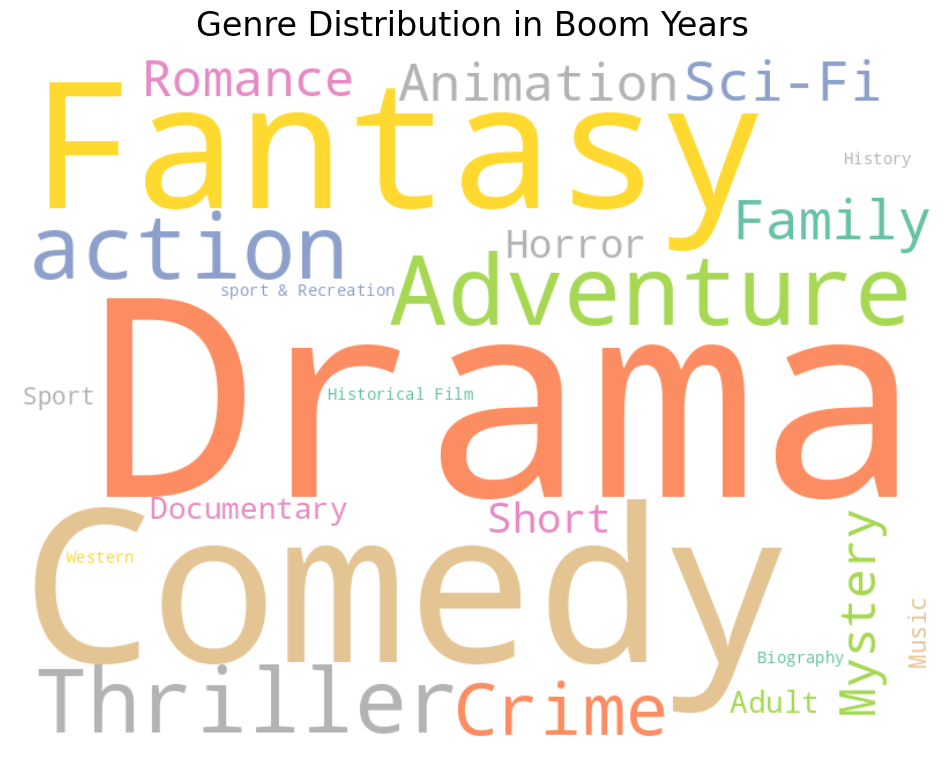

In [ ]:
#Create Word Cloud for Boom Years

#Build Dictionary for wordcloud 
genre_dict = dict(zip(genre_counts_boom['genres'], genre_counts_boom['count']))

wordcloud = WordCloud(background_color='white', colormap='Set2', width=800, height=600).generate_from_frequencies(genre_dict)

# plot the word cloud
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Genre Distribution in Boom Years')

ax = plt.gca() # define an ax object using plt.gca()
ax.set_title('Genre Distribution in Boom Years', y=1.02, fontsize=24)
plt.axis('off')
plt.savefig('wordcloudBoom.png', dpi=300)
plt.show()

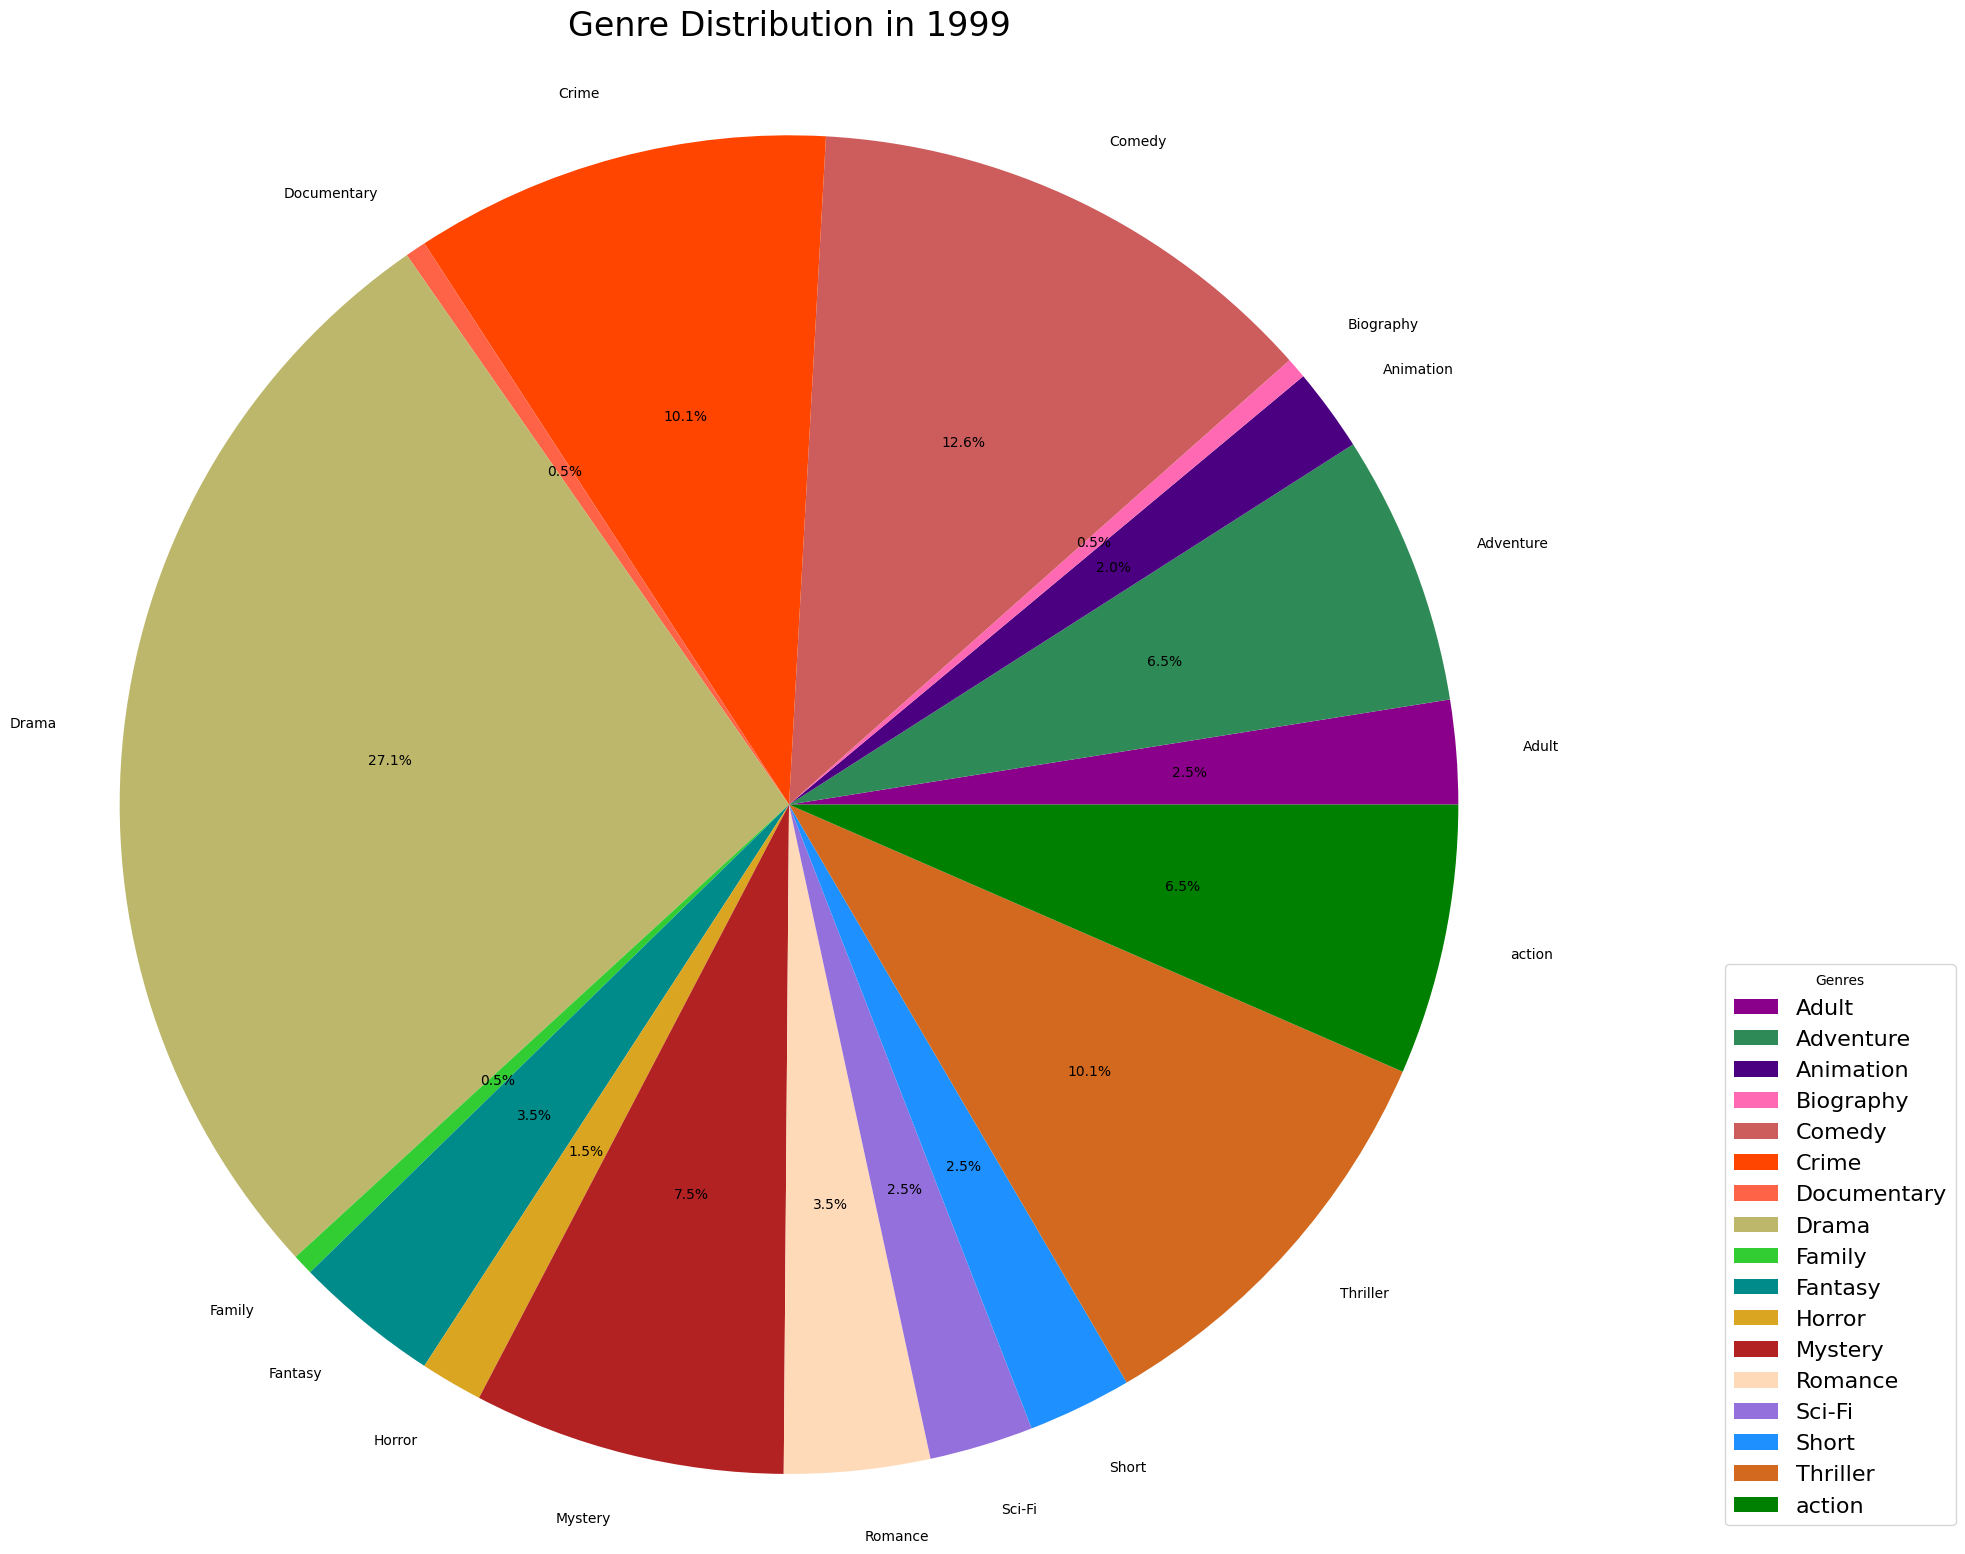

In [ ]:
#Create Pie Charts to Represent Boom Year 1999

#create a library of 38 colors to represent the 38 potential genres
colors = [
'#8B008B', # Adult
'#2E8B57', # Adventure
'#4B0082', # Animation
'#FF69B4', # Biography
'#CD5C5C', # Comedy
'#FF4500', # Crime
'#FF6347', # Documentary
'#BDB76B', # Drama
'#32CD32', # Family
'#008B8B', # Fantasy
'#DAA520', # Horror
'#B22222', # Mystery
'#FFDAB9', # Romance
'#9370DB', # Sci-Fi
'#1E90FF', # Short
'#D2691E',  # Thriller
'#008000' #Action
]

#Set figure size
fig, ax = plt.subplots(figsize=(19, 19))

#Create pie chart 
plt.pie(genre_counts_1999['count'], labels=genre_counts_1999['genres'], autopct='%1.1f%%', colors=colors)

#add labels 
plt.axis('equal')
ax.legend(title='Genres', loc='lower right', bbox_to_anchor=(1.30, 0), fontsize=16)
plt.title('Genre Distribution in 1999')
ax.set_title('Genre Distribution in 1999', y=1.02, fontsize=24)

#Save and show pie chart 
plt.savefig('piechart1999.png', dpi=300)


plt.show()

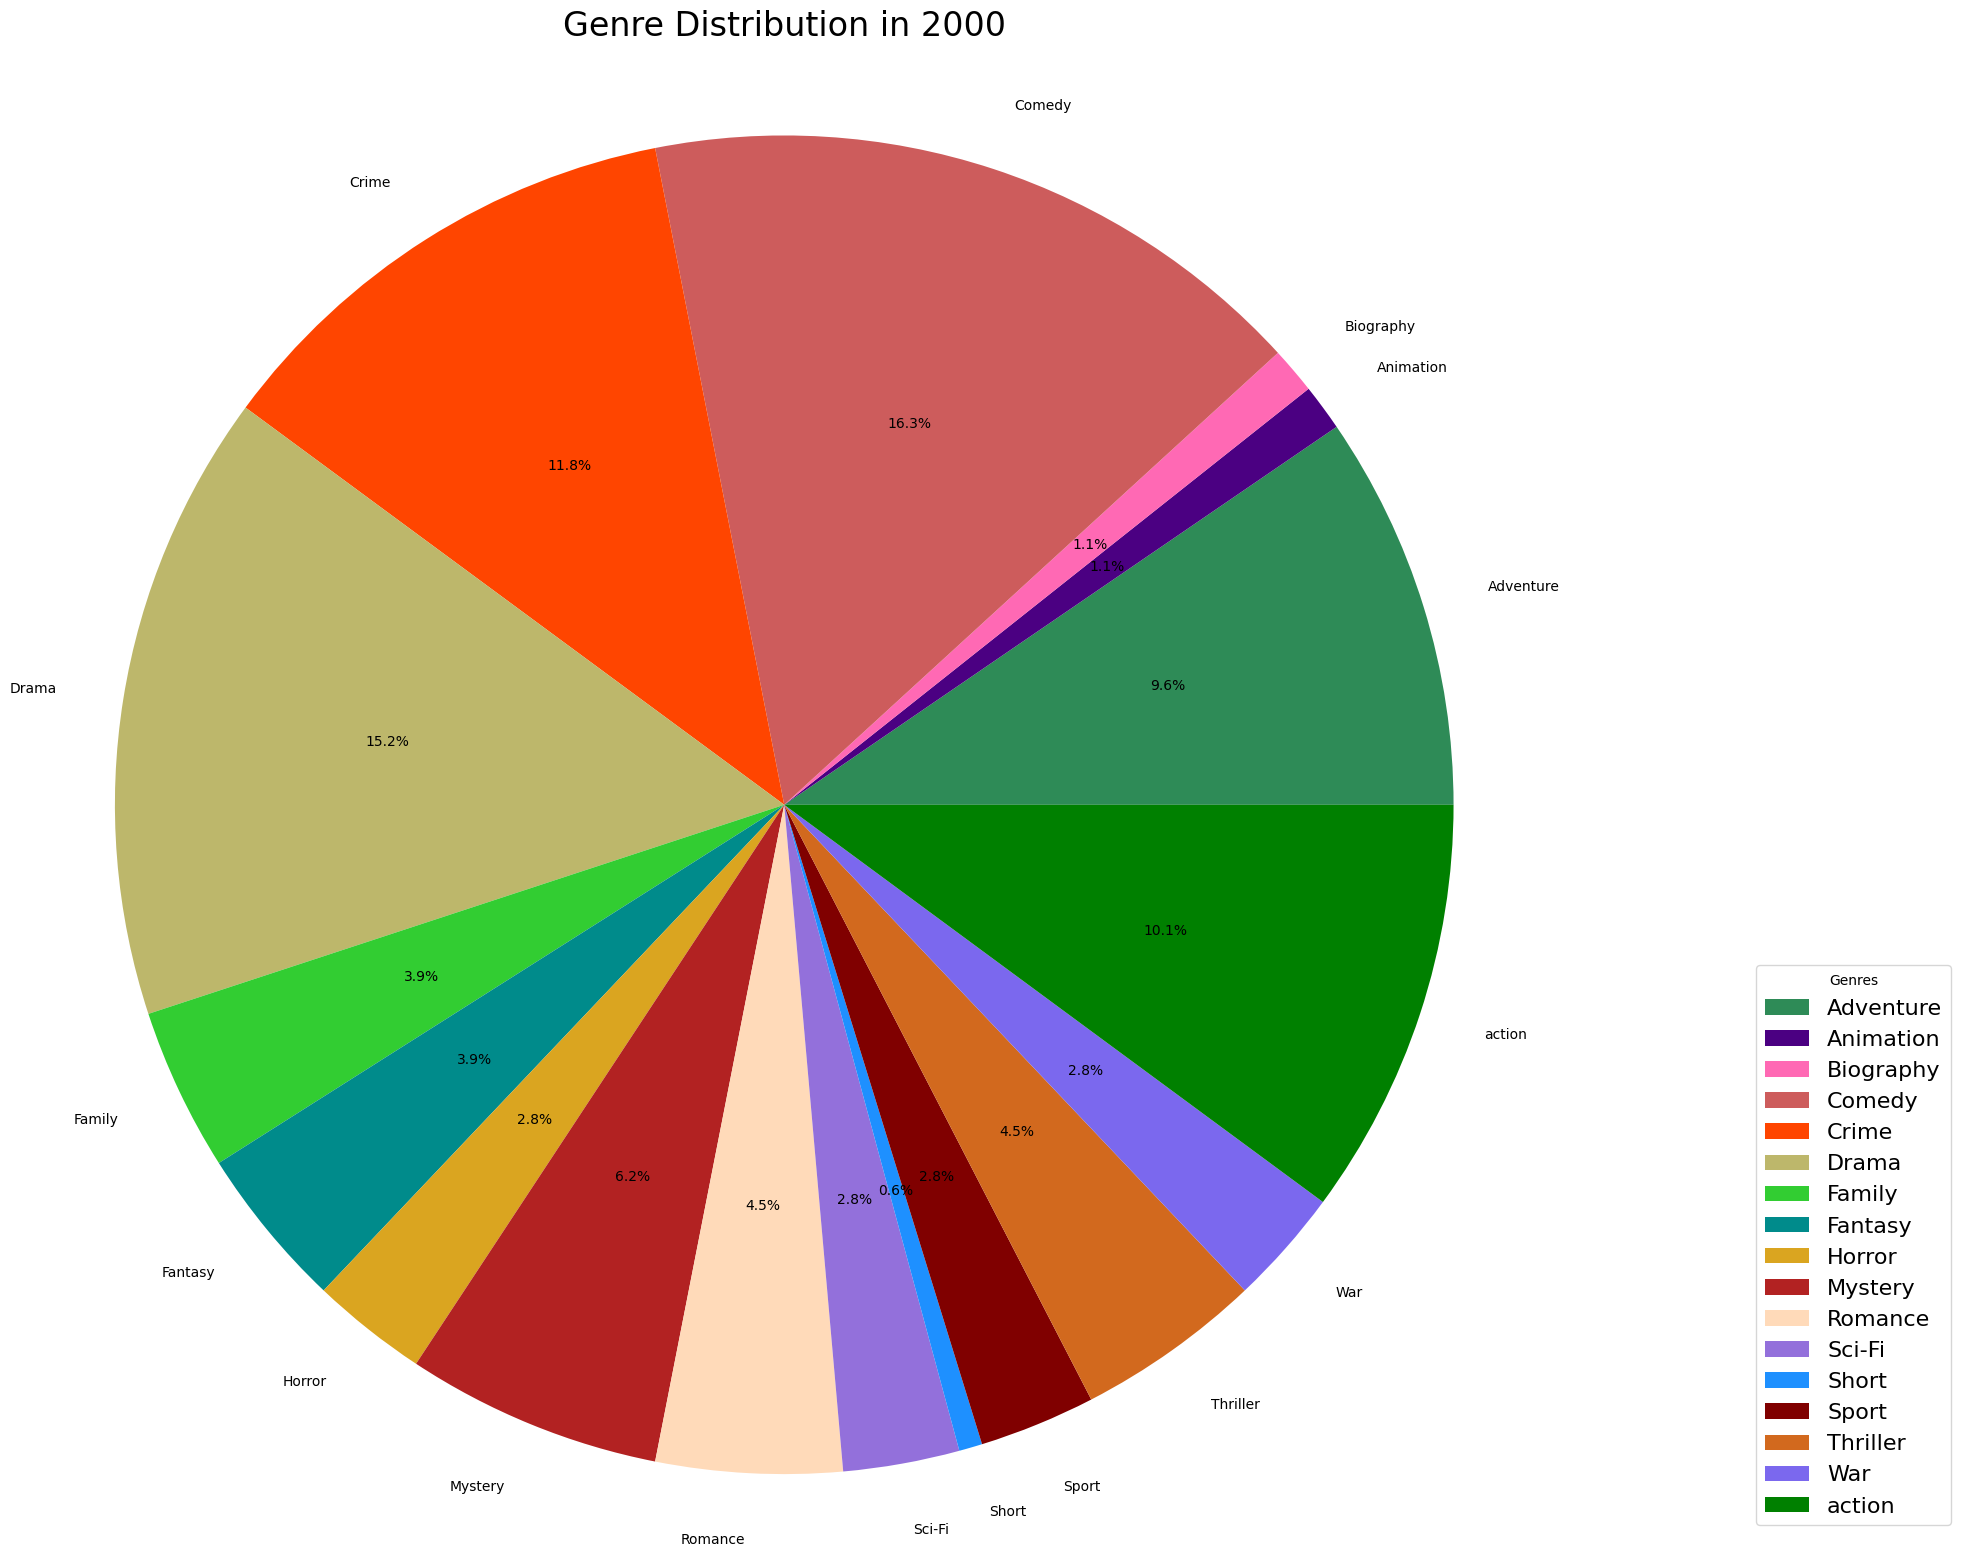

In [ ]:
#Create Pie Charts to Represent Recession Year 2000

#create a library of 38 colors to represent the 38 potential genres
colors = [
'#2E8B57', # Adventure
'#4B0082', # Animation
'#FF69B4', # Biography
'#CD5C5C', # Comedy
'#FF4500', # Crime
'#BDB76B', # Drama
'#32CD32', # Family
'#008B8B', # Fantasy
'#DAA520', # Horror
'#B22222', # Mystery
'#FFDAB9', # Romance
'#9370DB', # Sci-Fi
'#1E90FF', # Short
'#800000', # Sport
'#D2691E', # Thriller
'#7B68EE',  # War
'#008000' #Action

]
#Set figure size
fig, ax = plt.subplots(figsize=(19, 19))

#Create pie chart 
plt.pie(genre_counts_2000['count'], labels=genre_counts_2000['genres'], autopct='%1.1f%%', colors=colors)

#add labels 
plt.axis('equal')
ax.legend(title='Genres', loc='lower right', bbox_to_anchor=(1.30, 0), fontsize=16)
plt.title('Genre Distribution in 2000')
ax.set_title('Genre Distribution in 2000', y=1.02, fontsize=24)

#Save and show pie chart 
plt.savefig('piechart2000.png', dpi=300)


plt.show()


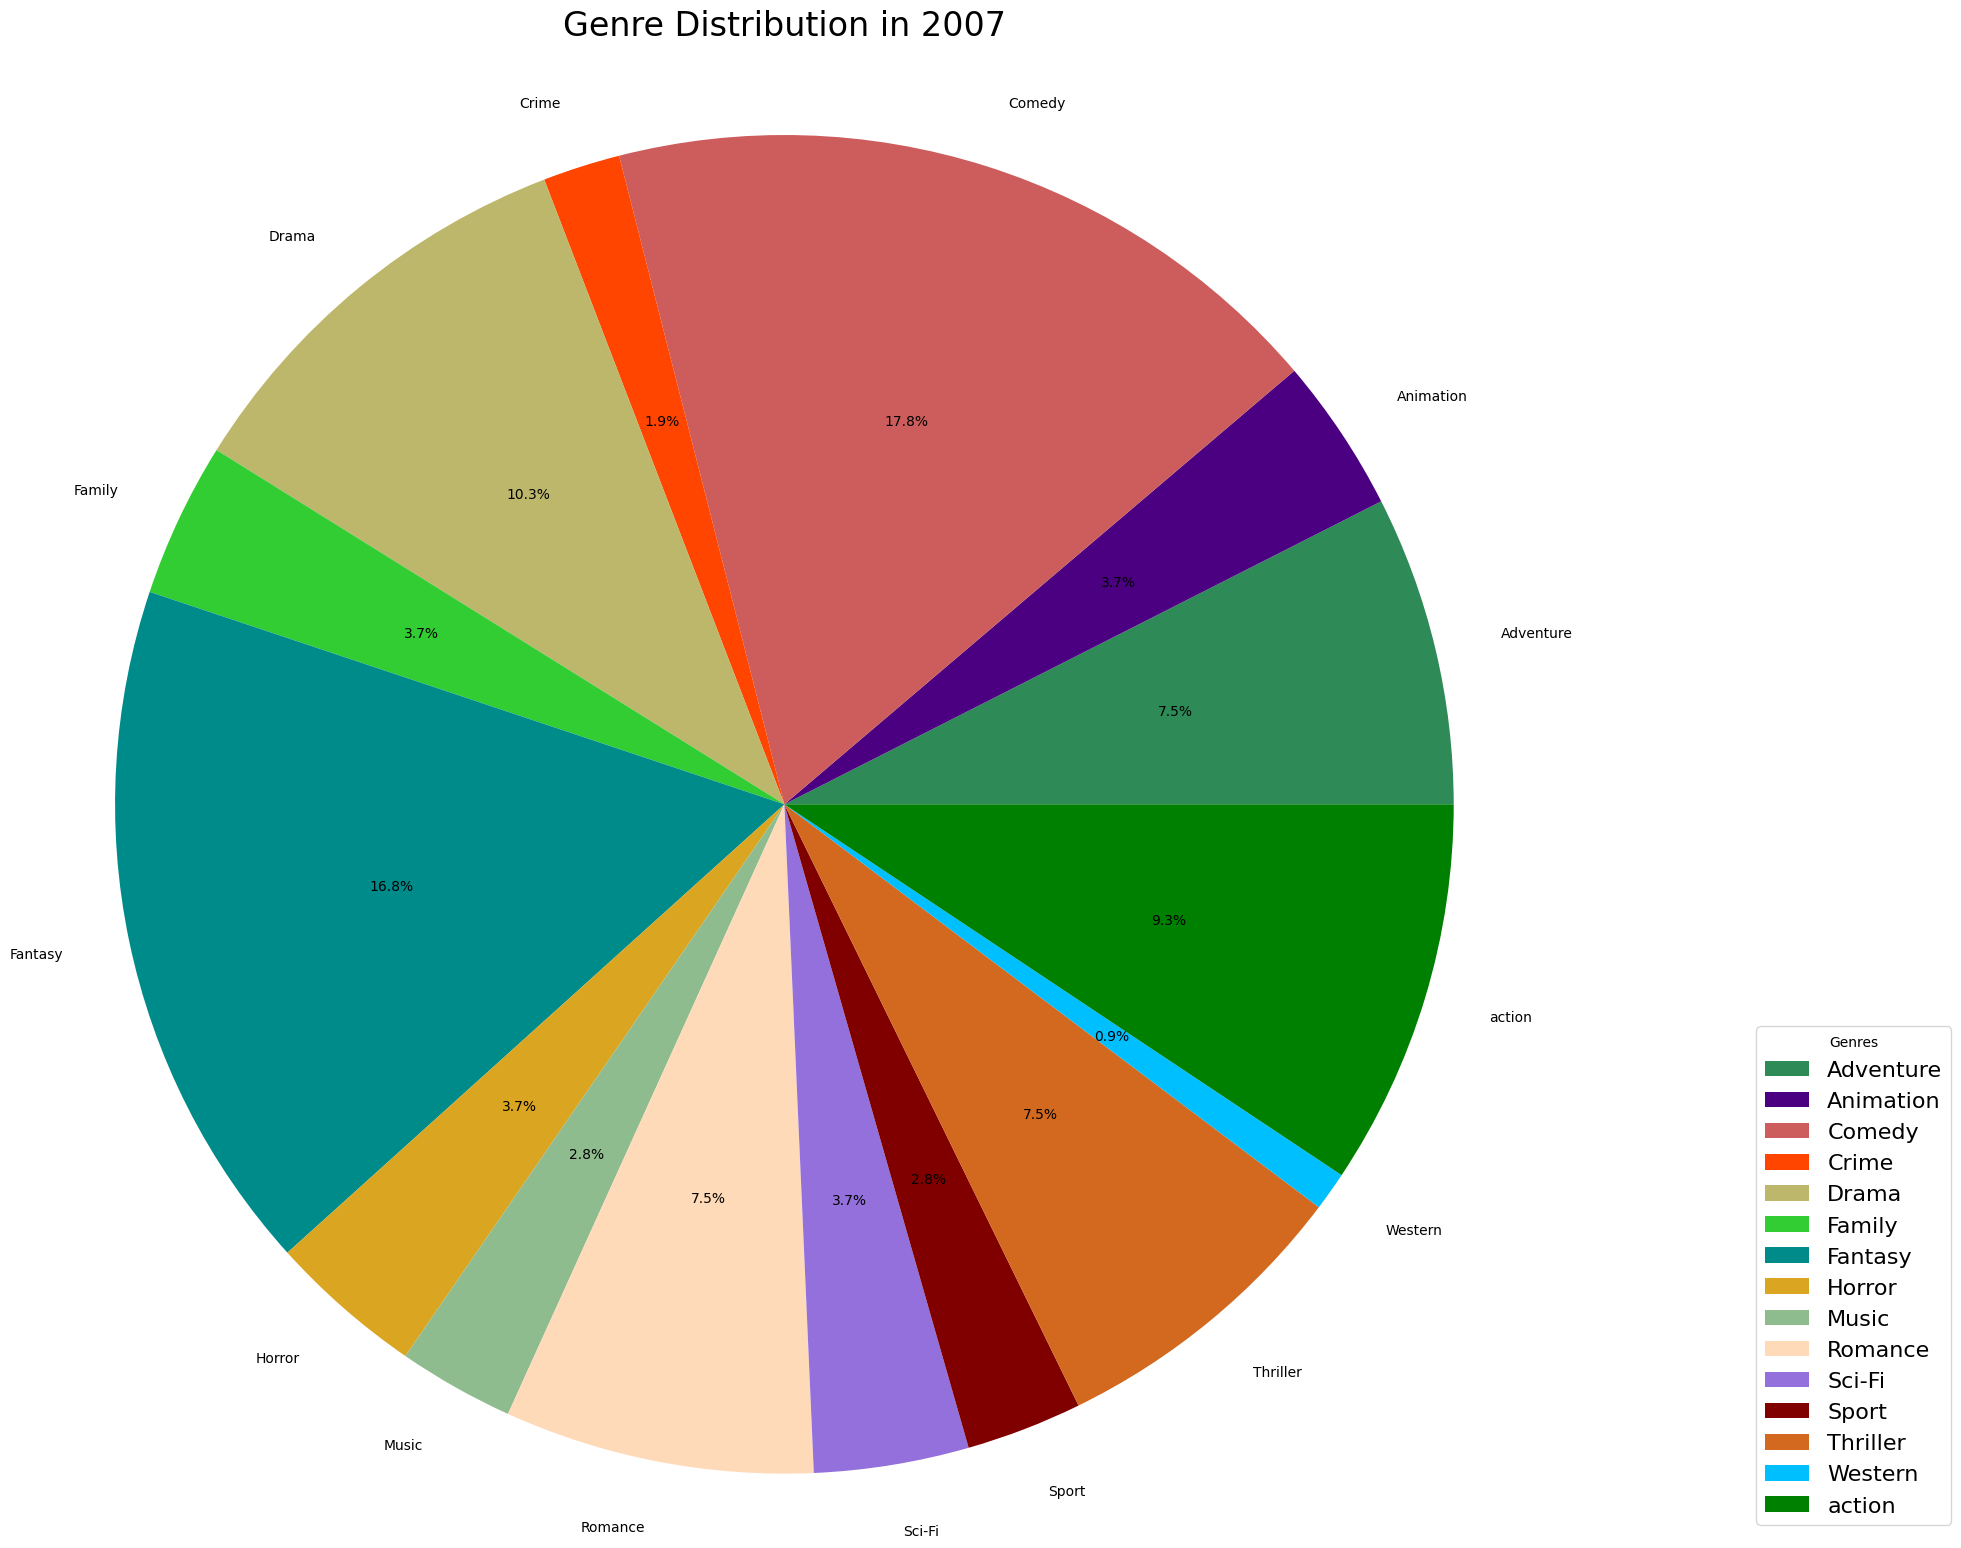

In [ ]:
#Create Pie Charts to Represent Boom Year 2007

#create a library of 38 colors to represent the 38 potential genres
colors = [
'#2E8B57', # Adventure
'#4B0082', # Animation
'#CD5C5C', # Comedy
'#FF4500', # Crime
'#BDB76B', # Drama
'#32CD32', # Family
'#008B8B', # Fantasy
'#DAA520', # Horror
'#8FBC8F', # Music
'#FFDAB9', # Romance
'#9370DB', # Sci-Fi
'#800000', # Sport
'#D2691E', # Thriller
'#00BFFF', # Western
'#008000'  # Action
]

#Set figure size
fig, ax = plt.subplots(figsize=(19, 19))

#Create pie chart 
plt.pie(genre_counts_2007['count'], labels=genre_counts_2007['genres'], autopct='%1.1f%%', colors=colors)

#add labels 
plt.axis('equal')
ax.legend(title='Genres', loc='lower right', bbox_to_anchor=(1.30, 0), fontsize=16)
plt.title('Genre Distribution in 2007')
ax.set_title('Genre Distribution in 2007', y=1.02, fontsize=24)

#Save and show pie chart 
plt.savefig('piechart2007.png', dpi=300)


plt.show()

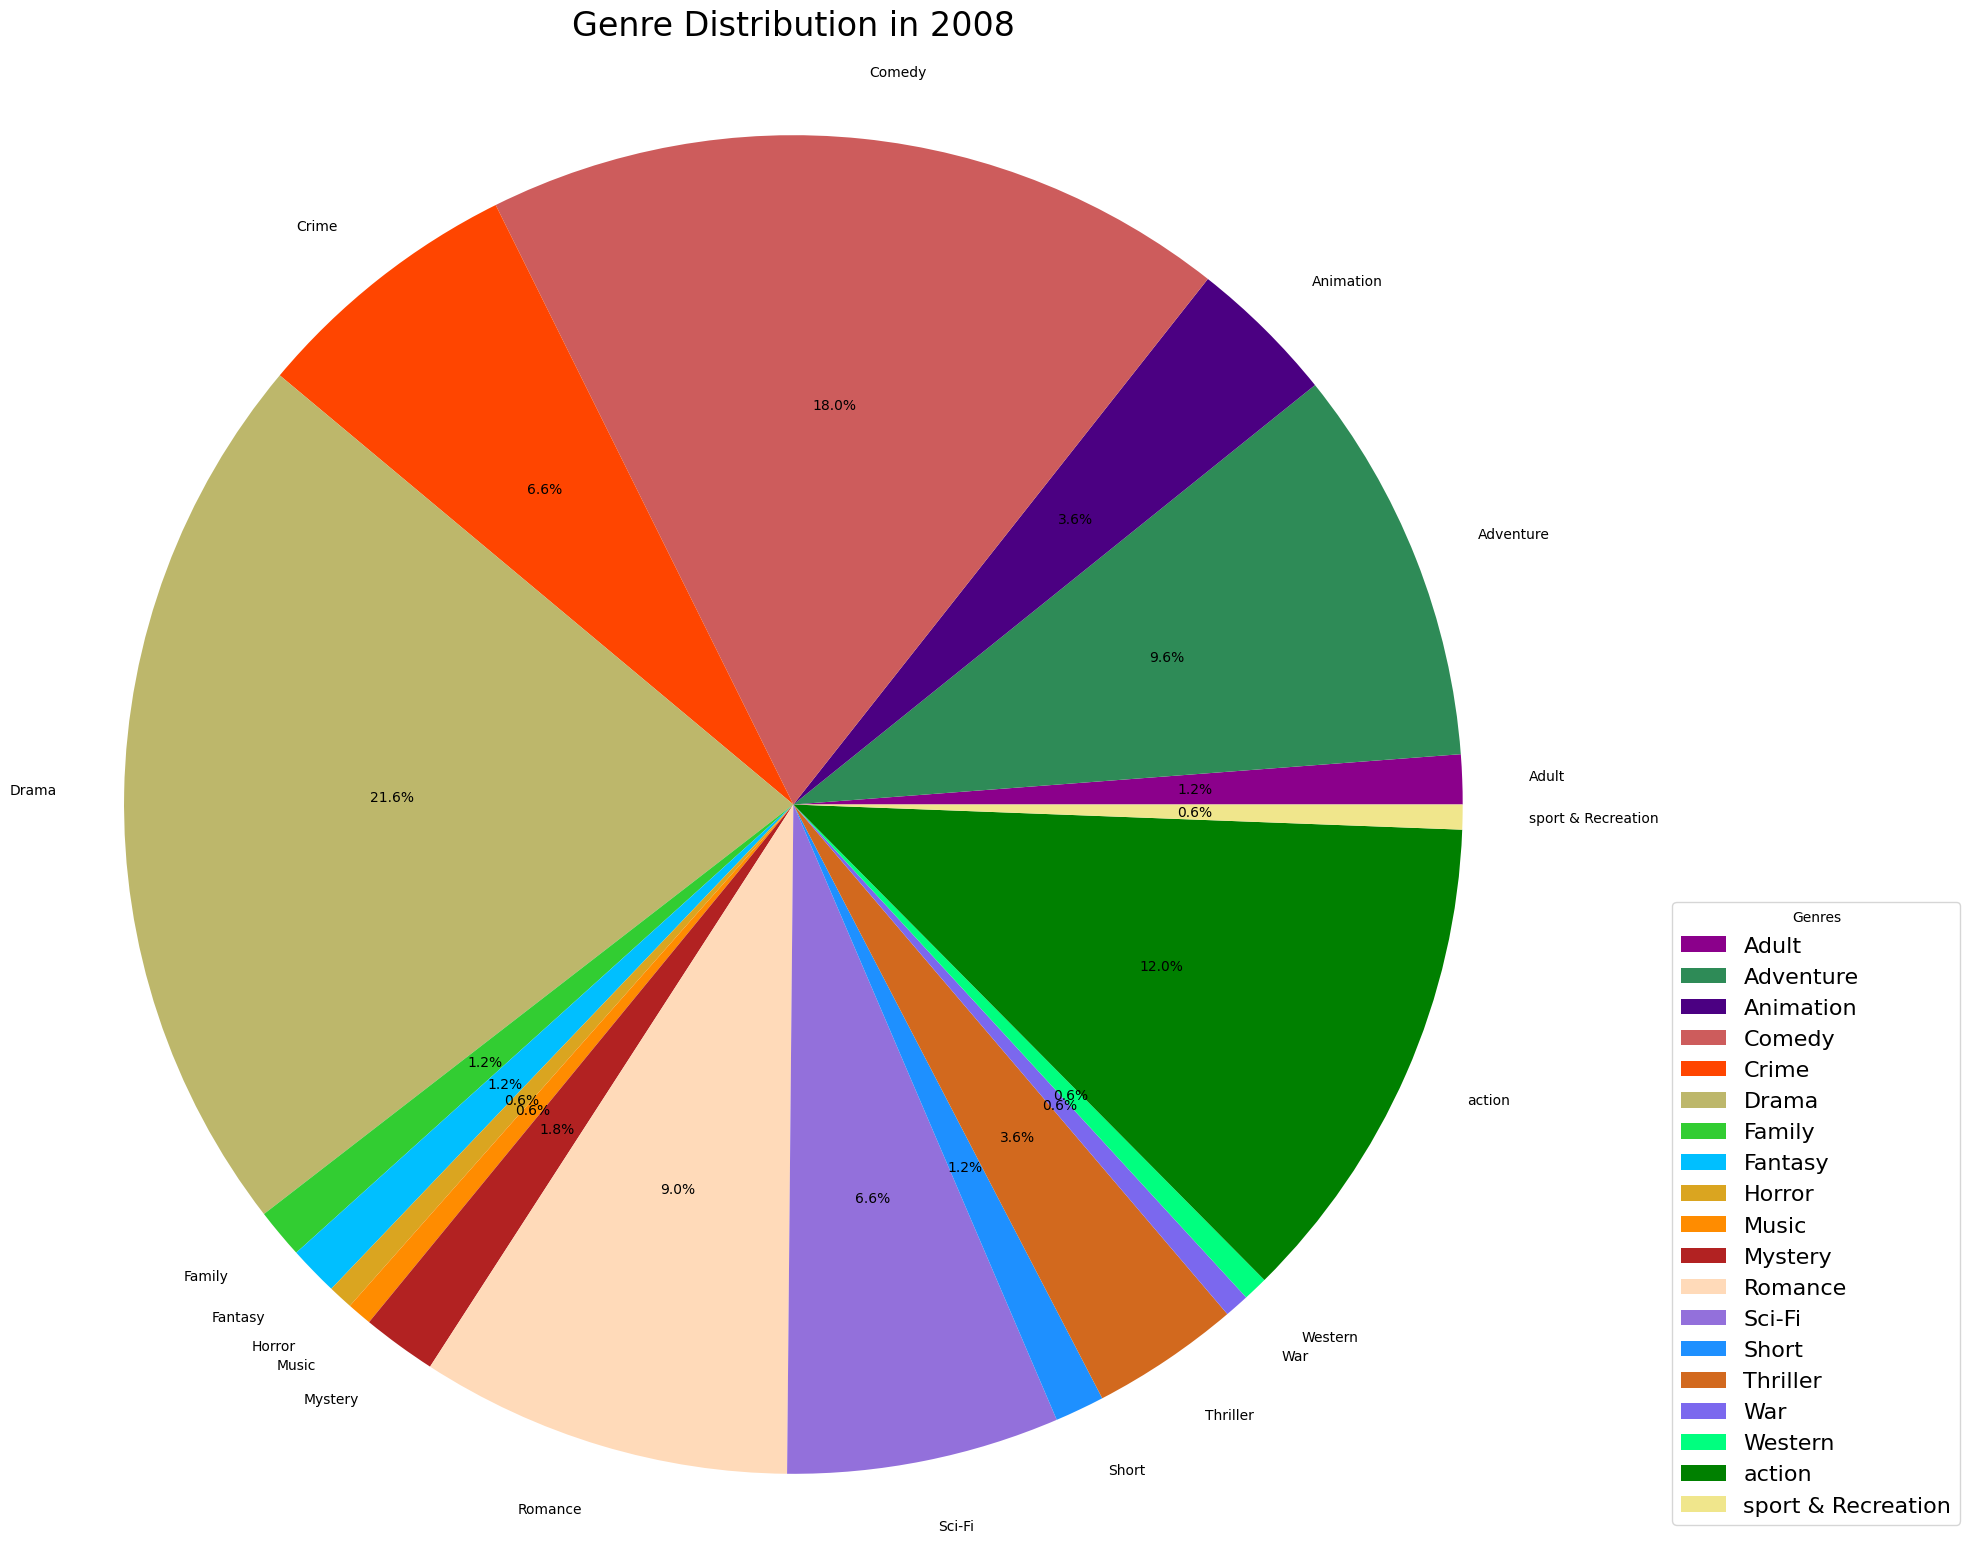

In [ ]:
#Create Pie Charts to Represent Recession Year 2008

#create a library of 38 colors to represent the 38 potential genres
colors = [
'#8B008B', # Adult
'#2E8B57', # Adventure
'#4B0082', # Animation
'#CD5C5C', # Comedy
'#FF4500', # Crime
'#BDB76B', # Drama
'#32CD32', # Family
'#00BFFF', # Fantasy
'#DAA520', # Horror
'#FF8C00', # Music
'#B22222', # Mystery
'#FFDAB9', # Romance
'#9370DB', # Sci-Fi
'#1E90FF', # Short
'#D2691E', # Thriller
'#7B68EE', # War
'#00FF7F', # Western
'#008000', # Action
'#F0E68C'  # Sport & Recreation
]

#Set figure size
fig, ax = plt.subplots(figsize=(19, 19))

#Create pie chart 
plt.pie(genre_counts_2008['count'], labels=genre_counts_2008['genres'], autopct='%1.1f%%', colors=colors)

#add labels 
plt.axis('equal')
ax.legend(title='Genres', loc='lower right', bbox_to_anchor=(1.30, 0), fontsize=16)
plt.title('Genre Distribution in 2008')
ax.set_title('Genre Distribution in 2008', y=1.02, fontsize=24)

#Save and show pie chart 
plt.savefig('piechart2008.png', dpi=300)


plt.show()

# **Now We Run the Model For Genre Prediction**

In [ ]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#define runtime device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.0.0+cu118
cuda:0


In [ ]:
#reestablish datasets for model based on earlier cleaning
dataset1_df = pd.read_csv('Genre_Train_Csv.csv')
dataset2_df = pd.read_csv('data_probablity_of_Success_train.csv')

In [ ]:
dataset2_df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Runtime', 'Special Day', 'family',
       'Unnamed: 11', 'Mystery', 'action', 'romantic', 'War', 'Sci-Fi',
       'Superhero', 'romance', 'crime', 'Spirituality & Philosophy',
       'Neo-Noir', 'Documentary', 'Animation', 'Game-Show', 'Drama',
       'Culture & Society', 'Thriller', 'Western', 'Slasher', 'Spy Film',
       'History', 'sports & Recreation', 'Music', 'Horror', 'Historical Film',
       'Action', 'Biography', 'Crime', 'sports', 'Abominable', 'Recreation',
       'Romance', 'Film-Noir', 'Musical', 'Fantasy', 'Comedy', 'Spy',
       'Adventure', 'Short', 'horror', 'Family & family', 'Family', 'Adult',
       'Science & Technology', 'Teen', 'sci-fi', 'y'],
      dtype='object')

In [ ]:
dataset1_df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'Musical',
       'Superhero', 'Historical Film', 'Society', 'Documentary', 'Sport',
       'Music', 'Biography', 'War', 'Comedy', 'Recreation', 'Game-Show',
       'Mystery', 'Adventure', 'Adult', 'Neo-Noir', 'Philosophy', 'Science',
       'History', 'Thriller', 'Western', 'Crime', 'Horror', 'Drama', 'Sci-Fi',
       'Film-Noir', 'Technology', 'Family', 'Animation', 'Spy Film', 'sport',
       'Personal Relationships', 'Culture', 'Romance', 'Fantasy', 'Short',
       'action', 'Spirituality'],
      dtype='object')

In [ ]:
#Drop unnecessary rows
dataset1_df = dataset1_df.drop(columns=['Unnamed: 0'])
dataset2_df = dataset2_df.drop(columns=['Unnamed: 0', 'Unnamed: 11'])
dataset2_df = dataset2_df[~dataset2_df.eq('TBD').any(1)].reset_index(drop=True)
dataset3_df = dataset2_df.drop(['Return', 'GDP Change','Unemployment_Rate'], axis=1)

<ipython-input-256-f23ebd971e98>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  dataset2_df = dataset2_df[~dataset2_df.eq('TBD').any(1)].reset_index(drop=True)


In [ ]:
#Define dimensions for input and output in pytorch version of NN model 
in_dim1 = 8
out_dim1 = 37

in_dim2 = 55
out_dim2 = 2

in_dim3 = 52
out_dim3 = 2

In [ ]:
#Change datatype 
dataset1 = dataset1_df.values.astype('float32')
dataset1 = torch.tensor(dataset1, dtype=torch.float32)

dataset2 = dataset2_df.values.astype('float32')
dataset2 = torch.tensor(dataset2, dtype=torch.float32)

dataset3 = dataset3_df.values.astype('float32')
dataset3 = torch.tensor(dataset3, dtype=torch.float32)


In [ ]:
#Define targets and features for models
targets1_df = dataset1_df[['Musical',
       'Superhero', 'Historical Film', 'Society', 'Documentary', 'Sport',
       'Music', 'Biography', 'War', 'Comedy', 'Recreation', 'Game-Show',
       'Mystery', 'Adventure', 'Adult', 'Neo-Noir', 'Philosophy', 'Science',
       'History', 'Thriller', 'Western', 'Crime', 'Horror', 'Drama', 'Sci-Fi',
       'Film-Noir', 'Technology', 'Family', 'Animation', 'Spy Film', 'sport',
       'Personal Relationships', 'Culture', 'Romance', 'Fantasy', 'Short',
       'action', 'Spirituality']]

features1_df = dataset1_df[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day']]

targets2_df = dataset2_df[['y']]

features2_df = dataset2_df[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Runtime', 'Special Day', 'family',
       'Mystery', 'action', 'romantic', 'War', 'Sci-Fi', 'Superhero',
       'romance', 'crime', 'Spirituality & Philosophy', 'Neo-Noir',
       'Documentary', 'Animation', 'Game-Show', 'Drama', 'Culture & Society',
       'Thriller', 'Western', 'Slasher', 'Spy Film', 'History',
       'sports & Recreation', 'Music', 'Horror', 'Historical Film', 'Action',
       'Biography', 'Crime', 'sports', 'Abominable', 'Recreation', 'Romance',
       'Film-Noir', 'Musical', 'Fantasy', 'Comedy', 'Spy', 'Adventure',
       'Short', 'horror', 'Family & family', 'Family', 'Adult',
       'Science & Technology', 'Teen', 'sci-fi']]

targets3_df = dataset3_df[['y']]

features3_df = dataset3_df[['Year', 'Month', 'Week Number', 'num_releases', 'Runtime', 'Special Day', 'family',
       'Mystery', 'action', 'romantic', 'War', 'Sci-Fi', 'Superhero',
       'romance', 'crime', 'Spirituality & Philosophy', 'Neo-Noir',
       'Documentary', 'Animation', 'Game-Show', 'Drama', 'Culture & Society',
       'Thriller', 'Western', 'Slasher', 'Spy Film', 'History',
       'sports & Recreation', 'Music', 'Horror', 'Historical Film', 'Action',
       'Biography', 'Crime', 'sports', 'Abominable', 'Recreation', 'Romance',
       'Film-Noir', 'Musical', 'Fantasy', 'Comedy', 'Spy', 'Adventure',
       'Short', 'horror', 'Family & family', 'Family', 'Adult',
       'Science & Technology', 'Teen', 'sci-fi']]

In [ ]:
#Split the training and test subsets of the Dataset
seed = 42

X_train1_df, X_test1_df, y_train1_df, y_test1_df = train_test_split(features1_df, targets1_df, train_size=0.9, random_state=seed)

X_train1 = torch.tensor(X_train1_df.values, dtype=torch.float32)
X_test1 = torch.tensor(X_test1_df.values, dtype=torch.float32)
y_train1 = torch.tensor(y_train1_df.values, dtype=torch.float32)
y_test1 = torch.tensor(y_test1_df.values, dtype=torch.float32)


X_train2_df, X_test2_df, y_train2_df, y_test2_df = train_test_split(features2_df, targets2_df, train_size=0.9, random_state=seed)
X_train2_df = X_train2_df.values.astype('float32')
X_test2_df = X_test2_df.values.astype('float32')
y_train2_df = y_train2_df.values.astype('float32').ravel()
y_test2_df = y_test2_df.values.astype('float32').ravel()

X_train3_df, X_test3_df, y_train3_df, y_test3_df = train_test_split(features3_df, targets3_df, train_size=0.9, random_state=seed)
X_train3_df = X_train3_df.values.astype('float32')
X_test3_df = X_test3_df.values.astype('float32')
y_train3_df = y_train3_df.values.astype('float32').ravel()
y_test3_df = y_test3_df.values.astype('float32').ravel()


#################################################################
#Build dataset and dataloader for pytorch version of NN model 

X_train2 = torch.tensor(X_train2_df, dtype=torch.float32)
X_test2 = torch.tensor(X_test2_df, dtype=torch.float32)
y_train2 = torch.tensor(y_train2_df, dtype=torch.float32)
y_test2 = torch.tensor(y_test2_df, dtype=torch.float32)

X_train3 = torch.tensor(X_train3_df, dtype=torch.float32)
X_test3 = torch.tensor(X_test3_df, dtype=torch.float32)
y_train3 = torch.tensor(y_train3_df, dtype=torch.float32)
y_test3 = torch.tensor(y_test3_df, dtype=torch.float32)

dataset_1 = TensorDataset(dataset1[:, 0:8], dataset1[:, 8:-1])
dataset_2 = TensorDataset(dataset2[:, 0:55], dataset2[:, 55:56])
dataset_3 = TensorDataset(dataset3[:, 0:52], dataset2[:, 52:53])

n_samples_1 = len(dataset_1)
n_train_1 = int(0.9 * n_samples_1)
n_test_1 = n_samples_1 - n_train_1
trainset_1, testset_1 = random_split(dataset_1, [n_train_1, n_test_1])

n_samples_2 = len(dataset_2)
n_train_2 = int(0.9 * n_samples_2)
n_test_2 = n_samples_2 - n_train_2
trainset_2, testset_2 = random_split(dataset_2, [n_train_2, n_test_2])

n_samples_3 = len(dataset_3)
n_train_3 = int(0.9 * n_samples_3)
n_test_3 = n_samples_3 - n_train_3
trainset_3, testset_3 = random_split(dataset_3, [n_train_3, n_test_3])

batch_size = 32
trainloader_1 = DataLoader(trainset_1, batch_size=batch_size, shuffle=True)
testloader_1 = DataLoader(testset_1, batch_size=X_train1.shape[0], shuffle=True)

trainloader_2 = DataLoader(dataset_2, batch_size=batch_size, shuffle=True)
testloader_2 = DataLoader(testset_2, batch_size=X_train2.shape[0], shuffle=True)

trainloader_3 = DataLoader(dataset_3, batch_size=batch_size, shuffle=True)
testloader_3 = DataLoader(testset_3, batch_size=X_train3.shape[0], shuffle=True)


In [ ]:
#inport necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


**Genre Success Prediction SKLearn Models**




In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features1_df, targets1_df, train_size=0.9, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

y_pred_train_lin = lin_reg.predict(X_train)
mse_train_lin = mean_squared_error(y_train, y_pred_train_lin)
r2_train_lin = r2_score(y_train, y_pred_train_lin)

print("Linear Regression:")
print("Training MSE:", mse_train_lin)
print("Testing MSE:", mse_lin)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training MSE:", mse_train_rf)
print("Testing MSE:", mse_rf)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training MSE:", mse_train_xgb)
print("Testing MSE:", mse_xgb)

# Neural Network
mlp = MLPRegressor(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
mse_train_mlp = mean_squared_error(y_train, y_pred_train_mlp)
r2_train_mlp = r2_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training MSE:", mse_train_mlp)
print("Testing MSE:", mse_mlp)



Linear Regression:
Training MSE: 0.046404064942707046
Testing MSE: 0.046275703188274175

Random Forest:
Training MSE: 0.011436296221786742
Testing MSE: 0.033685953984577584

XGBoost:
Training MSE: 0.01887972357566502
Testing MSE: 0.03415079271065826

Neural Network:
Training MSE: 0.08966520084133674
Testing MSE: 0.09267905281628326


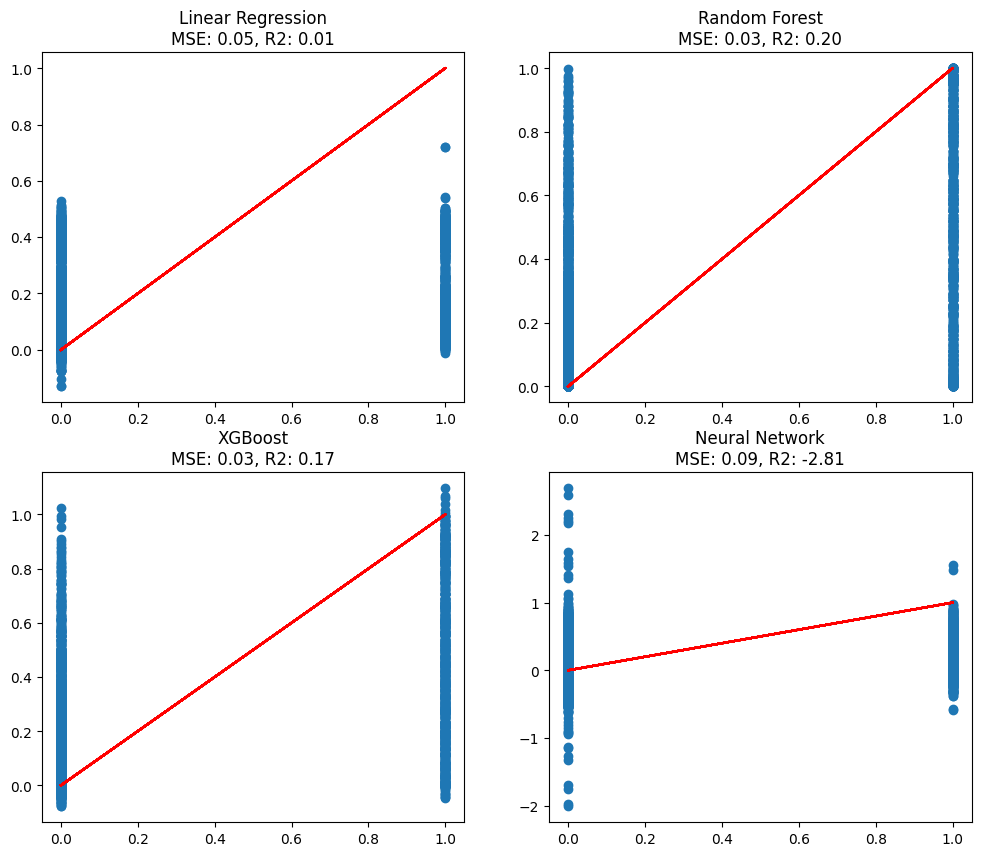

In [ ]:
#Plot the predicted vs actual values for each model
#Linear Regression
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(y_test, y_pred_lin)
axs[0, 0].plot(y_test, y_test, color='r')
axs[0, 0].set_title('Linear Regression\nMSE: {:.2f}, R2: {:.2f}'.format(mse_lin, r2_lin))

#Random Forest
axs[0, 1].scatter(y_test, y_pred_rf)
axs[0, 1].plot(y_test, y_test, color='r')
axs[0, 1].set_title('Random Forest\nMSE: {:.2f}, R2: {:.2f}'.format(mse_rf, r2_rf))

#XGBoost
axs[1, 0].scatter(y_test, y_pred_xgb)
axs[1, 0].plot(y_test, y_test, color='r')
axs[1, 0].set_title('XGBoost\nMSE: {:.2f}, R2: {:.2f}'.format(mse_xgb, r2_xgb))

#Neural Network
axs[1, 1].scatter(y_test, y_pred_mlp)
axs[1, 1].plot(y_test, y_test, color='r')
axs[1, 1].set_title('Neural Network\nMSE: {:.2f}, R2: {:.2f}'.format(mse_mlp, r2_mlp))

plt.show()



**Predict Movie Success as a Regression Problem:**

In [ ]:
#import clean datasets
dataset1_df = pd.read_csv('Genre_Train_Csv.csv')
dataset2_df = pd.read_csv('data_probablity_of_Success_train.csv')

In [ ]:
#Update datatype
features2_df['Runtime'] = features2_df['Runtime'].astype(float)

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features2_df, targets2_df, train_size=0.9, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

y_pred_train_lin = lin_reg.predict(X_train)
mse_train_lin = mean_squared_error(y_train, y_pred_train_lin)
r2_train_lin = r2_score(y_train, y_pred_train_lin)

print("Linear Regression:")
print("Training MSE:", mse_train_lin)
print("Testing MSE:", mse_lin)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training MSE:", mse_train_rf)
print("Testing MSE:", mse_rf)


# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training MSE:", mse_train_xgb)
print("Testing MSE:", mse_xgb)

# Neural Network
mlp = MLPRegressor(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
mse_train_mlp = mean_squared_error(y_train, y_pred_train_mlp)
r2_train_mlp = r2_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training MSE:", mse_train_mlp)
print("Testing MSE:", mse_mlp)

Linear Regression:
Training MSE: 0.11362414066337503
Testing MSE: 0.11884947975751446


<ipython-input-265-778e3eb3377e>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)



Random Forest:
Training MSE: 0.011937566902078527
Testing MSE: 0.060983406160823705

XGBoost:
Training MSE: 0.05896443814670758
Testing MSE: 0.07855031278844897


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training MSE: 0.6435003105126496
Testing MSE: 0.6501799713035752


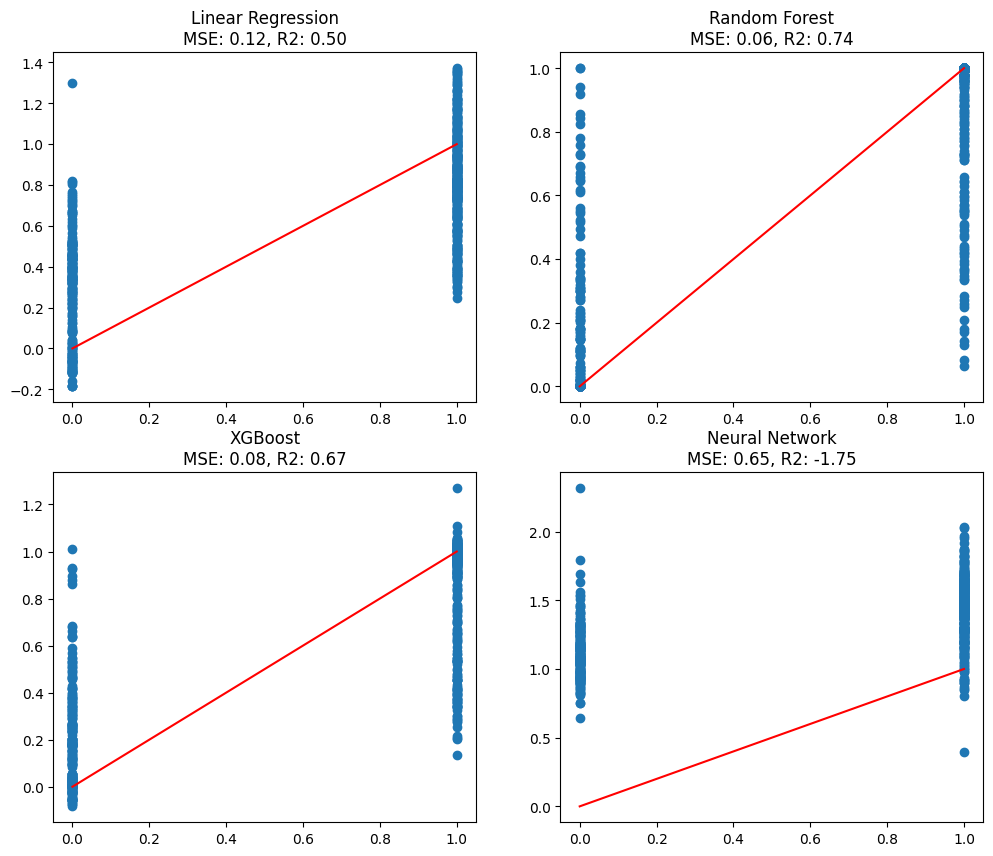

In [ ]:
#Plot the predicted vs actual values for each model
#Linear Regression
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(y_test, y_pred_lin)
axs[0, 0].plot(y_test, y_test, color='r')
axs[0, 0].set_title('Linear Regression\nMSE: {:.2f}, R2: {:.2f}'.format(mse_lin, r2_lin))

#Random Forest
axs[0, 1].scatter(y_test, y_pred_rf)
axs[0, 1].plot(y_test, y_test, color='r')
axs[0, 1].set_title('Random Forest\nMSE: {:.2f}, R2: {:.2f}'.format(mse_rf, r2_rf))

#XGBoost
axs[1, 0].scatter(y_test, y_pred_xgb)
axs[1, 0].plot(y_test, y_test, color='r')
axs[1, 0].set_title('XGBoost\nMSE: {:.2f}, R2: {:.2f}'.format(mse_xgb, r2_xgb))

#Neural Network
axs[1, 1].scatter(y_test, y_pred_mlp)
axs[1, 1].plot(y_test, y_test, color='r')
axs[1, 1].set_title('Neural Network\nMSE: {:.2f}, R2: {:.2f}'.format(mse_mlp, r2_mlp))

plt.show()

**Run Movie Success Regression Models without the Financial Features**

In [ ]:
# Split data into training and test sets
features3_df['Runtime'] = features3_df['Runtime'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(features3_df, targets3_df, train_size=0.9, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

y_pred_train_lin = lin_reg.predict(X_train)
mse_train_lin = mean_squared_error(y_train, y_pred_train_lin)
r2_train_lin = r2_score(y_train, y_pred_train_lin)

print("Linear Regression:")
print("Training MSE:", mse_train_lin)
print("Testing MSE:", mse_lin)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training MSE:", mse_train_rf)
print("Testing MSE:", mse_rf)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training MSE:", mse_train_xgb)
print("Testing MSE:", mse_xgb)

# Neural Network
mlp = MLPRegressor(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
mse_train_mlp = mean_squared_error(y_train, y_pred_train_mlp)
r2_train_mlp = r2_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training MSE:", mse_train_mlp)
print("Testing MSE:", mse_mlp)

<ipython-input-185-df3429385d4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features3_df['Runtime'] = features3_df['Runtime'].astype(float)
<ipython-input-185-df3429385d4e>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Linear Regression:
Training MSE: 0.1136519299177407
Testing MSE: 0.11893053146830415

Random Forest:
Training MSE: 0.011840631203285974
Testing MSE: 0.05976994462639169

XGBoost:
Training MSE: 0.06179179786092416
Testing MSE: 0.07939956625016655


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training MSE: 3.887042930956092
Testing MSE: 3.852782657215124


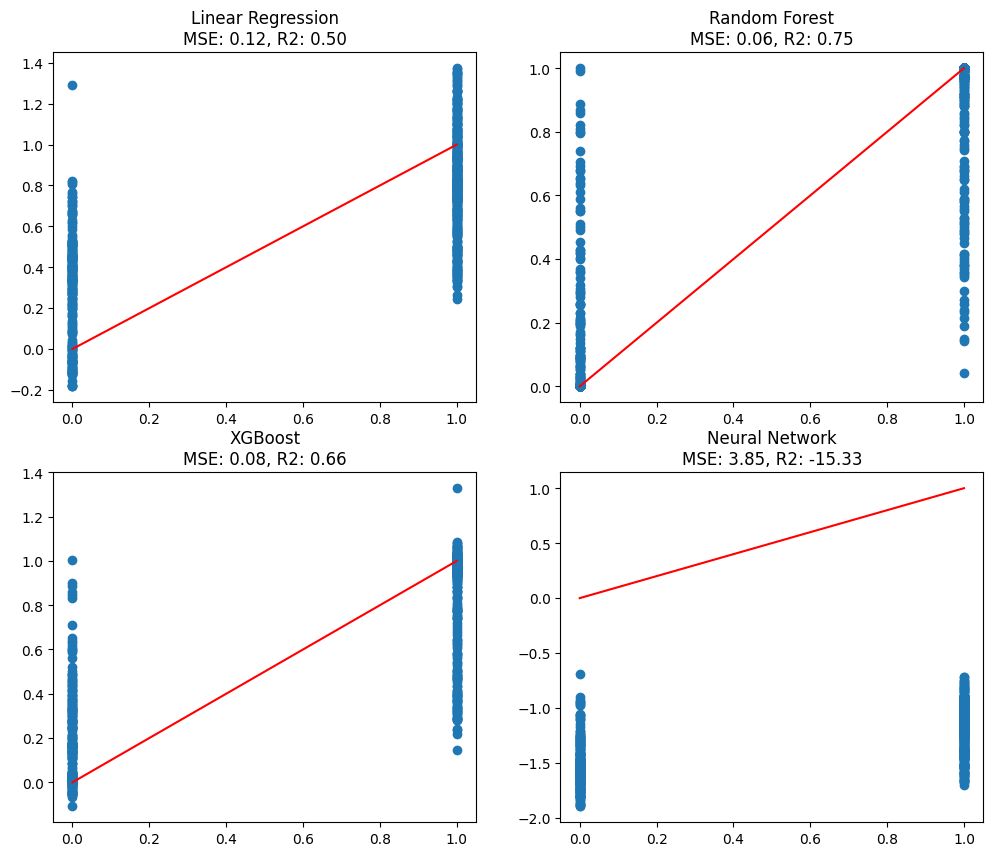

In [ ]:
#Plot the predicted vs actual values for each model
#Linear Regression
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(y_test, y_pred_lin)
axs[0, 0].plot(y_test, y_test, color='r')
axs[0, 0].set_title('Linear Regression\nMSE: {:.2f}, R2: {:.2f}'.format(mse_lin, r2_lin))

#Random Forest
axs[0, 1].scatter(y_test, y_pred_rf)
axs[0, 1].plot(y_test, y_test, color='r')
axs[0, 1].set_title('Random Forest\nMSE: {:.2f}, R2: {:.2f}'.format(mse_rf, r2_rf))

#XGBoost
axs[1, 0].scatter(y_test, y_pred_xgb)
axs[1, 0].plot(y_test, y_test, color='r')
axs[1, 0].set_title('XGBoost\nMSE: {:.2f}, R2: {:.2f}'.format(mse_xgb, r2_xgb))

#Neural Network
axs[1, 1].scatter(y_test, y_pred_mlp)
axs[1, 1].plot(y_test, y_test, color='r')
axs[1, 1].set_title('Neural Network\nMSE: {:.2f}, R2: {:.2f}'.format(mse_mlp, r2_mlp))

plt.show()

**Predict Whether a Movie will Succeed Using Binary Classification SKLearn Models instead of Regression**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:

features2_df['Runtime'] = features2_df['Runtime'].astype(float)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features2_df, targets2_df, train_size=0.9, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

y_pred_train_log = log_reg.predict(X_train)
acc_train_log = accuracy_score(y_train, y_pred_train_log)

print("Logistic Regression:")
print("Training accuracy:", acc_train_log)
print("Testing accuracy:", acc_log)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
acc_train_rf = accuracy_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training accuracy:", acc_train_rf)
print("Testing accuracy:", acc_rf)

# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training accuracy:", acc_train_xgb)
print("Testing accuracy:", acc_xgb)

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
acc_train_mlp = accuracy_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training accuracy:", acc_train_mlp)
print("Testing accuracy:", acc_mlp)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-199-adc7d7d26d36>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Logistic Regression:
Training accuracy: 0.8141099577085736
Testing accuracy: 0.8048359240069085

Random Forest:
Training accuracy: 0.9911572472126106
Testing accuracy: 0.9101899827288429

XGBoost:
Training accuracy: 0.9231064975009612
Testing accuracy: 0.8791018998272885


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training accuracy: 0.8116109188773548
Testing accuracy: 0.8100172711571675


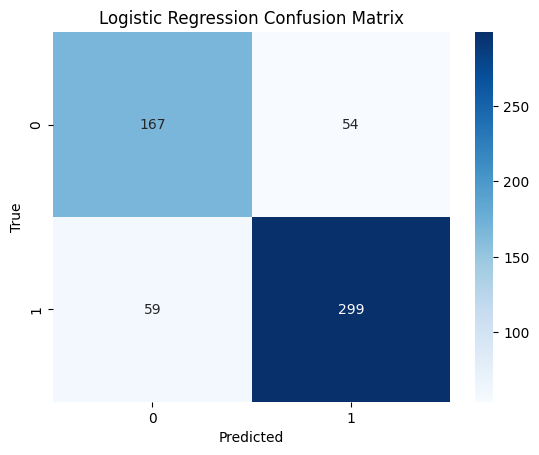

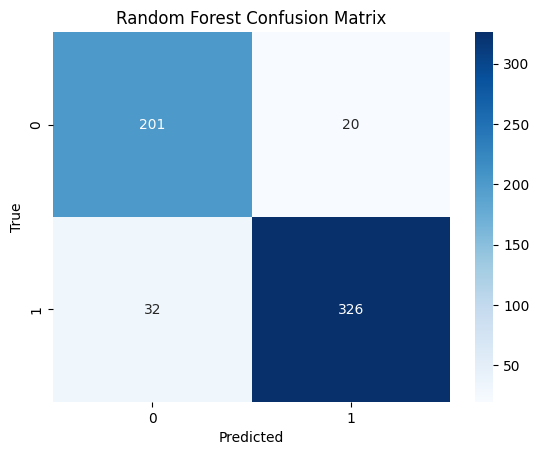

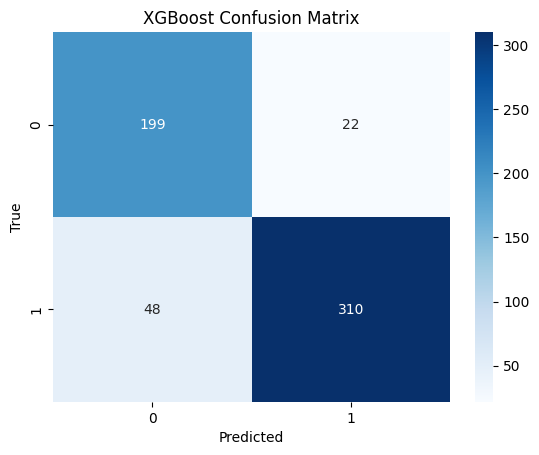

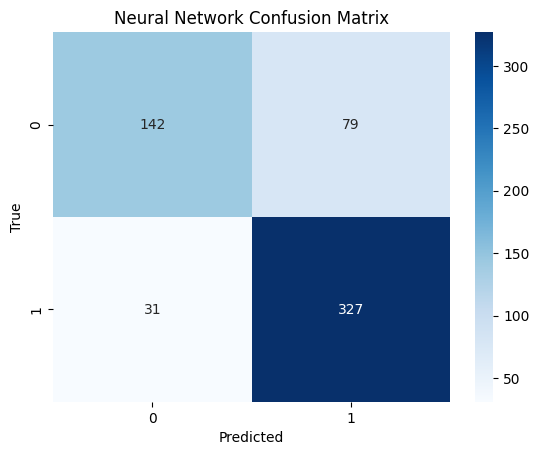

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Confusion matrix for Neural Network
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()


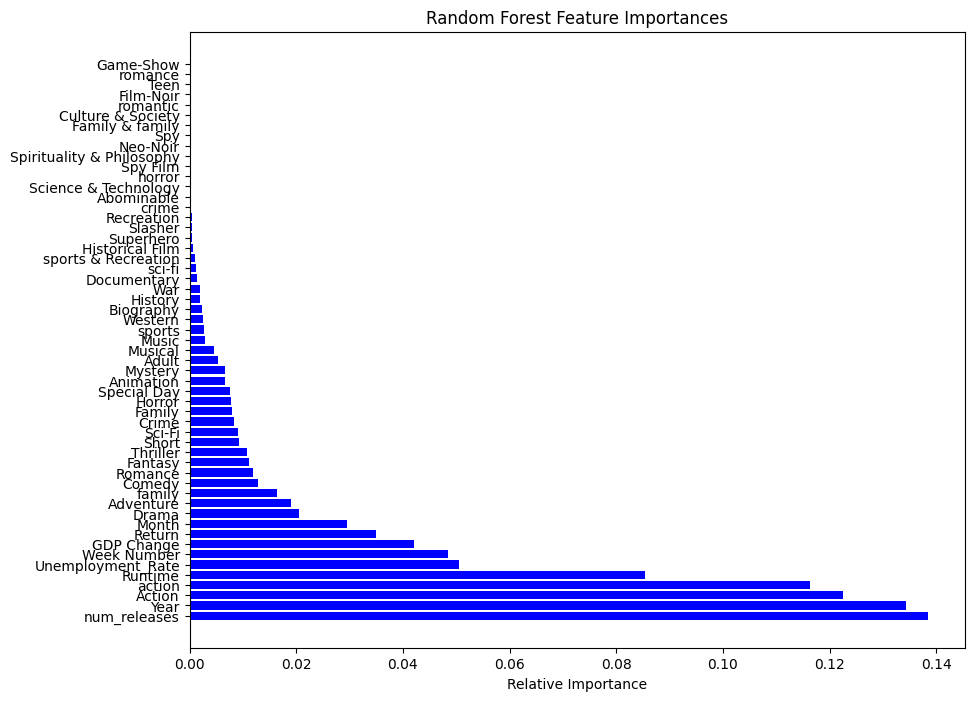

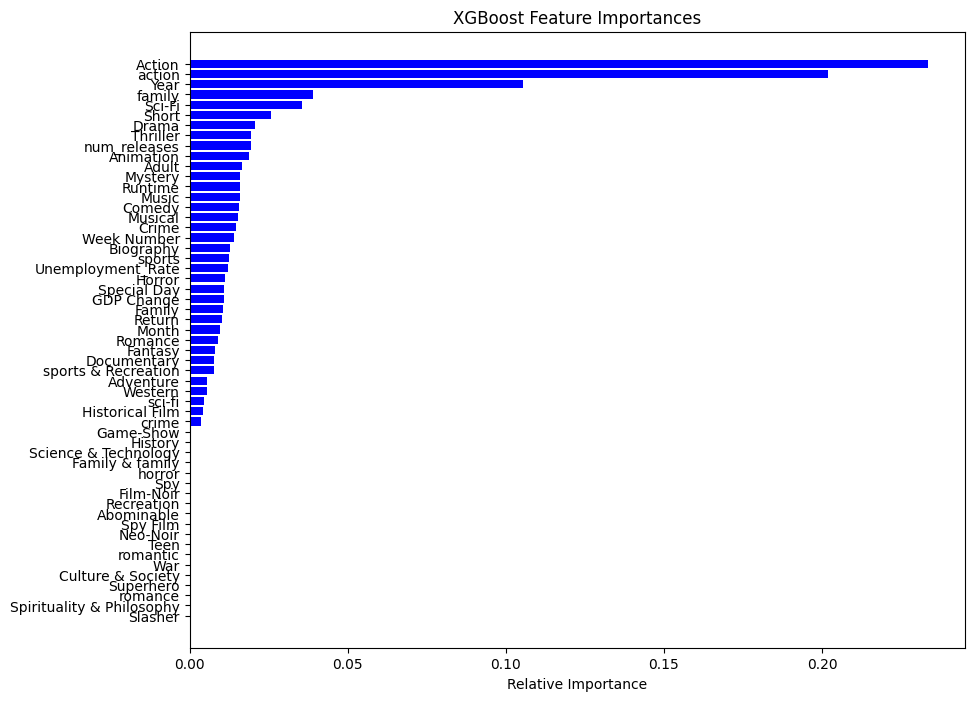

In [ ]:
# Random Forest feature importance 
importances = rf.feature_importances_
features = features2_df.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost feature importance
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
# Random Forest feature importance
importances = rf.feature_importances_
features = features2_df.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost feature importance
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


**Pytorch NN for Binary Classification to Predict Movie Success**

In [ ]:
fnn = FNN(in_dim=in_dim2, out_dim=out_dim2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-6)
epoch = 5000

loss_LIST_fnn = []
acc_LIST_fnn = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in trainloader_2:
      labels = labels.type(torch.LongTensor)
      inputs, labels = inputs.to(device), labels.to(device)
      labels = labels.squeeze(1)

      optimizer.zero_grad()
      outputs = fnn(inputs)
      prediction = torch.argmax(outputs, dim=1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss = running_loss + loss.item()

      num_correct = (prediction == labels).sum().item()
      correct = correct + num_correct
      total = total + labels.shape[0]

  accuracy = (correct / total) * 100
  acc_LIST_fnn.append(accuracy)

  avg_loss = running_loss / len(trainloader_2) 
  loss_LIST_fnn.append(avg_loss)

  print("The loss for Epoch {} is: {}, Accuarcy: {} ".format(epoch, running_loss/len(trainloader_2), accuracy))

fig, ax = plt.subplots(figsize=(30, 10))
epochs = range(1, len(loss_LIST_fnn)+1)
ax.plot(epochs, loss_LIST_fnn, label='training loss')
ax.set_title('Training loss vs epochs (FNN)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training loss')
ax.set_xticks(epochs)
ax.legend()
plt.show()

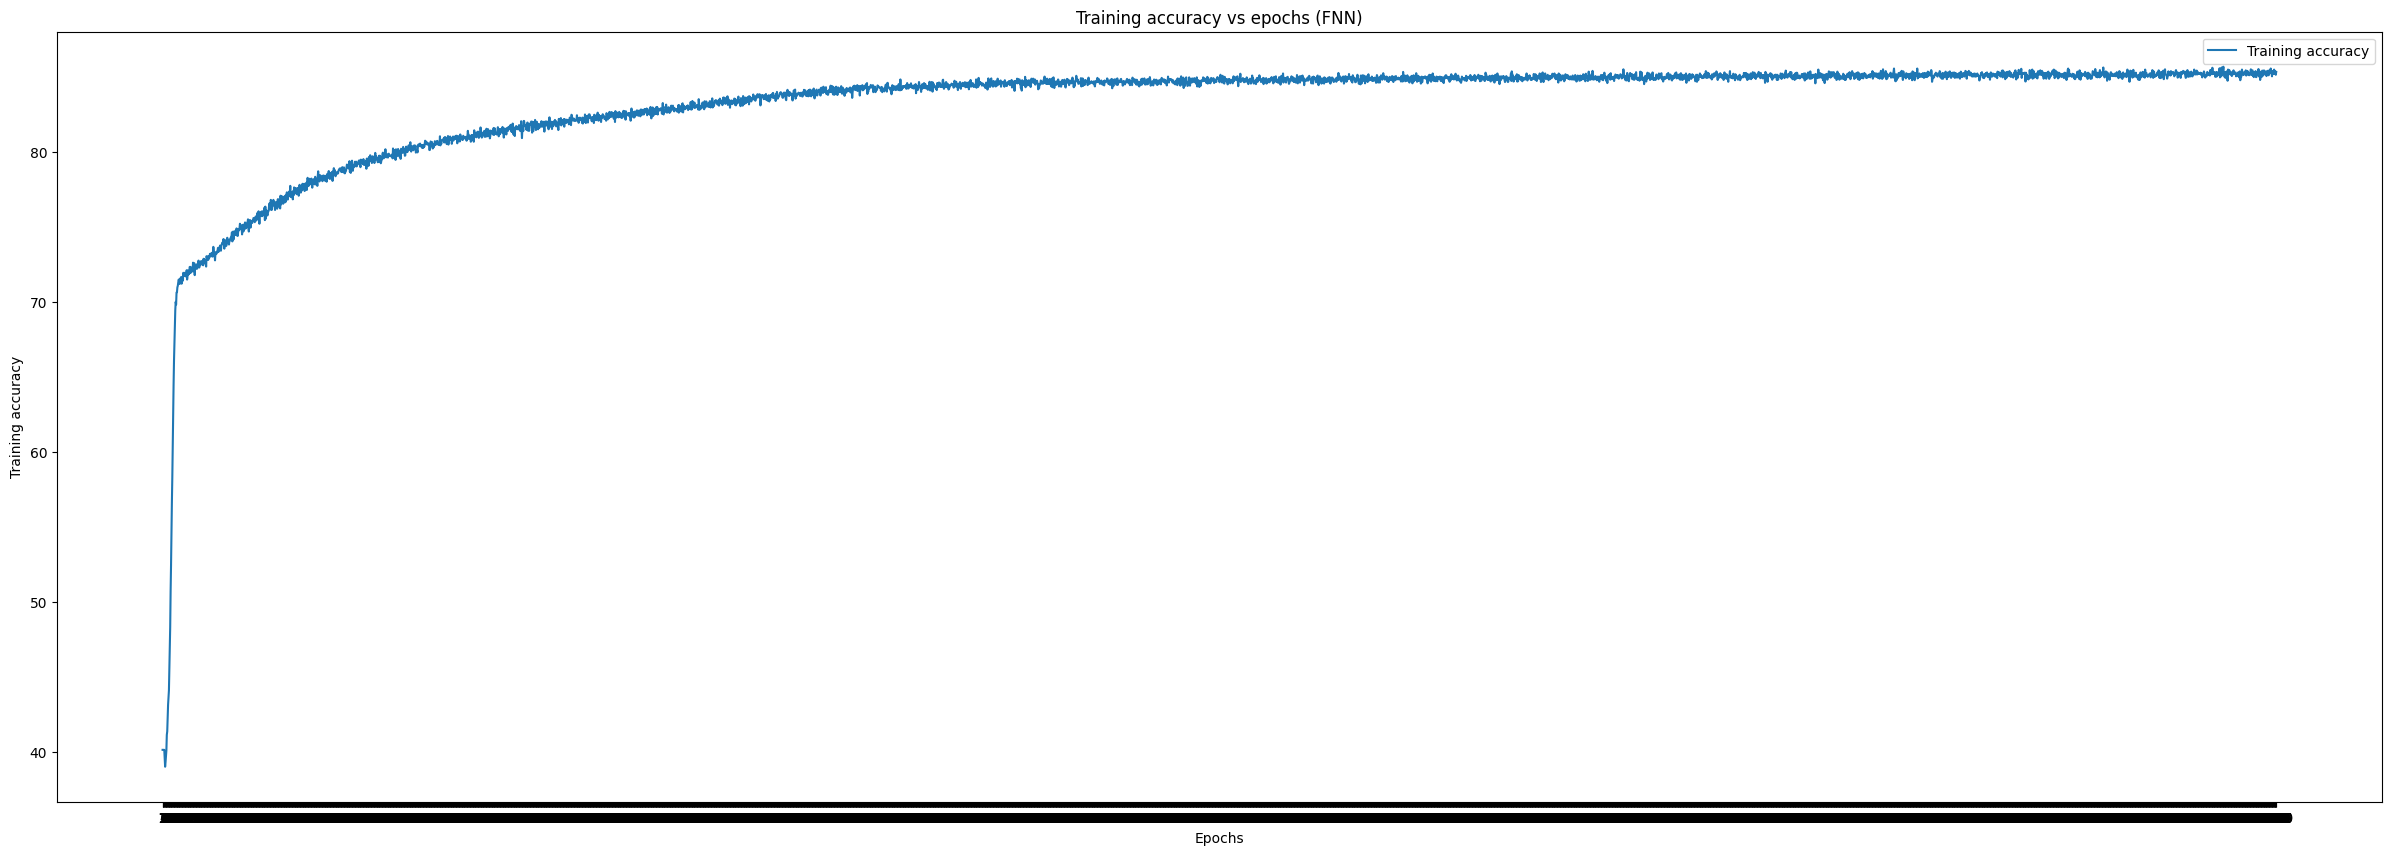

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
epochs = range(1, len(acc_LIST_fnn)+1)
ax.plot(epochs, acc_LIST_fnn, label='Training accuracy')
ax.set_title('Training accuracy vs epochs (FNN)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training accuracy')
ax.legend()
ax.set_xticks(epochs)
plt.show()

Test Accuracy: 83.41968536376953


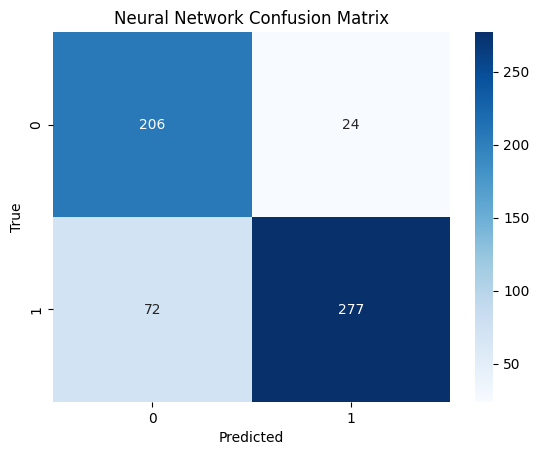

In [ ]:
#Pytorch NN Binary Classification 

from sklearn.metrics import confusion_matrix

total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in testloader_2:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)

        outputs = fnn(inputs)

        prediction = torch.argmax(outputs, dim=1)

        num_correct = (prediction == labels).sum()
        correct = correct + num_correct
        total = total + labels.shape[0]

test_acc_fnn = (correct / total) * 100

print('Test Accuracy: ' + str(test_acc_fnn.item()))


# Plot confusion matrix
cm = confusion_matrix(labels.cpu(), prediction.cpu())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()



**Binary Classification to Predict Movie Success Without Finance Features**

In [ ]:

features3_df['Runtime'] = features3_df['Runtime'].astype(float)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features3_df, targets3_df, train_size=0.9, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

y_pred_train_log = log_reg.predict(X_train)
acc_train_log = accuracy_score(y_train, y_pred_train_log)

print("Logistic Regression:")
print("Training accuracy:", acc_train_log)
print("Testing accuracy:", acc_log)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
acc_train_rf = accuracy_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training accuracy:", acc_train_rf)
print("Testing accuracy:", acc_rf)

# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training accuracy:", acc_train_xgb)
print("Testing accuracy:", acc_xgb)

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
acc_train_mlp = accuracy_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training accuracy:", acc_train_mlp)
print("Testing accuracy:", acc_mlp)

<ipython-input-210-a25f00e3730e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features3_df['Runtime'] = features3_df['Runtime'].astype(float)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Logistic Regression:
Training accuracy: 0.8252595155709342
Testing accuracy: 0.8255613126079447

Random Forest:
Training accuracy: 0.9911572472126106
Testing accuracy: 0.9050086355785838

XGBoost:
Training accuracy: 0.9142637447135717
Testing accuracy: 0.8877374784110535


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training accuracy: 0.7914263744713572
Testing accuracy: 0.7979274611398963


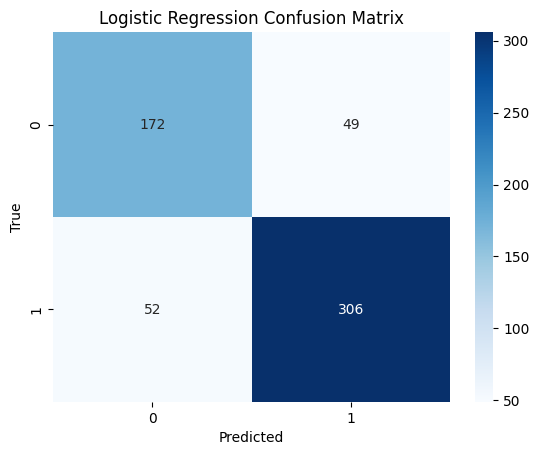

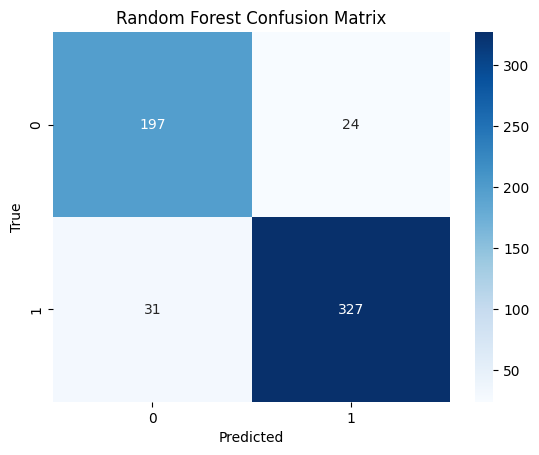

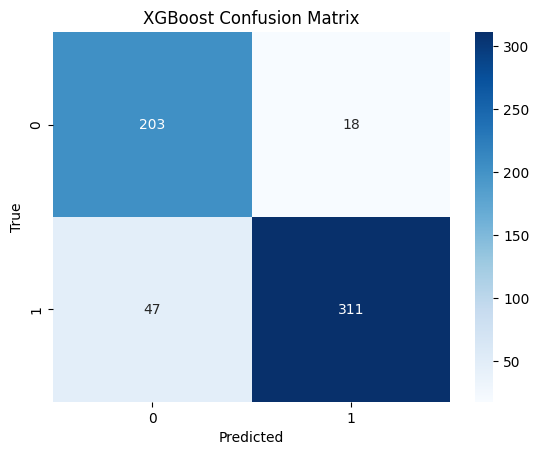

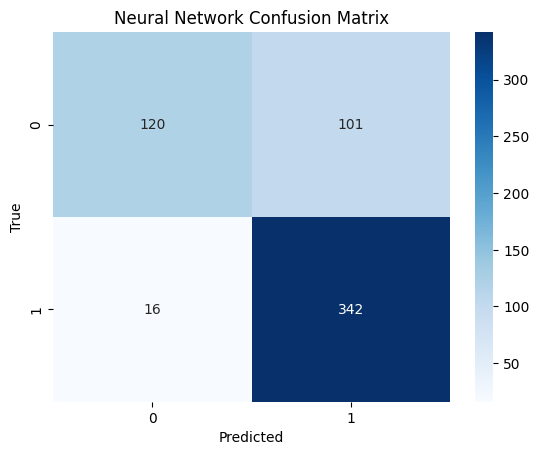

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Confusion matrix for Neural Network
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()


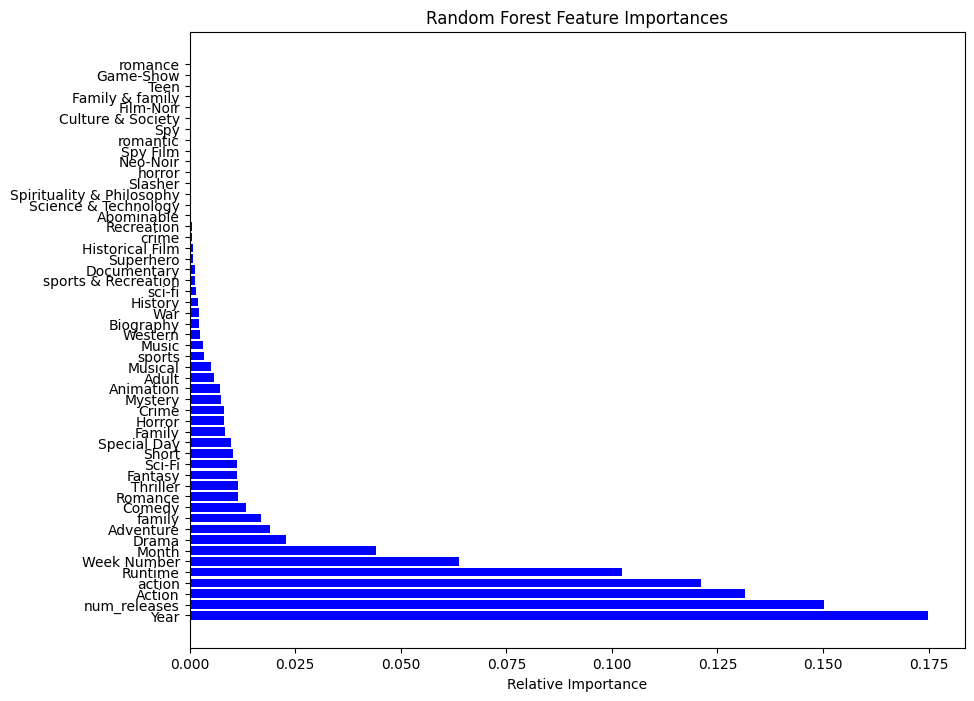

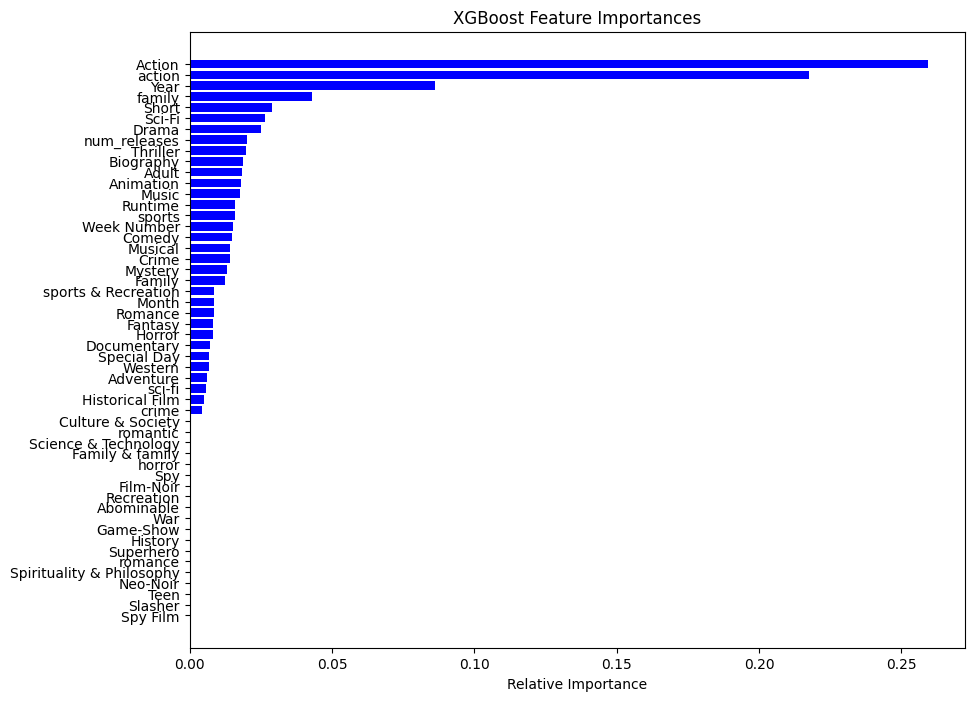

In [ ]:
# Random Forest feature importance
importances = rf.feature_importances_
features = features3_df.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost feature importance
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



**Run all Models With Scaling the Finance Data and Certain Movie Attributes.**



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.0.0+cu118
cuda:0


In [ ]:
dataset1_df = pd.read_csv('Genre_Train_Csv.csv')
dataset2_df = pd.read_csv('data_probablity_of_Success_train.csv')

In [ ]:
dataset2_df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Runtime', 'Special Day', 'family',
       'Unnamed: 11', 'Mystery', 'action', 'romantic', 'War', 'Sci-Fi',
       'Superhero', 'romance', 'crime', 'Spirituality & Philosophy',
       'Neo-Noir', 'Documentary', 'Animation', 'Game-Show', 'Drama',
       'Culture & Society', 'Thriller', 'Western', 'Slasher', 'Spy Film',
       'History', 'sports & Recreation', 'Music', 'Horror', 'Historical Film',
       'Action', 'Biography', 'Crime', 'sports', 'Abominable', 'Recreation',
       'Romance', 'Film-Noir', 'Musical', 'Fantasy', 'Comedy', 'Spy',
       'Adventure', 'Short', 'horror', 'Family & family', 'Family', 'Adult',
       'Science & Technology', 'Teen', 'sci-fi', 'y'],
      dtype='object')

In [ ]:
dataset1_df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day', 'Musical',
       'Superhero', 'Historical Film', 'Society', 'Documentary', 'Sport',
       'Music', 'Biography', 'War', 'Comedy', 'Recreation', 'Game-Show',
       'Mystery', 'Adventure', 'Adult', 'Neo-Noir', 'Philosophy', 'Science',
       'History', 'Thriller', 'Western', 'Crime', 'Horror', 'Drama', 'Sci-Fi',
       'Film-Noir', 'Technology', 'Family', 'Animation', 'Spy Film', 'sport',
       'Personal Relationships', 'Culture', 'Romance', 'Fantasy', 'Short',
       'action', 'Spirituality'],
      dtype='object')

In [ ]:
dataset1_df = dataset1_df.drop(columns=['Unnamed: 0'])
dataset2_df = dataset2_df.drop(columns=['Unnamed: 0', 'Unnamed: 11'])
dataset2_df = dataset2_df[~dataset2_df.eq('TBD').any(1)].reset_index(drop=True)
dataset3_df = dataset2_df.drop(['Return', 'GDP Change','Unemployment_Rate'], axis=1)

<ipython-input-220-f23ebd971e98>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  dataset2_df = dataset2_df[~dataset2_df.eq('TBD').any(1)].reset_index(drop=True)


In [ ]:
in_dim1 = 8
out_dim1 = 37

in_dim2 = 55
out_dim2 = 2

in_dim3 = 52
out_dim3 = 2

In [ ]:
dataset1 = dataset1_df.values.astype('float32')
dataset1 = torch.tensor(dataset1, dtype=torch.float32)

dataset2 = dataset2_df.values.astype('float32')
dataset2 = torch.tensor(dataset2, dtype=torch.float32)

dataset3 = dataset3_df.values.astype('float32')
dataset3 = torch.tensor(dataset3, dtype=torch.float32)

dataset_1 = TensorDataset(dataset1[:, 0:8], dataset1[:, 8:-1])
dataset_2 = TensorDataset(dataset2[:, 0:55], dataset2[:, 55:56])
dataset_3 = TensorDataset(dataset3[:, 0:52], dataset2[:, 52:53])

n_samples_1 = len(dataset_1)
n_train_1 = int(0.9 * n_samples_1)
n_test_1 = n_samples_1 - n_train_1
trainset_1, testset_1 = random_split(dataset_1, [n_train_1, n_test_1])

n_samples_2 = len(dataset_2)
n_train_2 = int(0.9 * n_samples_2)
n_test_2 = n_samples_2 - n_train_2
trainset_2, testset_2 = random_split(dataset_2, [n_train_2, n_test_2])

n_samples_3 = len(dataset_3)
n_train_3 = int(0.9 * n_samples_3)
n_test_3 = n_samples_3 - n_train_3
trainset_3, testset_3 = random_split(dataset_3, [n_train_3, n_test_3])

batch_size = 32
trainloader_1 = DataLoader(trainset_1, batch_size=batch_size, shuffle=True)
testloader_1 = DataLoader(testset_1, batch_size=X_train1.shape[0], shuffle=True)

trainloader_2 = DataLoader(dataset_2, batch_size=batch_size, shuffle=True)
testloader_2 = DataLoader(testset_2, batch_size=X_train2.shape[0], shuffle=True)

trainloader_3 = DataLoader(dataset_3, batch_size=batch_size, shuffle=True)
testloader_3 = DataLoader(testset_3, batch_size=X_train3.shape[0], shuffle=True)

In [ ]:
targets1_df = dataset1_df[['Musical',
       'Superhero', 'Historical Film', 'Society', 'Documentary', 'Sport',
       'Music', 'Biography', 'War', 'Comedy', 'Recreation', 'Game-Show',
       'Mystery', 'Adventure', 'Adult', 'Neo-Noir', 'Philosophy', 'Science',
       'History', 'Thriller', 'Western', 'Crime', 'Horror', 'Drama', 'Sci-Fi',
       'Film-Noir', 'Technology', 'Family', 'Animation', 'Spy Film', 'sport',
       'Personal Relationships', 'Culture', 'Romance', 'Fantasy', 'Short',
       'action', 'Spirituality']]

features1_df = dataset1_df[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Special Day']]

targets2_df = dataset2_df[['y']]

features2_df = dataset2_df[['Year', 'Month', 'Week Number', 'Return', 'GDP Change',
       'Unemployment_Rate', 'num_releases', 'Runtime', 'Special Day', 'family',
       'Mystery', 'action', 'romantic', 'War', 'Sci-Fi', 'Superhero',
       'romance', 'crime', 'Spirituality & Philosophy', 'Neo-Noir',
       'Documentary', 'Animation', 'Game-Show', 'Drama', 'Culture & Society',
       'Thriller', 'Western', 'Slasher', 'Spy Film', 'History',
       'sports & Recreation', 'Music', 'Horror', 'Historical Film', 'Action',
       'Biography', 'Crime', 'sports', 'Abominable', 'Recreation', 'Romance',
       'Film-Noir', 'Musical', 'Fantasy', 'Comedy', 'Spy', 'Adventure',
       'Short', 'horror', 'Family & family', 'Family', 'Adult',
       'Science & Technology', 'Teen', 'sci-fi']]

targets3_df = dataset3_df[['y']]

features3_df = dataset3_df[['Year', 'Month', 'Week Number', 'num_releases', 'Runtime', 'Special Day', 'family',
       'Mystery', 'action', 'romantic', 'War', 'Sci-Fi', 'Superhero',
       'romance', 'crime', 'Spirituality & Philosophy', 'Neo-Noir',
       'Documentary', 'Animation', 'Game-Show', 'Drama', 'Culture & Society',
       'Thriller', 'Western', 'Slasher', 'Spy Film', 'History',
       'sports & Recreation', 'Music', 'Horror', 'Historical Film', 'Action',
       'Biography', 'Crime', 'sports', 'Abominable', 'Recreation', 'Romance',
       'Film-Noir', 'Musical', 'Fantasy', 'Comedy', 'Spy', 'Adventure',
       'Short', 'horror', 'Family & family', 'Family', 'Adult',
       'Science & Technology', 'Teen', 'sci-fi']]

In [ ]:
seed = 42

X_train1_df, X_test1_df, y_train1_df, y_test1_df = train_test_split(features1_df, targets1_df, train_size=0.9, random_state=seed)

X_train1 = torch.tensor(X_train1_df.values, dtype=torch.float32)
X_test1 = torch.tensor(X_test1_df.values, dtype=torch.float32)
y_train1 = torch.tensor(y_train1_df.values, dtype=torch.float32)
y_test1 = torch.tensor(y_test1_df.values, dtype=torch.float32)


X_train2_df, X_test2_df, y_train2_df, y_test2_df = train_test_split(features2_df, targets2_df, train_size=0.9, random_state=seed)
X_train2_df = X_train2_df.values.astype('float32')
X_test2_df = X_test2_df.values.astype('float32')
y_train2_df = y_train2_df.values.astype('float32').ravel()
y_test2_df = y_test2_df.values.astype('float32').ravel()

X_train3_df, X_test3_df, y_train3_df, y_test3_df = train_test_split(features3_df, targets3_df, train_size=0.9, random_state=seed)
X_train3_df = X_train3_df.values.astype('float32')
X_test3_df = X_test3_df.values.astype('float32')
y_train3_df = y_train3_df.values.astype('float32').ravel()
y_test3_df = y_test3_df.values.astype('float32').ravel()
#################################################################
X_train2 = torch.tensor(X_train2_df, dtype=torch.float32)
X_test2 = torch.tensor(X_test2_df, dtype=torch.float32)
y_train2 = torch.tensor(y_train2_df, dtype=torch.float32)
y_test2 = torch.tensor(y_test2_df, dtype=torch.float32)

X_train3 = torch.tensor(X_train3_df, dtype=torch.float32)
X_test3 = torch.tensor(X_test3_df, dtype=torch.float32)
y_train3 = torch.tensor(y_train3_df, dtype=torch.float32)
y_test3 = torch.tensor(y_test3_df, dtype=torch.float32)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features1_df, targets1_df, train_size=0.9, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

y_pred_train_lin = lin_reg.predict(X_train)
mse_train_lin = mean_squared_error(y_train, y_pred_train_lin)
r2_train_lin = r2_score(y_train, y_pred_train_lin)

print("Linear Regression:")
print("Training MSE:", mse_train_lin)
print("Testing MSE:", mse_lin)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training MSE:", mse_train_rf)
print("Testing MSE:", mse_rf)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training MSE:", mse_train_xgb)
print("Testing MSE:", mse_xgb)

# Neural Network
mlp = MLPRegressor(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
mse_train_mlp = mean_squared_error(y_train, y_pred_train_mlp)
r2_train_mlp = r2_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training MSE:", mse_train_mlp)
print("Testing MSE:", mse_mlp)



Linear Regression:
Training MSE: 0.046404064942707046
Testing MSE: 0.046275703188274175

Random Forest:
Training MSE: 0.011436296221786742
Testing MSE: 0.033685953984577584

XGBoost:
Training MSE: 0.01887972357566502
Testing MSE: 0.03415079271065826

Neural Network:
Training MSE: 0.08425140250134111
Testing MSE: 0.08272275563863475


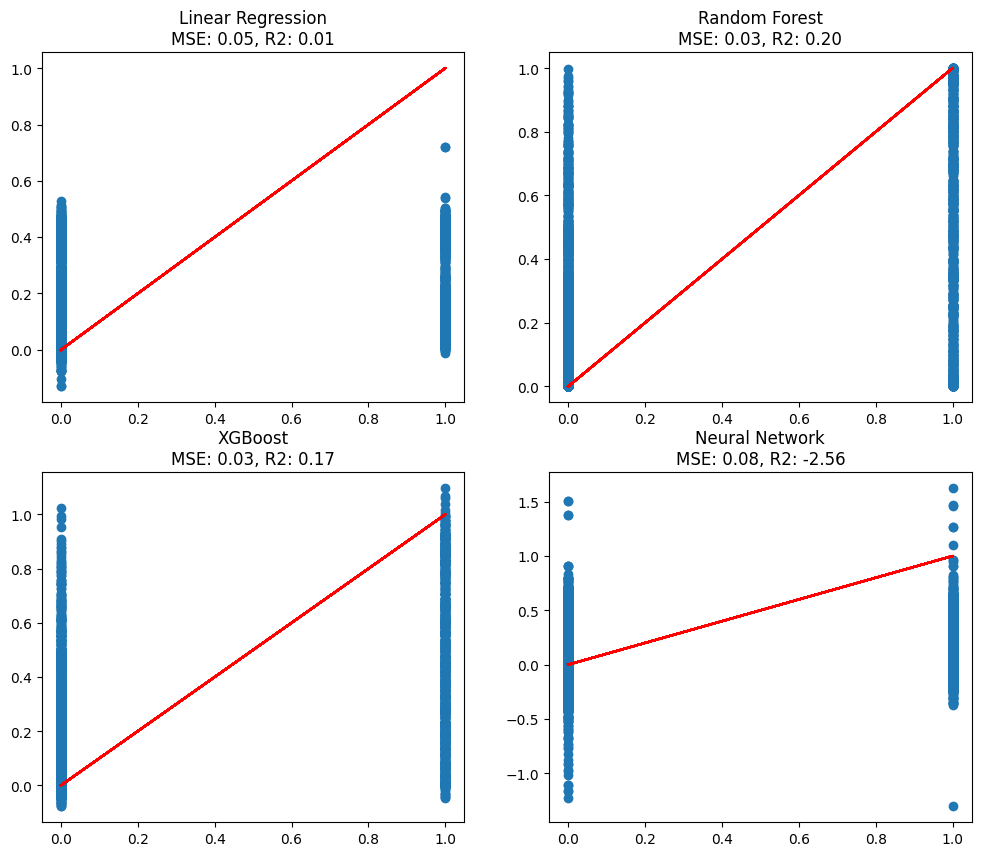

In [ ]:
#Plot the predicted vs actual values for each model
#Linear Regression
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(y_test, y_pred_lin)
axs[0, 0].plot(y_test, y_test, color='r')
axs[0, 0].set_title('Linear Regression\nMSE: {:.2f}, R2: {:.2f}'.format(mse_lin, r2_lin))

#Random Forest
axs[0, 1].scatter(y_test, y_pred_rf)
axs[0, 1].plot(y_test, y_test, color='r')
axs[0, 1].set_title('Random Forest\nMSE: {:.2f}, R2: {:.2f}'.format(mse_rf, r2_rf))

#XGBoost
axs[1, 0].scatter(y_test, y_pred_xgb)
axs[1, 0].plot(y_test, y_test, color='r')
axs[1, 0].set_title('XGBoost\nMSE: {:.2f}, R2: {:.2f}'.format(mse_xgb, r2_xgb))

#Neural Network
axs[1, 1].scatter(y_test, y_pred_mlp)
axs[1, 1].plot(y_test, y_test, color='r')
axs[1, 1].set_title('Neural Network\nMSE: {:.2f}, R2: {:.2f}'.format(mse_mlp, r2_mlp))

plt.show()

Task 2 as a Regression problem: 

In [ ]:
dataset1_df = pd.read_csv('Genre_Train_Csv.csv')
dataset2_df = pd.read_csv('data_probablity_of_Success_train.csv')

In [ ]:
features2_df['Runtime'] = features2_df['Runtime'].astype(float)

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features2_df, targets2_df, train_size=0.9, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

y_pred_train_lin = lin_reg.predict(X_train)
mse_train_lin = mean_squared_error(y_train, y_pred_train_lin)
r2_train_lin = r2_score(y_train, y_pred_train_lin)

print("Linear Regression:")
print("Training MSE:", mse_train_lin)
print("Testing MSE:", mse_lin)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training MSE:", mse_train_rf)
print("Testing MSE:", mse_rf)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training MSE:", mse_train_xgb)
print("Testing MSE:", mse_xgb)

# Neural Network
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
mse_train_mlp = mean_squared_error(y_train, y_pred_train_mlp)
r2_train_mlp = r2_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training MSE:", mse_train_mlp)
print("Testing MSE:", mse_mlp)

Linear Regression:
Training MSE: 0.11362414066337503
Testing MSE: 0.11884947975751446


<ipython-input-231-7756d5cd0246>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)



Random Forest:
Training MSE: 0.011937566902078527
Testing MSE: 0.060983406160823705

XGBoost:
Training MSE: 0.05896443814670758
Testing MSE: 0.07855031278844897


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training MSE: 0.15404176220582036
Testing MSE: 0.20313859417675695


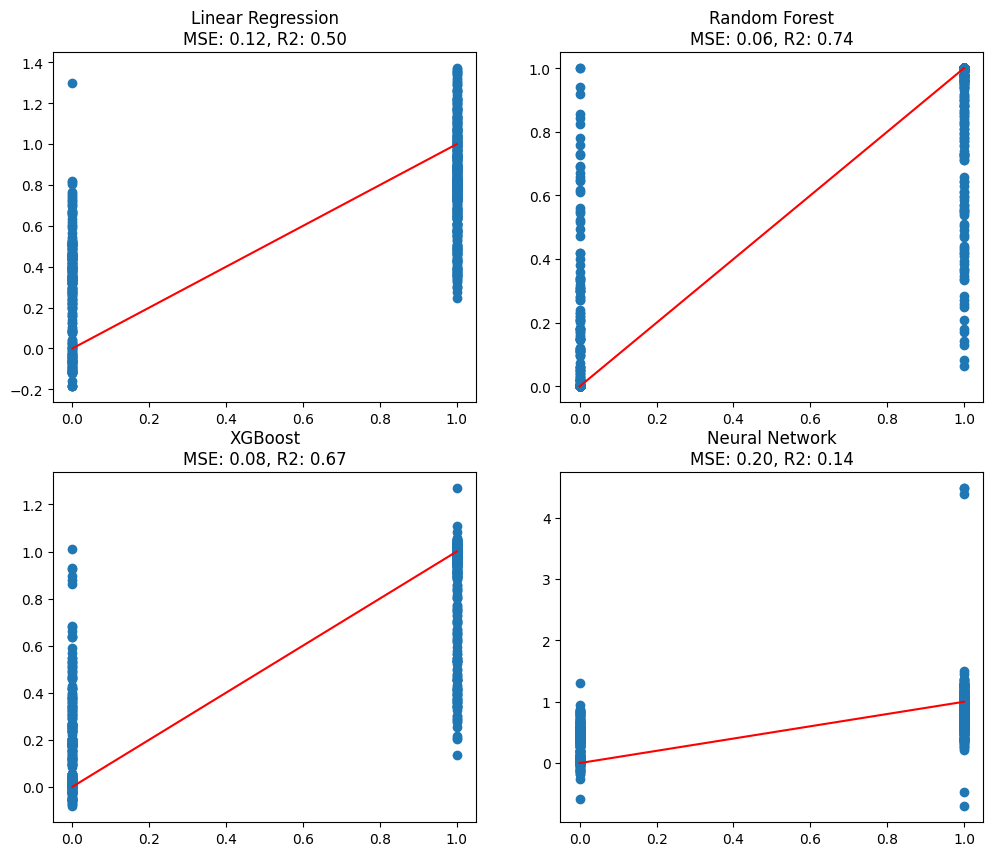

In [ ]:
#Plot the predicted vs actual values for each model
#Linear Regression
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(y_test, y_pred_lin)
axs[0, 0].plot(y_test, y_test, color='r')
axs[0, 0].set_title('Linear Regression\nMSE: {:.2f}, R2: {:.2f}'.format(mse_lin, r2_lin))

#Random Forest
axs[0, 1].scatter(y_test, y_pred_rf)
axs[0, 1].plot(y_test, y_test, color='r')
axs[0, 1].set_title('Random Forest\nMSE: {:.2f}, R2: {:.2f}'.format(mse_rf, r2_rf))

#XGBoost
axs[1, 0].scatter(y_test, y_pred_xgb)
axs[1, 0].plot(y_test, y_test, color='r')
axs[1, 0].set_title('XGBoost\nMSE: {:.2f}, R2: {:.2f}'.format(mse_xgb, r2_xgb))

#Neural Network
axs[1, 1].scatter(y_test, y_pred_mlp)
axs[1, 1].plot(y_test, y_test, color='r')
axs[1, 1].set_title('Neural Network\nMSE: {:.2f}, R2: {:.2f}'.format(mse_mlp, r2_mlp))

plt.show()

Task-2: Regression without Finance data

In [ ]:
# Split data into training and test sets
features3_df['Runtime'] = features3_df['Runtime'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(features3_df, targets3_df, train_size=0.9, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

y_pred_train_lin = lin_reg.predict(X_train)
mse_train_lin = mean_squared_error(y_train, y_pred_train_lin)
r2_train_lin = r2_score(y_train, y_pred_train_lin)

print("Linear Regression:")
print("Training MSE:", mse_train_lin)
print("Testing MSE:", mse_lin)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training MSE:", mse_train_rf)
print("Testing MSE:", mse_rf)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training MSE:", mse_train_xgb)
print("Testing MSE:", mse_xgb)

# Neural Network
mlp = MLPRegressor(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
mse_train_mlp = mean_squared_error(y_train, y_pred_train_mlp)
r2_train_mlp = r2_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training MSE:", mse_train_mlp)
print("Testing MSE:", mse_mlp)

Linear Regression:
Training MSE: 0.1136519299177407
Testing MSE: 0.11893053146830415


<ipython-input-237-df3429385d4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features3_df['Runtime'] = features3_df['Runtime'].astype(float)
<ipython-input-237-df3429385d4e>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)



Random Forest:
Training MSE: 0.011840631203285974
Testing MSE: 0.05976994462639169

XGBoost:
Training MSE: 0.06179179786092416
Testing MSE: 0.07939956625016655


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training MSE: 3.887042930956092
Testing MSE: 3.852782657215124


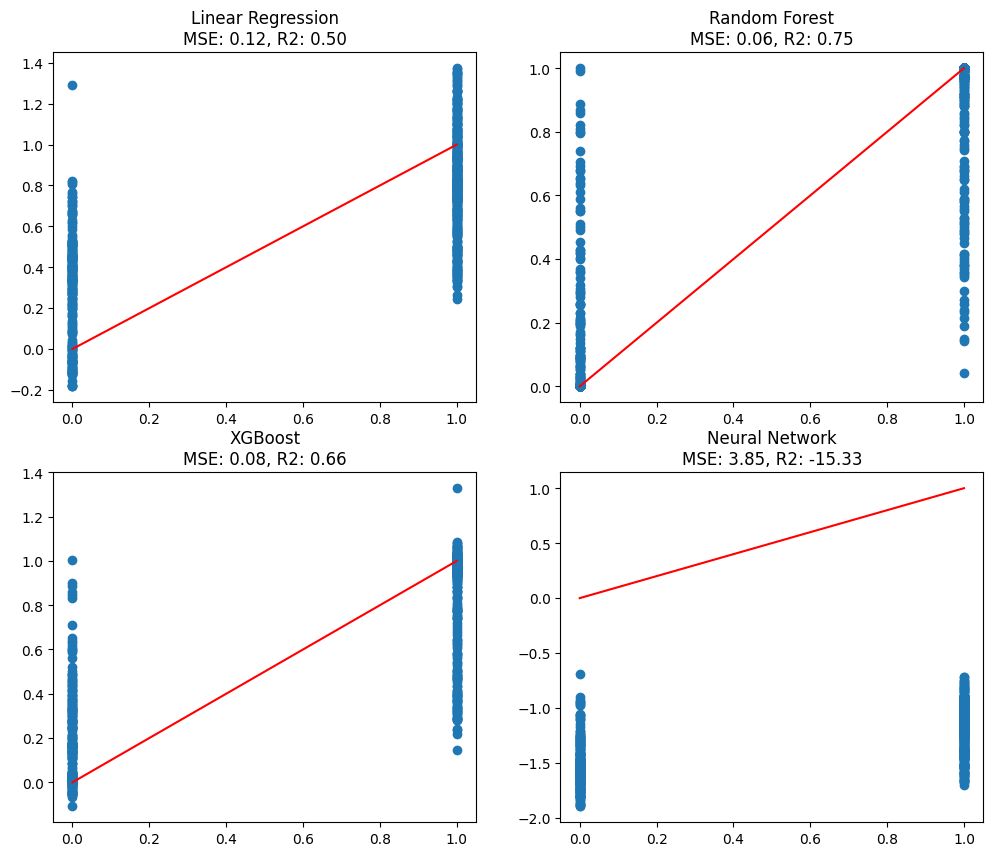

In [ ]:
#Plot the predicted vs actual values for each model
#Linear Regression
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(y_test, y_pred_lin)
axs[0, 0].plot(y_test, y_test, color='r')
axs[0, 0].set_title('Linear Regression\nMSE: {:.2f}, R2: {:.2f}'.format(mse_lin, r2_lin))

#Random Forest
axs[0, 1].scatter(y_test, y_pred_rf)
axs[0, 1].plot(y_test, y_test, color='r')
axs[0, 1].set_title('Random Forest\nMSE: {:.2f}, R2: {:.2f}'.format(mse_rf, r2_rf))

#XGBoost
axs[1, 0].scatter(y_test, y_pred_xgb)
axs[1, 0].plot(y_test, y_test, color='r')
axs[1, 0].set_title('XGBoost\nMSE: {:.2f}, R2: {:.2f}'.format(mse_xgb, r2_xgb))

#Neural Network
axs[1, 1].scatter(y_test, y_pred_mlp)
axs[1, 1].plot(y_test, y_test, color='r')
axs[1, 1].set_title('Neural Network\nMSE: {:.2f}, R2: {:.2f}'.format(mse_mlp, r2_mlp))

plt.show()

# Task 2: Predict whether a movie will succeed or not (Binary Classification)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:

features2_df['Runtime'] = features2_df['Runtime'].astype(float)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features2_df, targets2_df, train_size=0.9, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

y_pred_train_log = log_reg.predict(X_train)
acc_train_log = accuracy_score(y_train, y_pred_train_log)

print("Logistic Regression:")
print("Training accuracy:", acc_train_log)
print("Testing accuracy:", acc_log)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
acc_train_rf = accuracy_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training accuracy:", acc_train_rf)
print("Testing accuracy:", acc_rf)

# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training accuracy:", acc_train_xgb)
print("Testing accuracy:", acc_xgb)

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
acc_train_mlp = accuracy_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training accuracy:", acc_train_mlp)
print("Testing accuracy:", acc_mlp)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-241-adc7d7d26d36>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Logistic Regression:
Training accuracy: 0.8141099577085736
Testing accuracy: 0.8048359240069085

Random Forest:
Training accuracy: 0.9911572472126106
Testing accuracy: 0.9101899827288429

XGBoost:
Training accuracy: 0.9231064975009612
Testing accuracy: 0.8791018998272885


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training accuracy: 0.8116109188773548
Testing accuracy: 0.8100172711571675


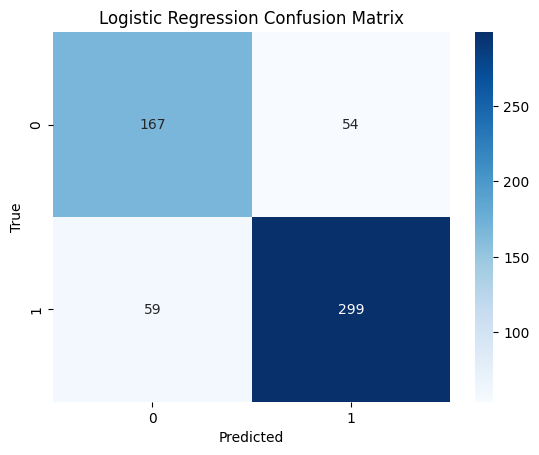

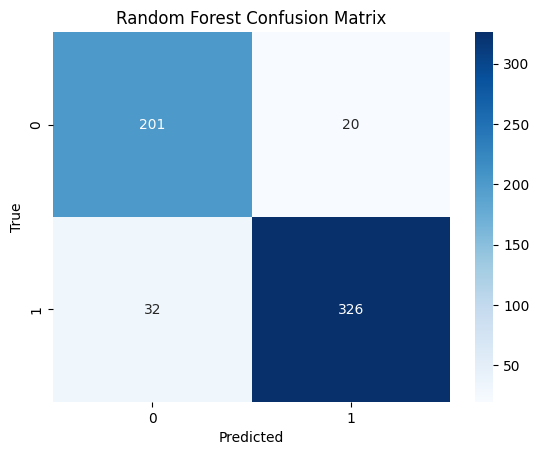

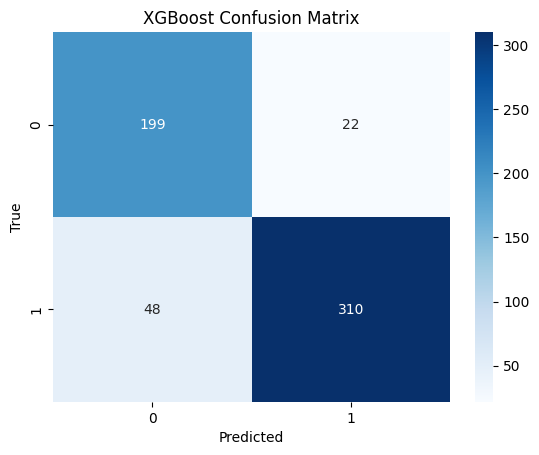

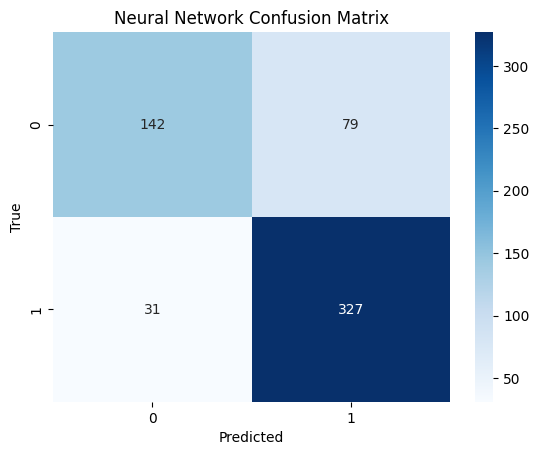

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Confusion matrix for Neural Network
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()


In [ ]:
# Random Forest feature importance
importances = rf.feature_importances_
features = features2_df.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost feature importance
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:


class FNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_dim, 512, bias=True)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(512, out_dim, bias=True)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.activation(x)

        x = self.fc2(x)
        outputs = self.activation(x)

        return outputs



The loss for Epoch 0 is: 38.92034039576409, Accuarcy: 40.13146514443868 
The loss for Epoch 1 is: 34.00942799267848, Accuarcy: 40.13146514443868 
The loss for Epoch 2 is: 29.084397837601973, Accuarcy: 40.13146514443868 
The loss for Epoch 3 is: 24.134042044370872, Accuarcy: 40.13146514443868 
The loss for Epoch 4 is: 17.81315221839188, Accuarcy: 40.13146514443868 
The loss for Epoch 5 is: 4.094473530903706, Accuarcy: 39.629821830133196 
The loss for Epoch 6 is: 1.5107526927363149, Accuarcy: 39.00709219858156 
The loss for Epoch 7 is: 1.4529992368339835, Accuarcy: 39.31845701435738 
The loss for Epoch 8 is: 1.3952367305755615, Accuarcy: 39.73361010205847 
The loss for Epoch 9 is: 1.3391179317268878, Accuarcy: 40.096869053796915 
The loss for Epoch 10 is: 1.2819217598240678, Accuarcy: 41.13475177304964 
The loss for Epoch 11 is: 1.2234390618392776, Accuarcy: 41.35962636222107 
The loss for Epoch 12 is: 1.167765539654052, Accuarcy: 42.18993253762325 
The loss for Epoch 13 is: 1.1096115194

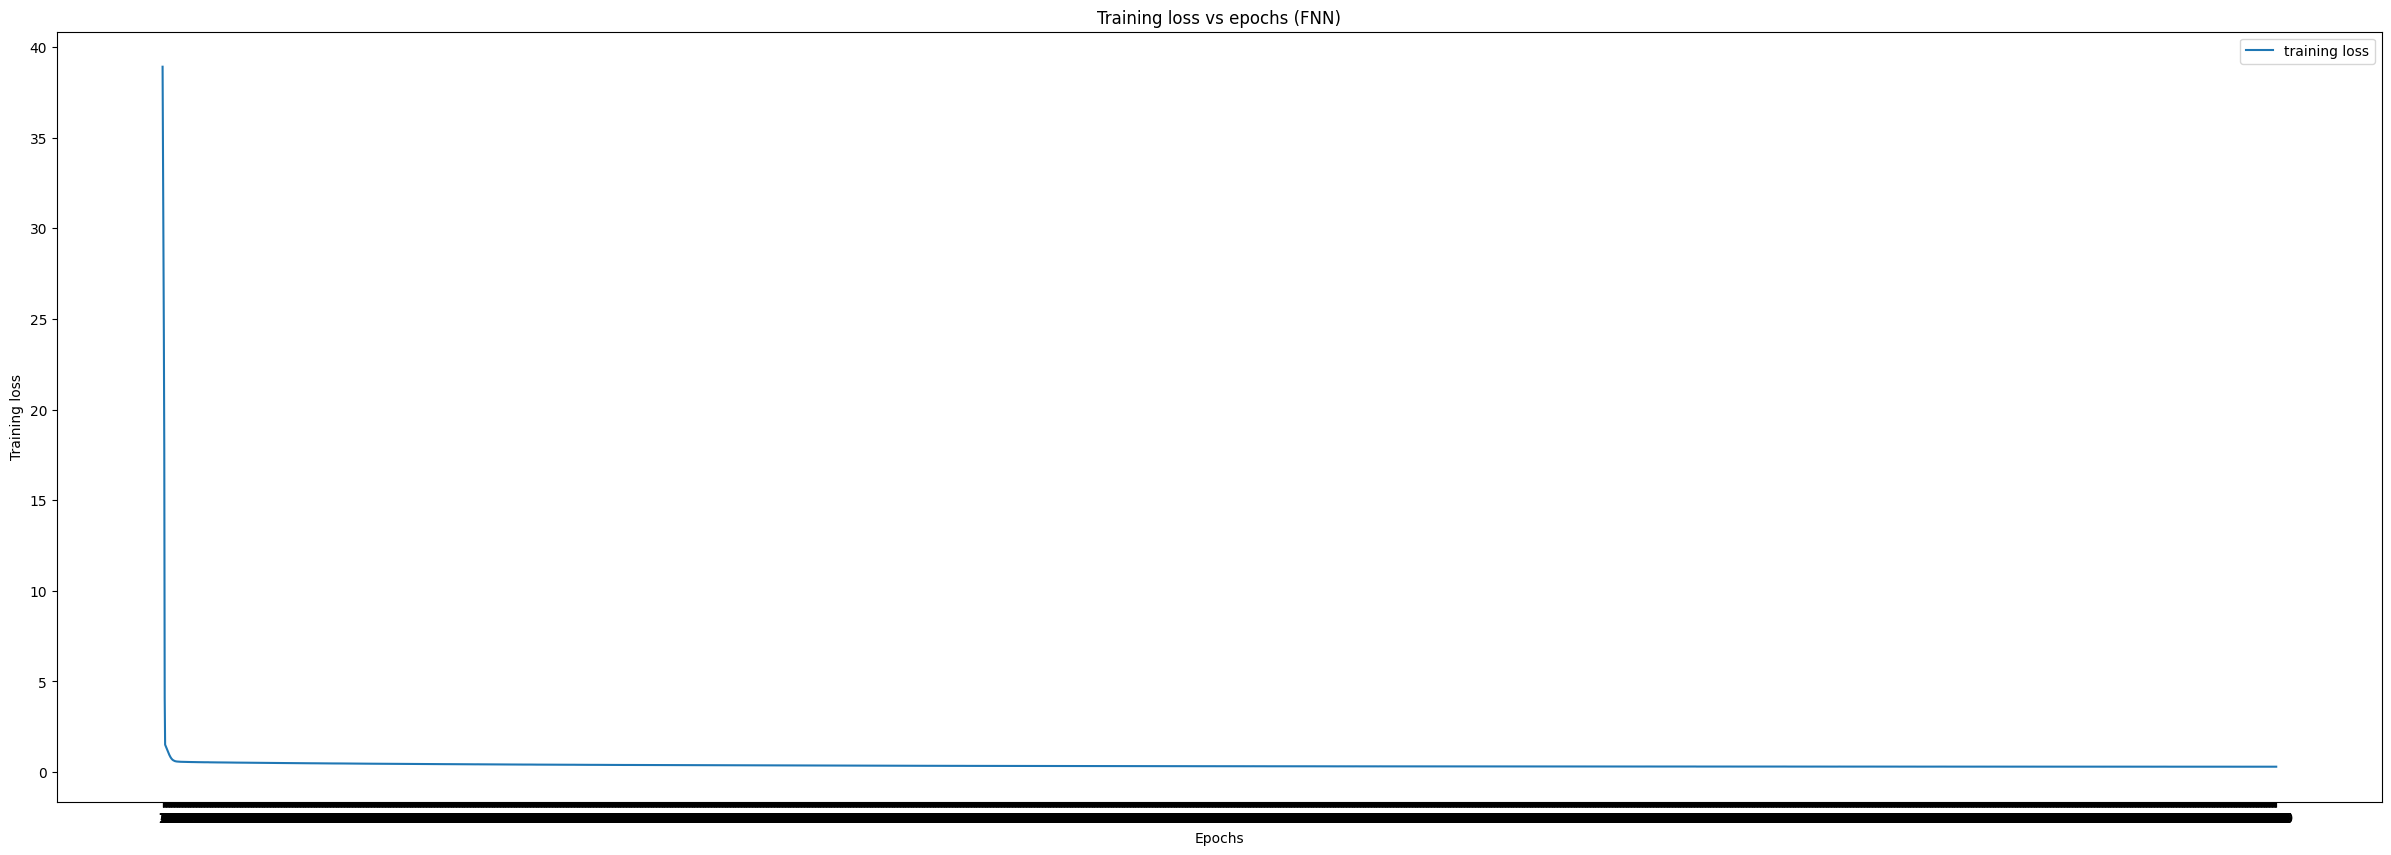

In [ ]:
fnn = FNN(in_dim=in_dim2, out_dim=out_dim2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-6)
epoch = 5000

loss_LIST_fnn = []
acc_LIST_fnn = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in trainloader_2:
      labels = labels.type(torch.LongTensor)
      inputs, labels = inputs.to(device), labels.to(device)
      labels = labels.squeeze(1)

      optimizer.zero_grad()
      outputs = fnn(inputs)
      prediction = torch.argmax(outputs, dim=1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss = running_loss + loss.item()

      num_correct = (prediction == labels).sum().item()
      correct = correct + num_correct
      total = total + labels.shape[0]

  accuracy = (correct / total) * 100
  acc_LIST_fnn.append(accuracy)

  avg_loss = running_loss / len(trainloader_2) 
  loss_LIST_fnn.append(avg_loss)

  print("The loss for Epoch {} is: {}, Accuarcy: {} ".format(epoch, running_loss/len(trainloader_2), accuracy))

fig, ax = plt.subplots(figsize=(30, 10))
epochs = range(1, len(loss_LIST_fnn)+1)
ax.plot(epochs, loss_LIST_fnn, label='training loss')
ax.set_title('Training loss vs epochs (FNN)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training loss')
ax.set_xticks(epochs)
ax.legend()
plt.show()

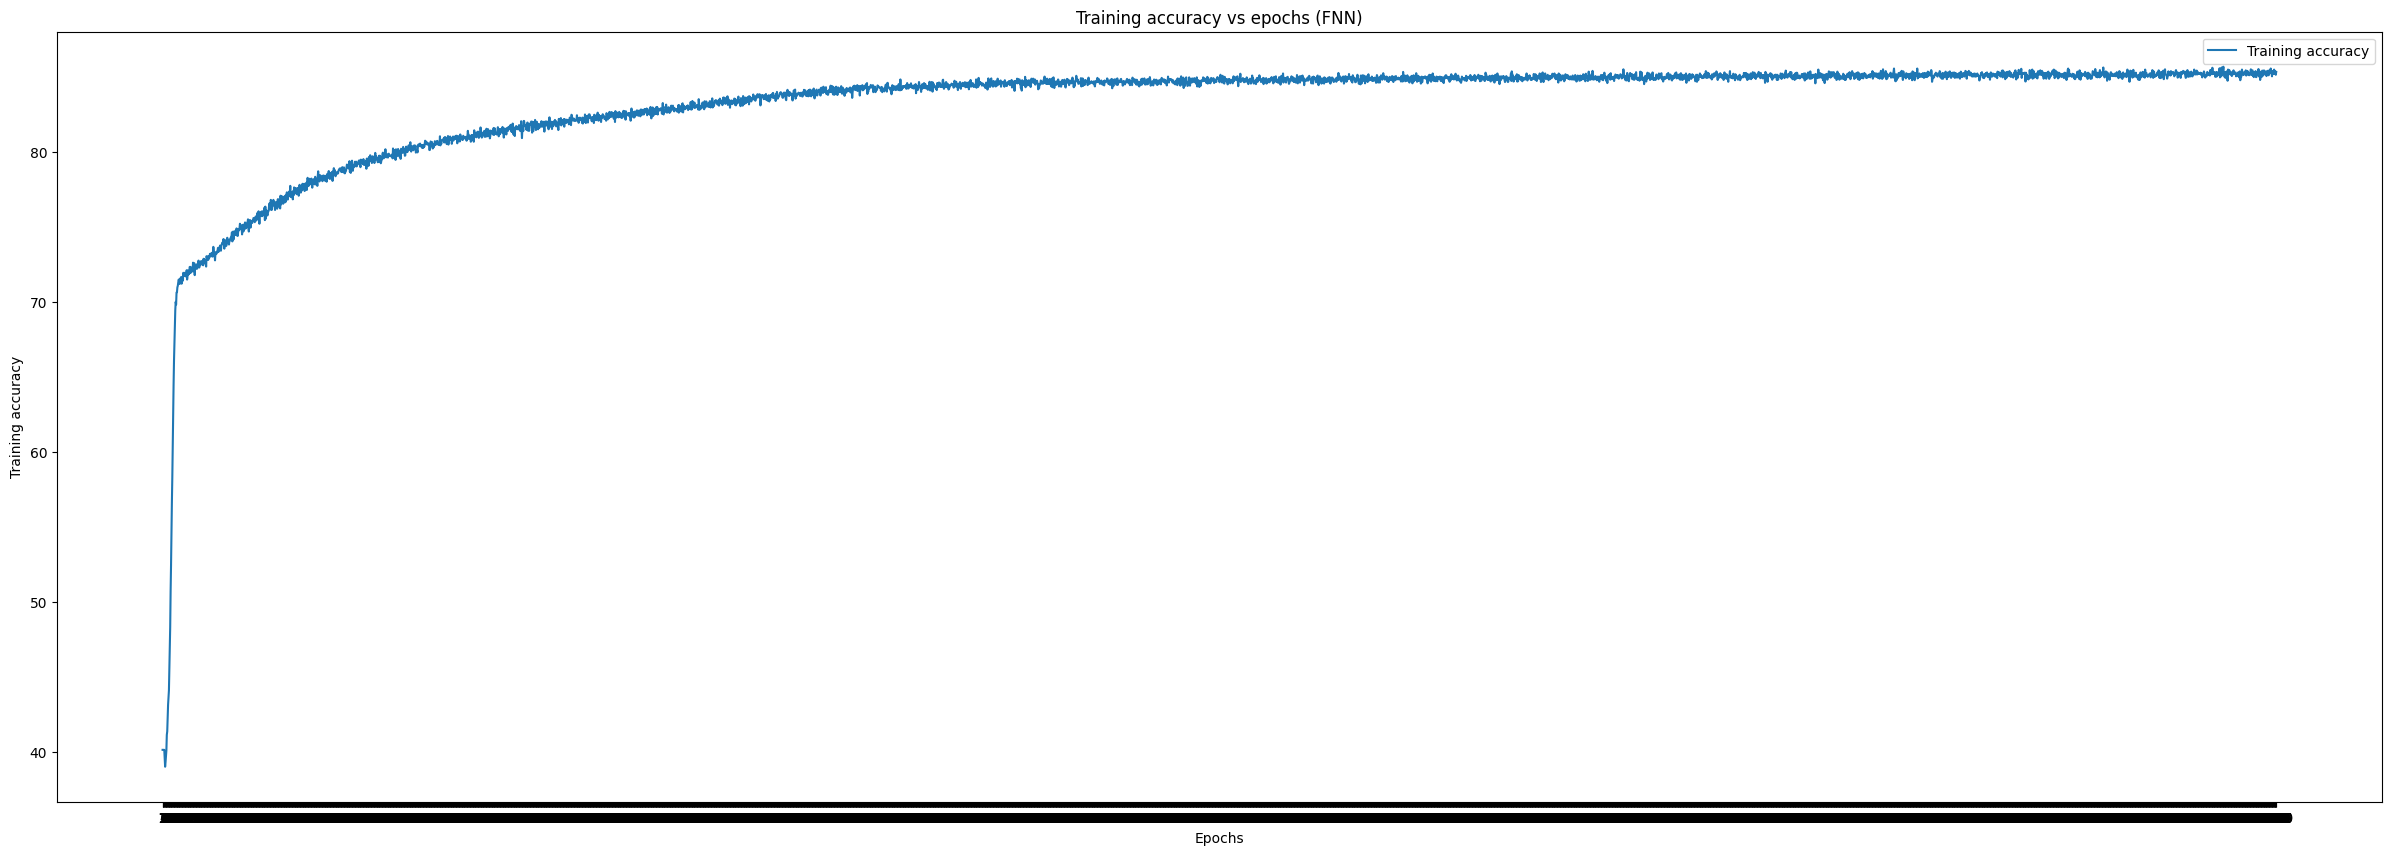

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
epochs = range(1, len(acc_LIST_fnn)+1)
ax.plot(epochs, acc_LIST_fnn, label='Training accuracy')
ax.set_title('Training accuracy vs epochs (FNN)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training accuracy')
ax.legend()
ax.set_xticks(epochs)
plt.show()

Test Accuracy: 83.41968536376953


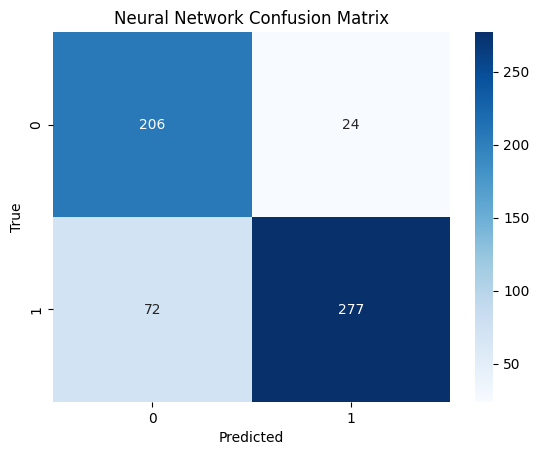

In [ ]:
from sklearn.metrics import confusion_matrix

total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in testloader_2:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)

        outputs = fnn(inputs)

        prediction = torch.argmax(outputs, dim=1)

        num_correct = (prediction == labels).sum()
        correct = correct + num_correct
        total = total + labels.shape[0]

test_acc_fnn = (correct / total) * 100

print('Test Accuracy: ' + str(test_acc_fnn.item()))


# Plot confusion matrix
cm = confusion_matrix(labels.cpu(), prediction.cpu())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()



Without finance

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features3_df, targets3_df, train_size=0.9, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

y_pred_train_log = log_reg.predict(X_train)
acc_train_log = accuracy_score(y_train, y_pred_train_log)

print("Logistic Regression:")
print("Training accuracy:", acc_train_log)
print("Testing accuracy:", acc_log)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

y_pred_train_rf = rf.predict(X_train)
acc_train_rf = accuracy_score(y_train, y_pred_train_rf)

print("\nRandom Forest:")
print("Training accuracy:", acc_train_rf)
print("Testing accuracy:", acc_rf)

# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

y_pred_train_xgb = xgb.predict(X_train)
acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)

print("\nXGBoost:")
print("Training accuracy:", acc_train_xgb)
print("Testing accuracy:", acc_xgb)

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512,512), activation='relu', solver='adam', alpha=0.01, batch_size='auto', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)

y_pred_train_mlp = mlp.predict(X_train)
acc_train_mlp = accuracy_score(y_train, y_pred_train_mlp)

print("\nNeural Network:")
print("Training accuracy:", acc_train_mlp)
print("Testing accuracy:", acc_mlp)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-246-287297c78ef4>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Logistic Regression:
Training accuracy: 0.8252595155709342
Testing accuracy: 0.8255613126079447

Random Forest:
Training accuracy: 0.9911572472126106
Testing accuracy: 0.9050086355785838

XGBoost:
Training accuracy: 0.9142637447135717
Testing accuracy: 0.8877374784110535


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network:
Training accuracy: 0.7914263744713572
Testing accuracy: 0.7979274611398963


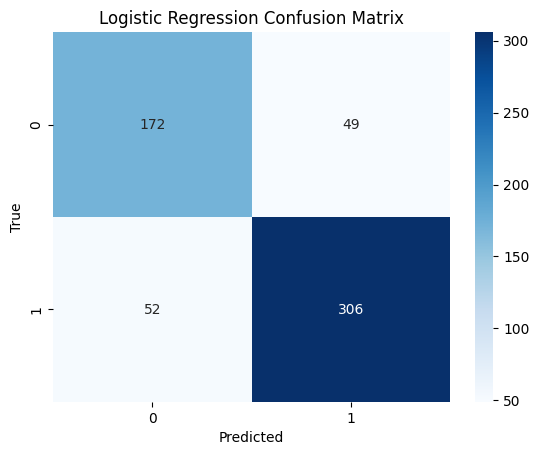

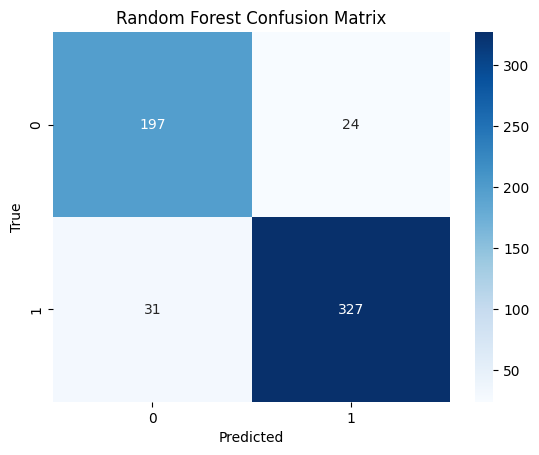

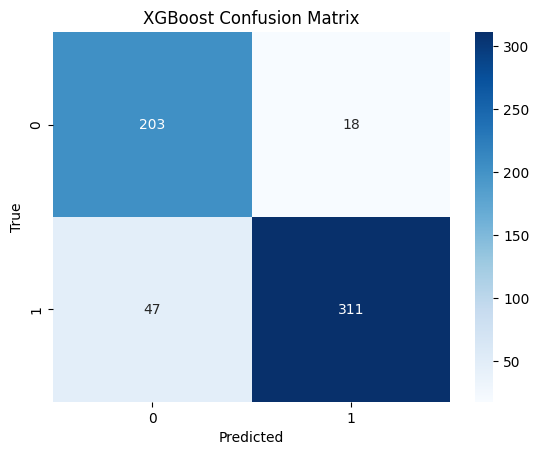

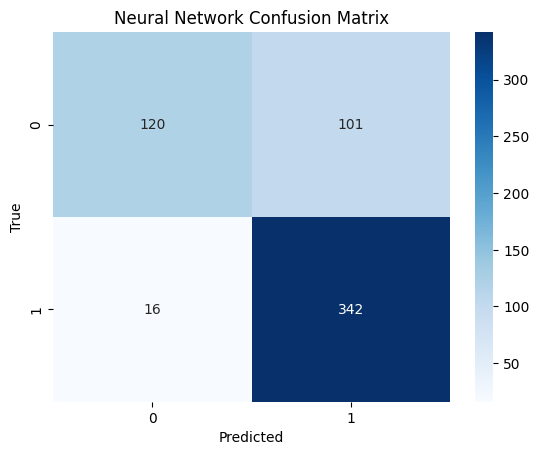

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Confusion matrix for Neural Network
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()


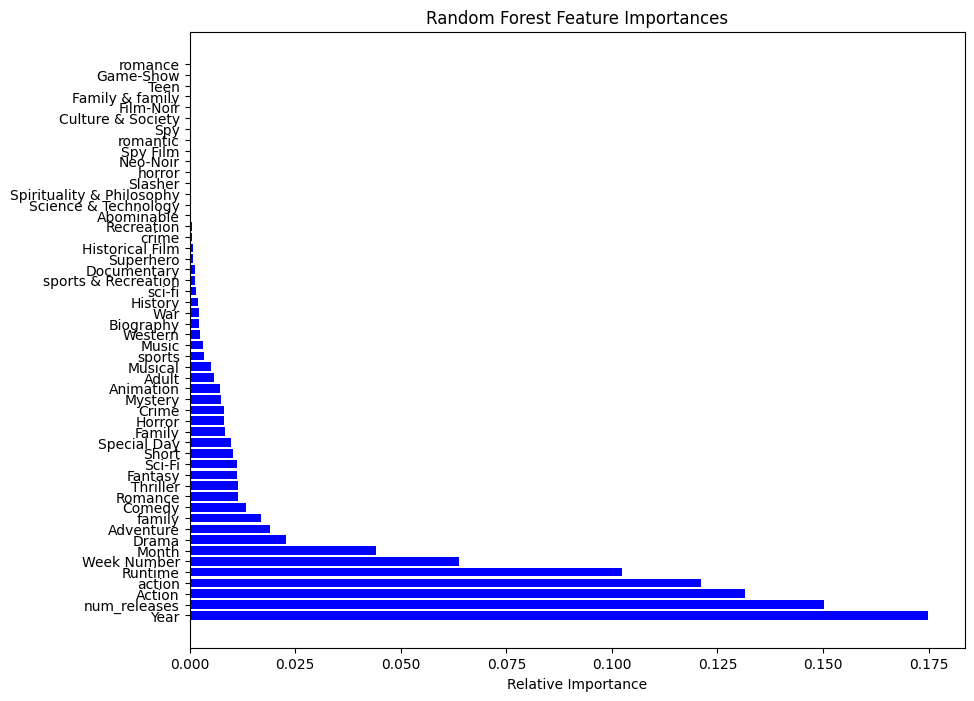

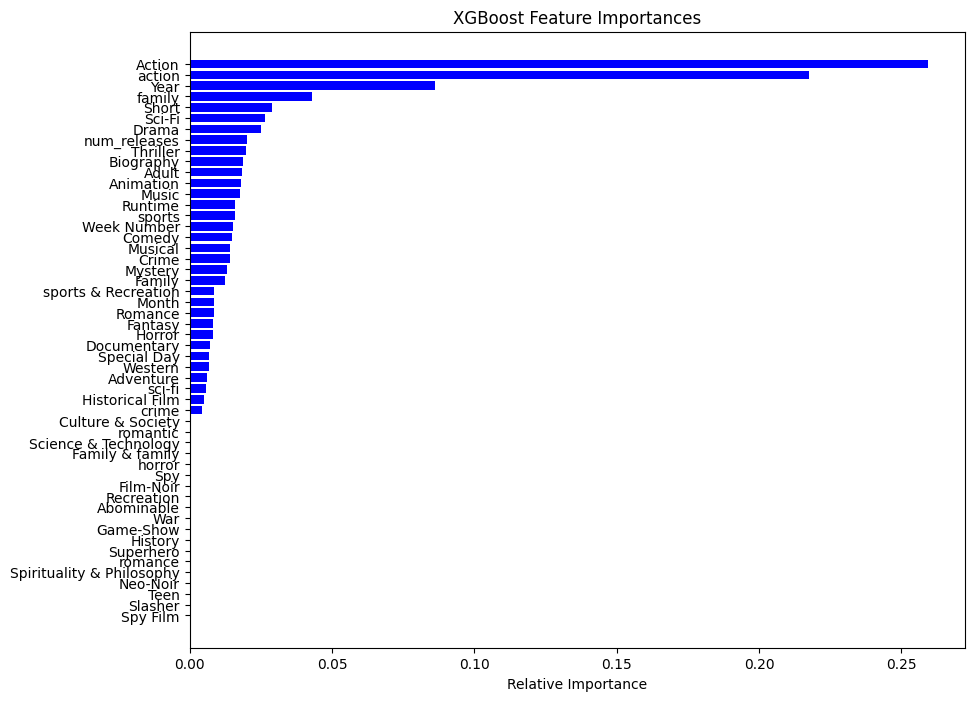

In [ ]:
# Random Forest feature importance
importances = rf.feature_importances_
features = features3_df.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost feature importance
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# **Thank you for grading our project and for your helpful insight throughout this process! We have learned a lot!**